# CGAN Implementation

In [41]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

import csv
from PIL import Image

In [42]:
def my_seed_everywhere(seed: int = 42):
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

my_seed = 42
my_seed_everywhere(my_seed)

In [43]:
import torch

torch.cuda.is_available()

True

In [44]:
print(torch.cuda.get_device_name(0))

GeForce RTX 3090


In [45]:
torch.cuda.device_count()

1

In [46]:
path = os.getcwd()
print(path)

C:\Users\user\Desktop\Aloha\URP\cgan


## Generated Image folder

In [47]:
os.makedirs("images", exist_ok=True)
print(">>> Making images directory...")

>>> Making images directory...


## Hyper-parameter setting

In [48]:
import easydict as parser
 
opt = parser.EasyDict({
        "n_epochs": 200,
        "batch_size": 64, 
        "lr": 0.0002,
        "b1": 0.5,
        "b2": 0.999,
        "n_cpu": 8,
        "latent_dim": 100,
        "n_classes": 14,
        "img_size": 224,
        "channels": 1,
        "sample_interval": 400.
})

img_shape = (opt.channels, opt.img_size, opt.img_size)
print(">>> Image shape:", img_shape)
cuda = True if torch.cuda.is_available() else False
print(">>> GPU Usage:", cuda)

>>> Image shape: (1, 224, 224)
>>> GPU Usage: True


## Dataset

In this first part, we create a loader able to load the data thanks to the csv files of the dataset.
This loader first load labels and paths to the different images.

It includes a pre-processing of labels to deal with uncertainty labels.
Indeed, four different labels exist:
-  **Blanks ('')**: the existence of the pathology is unknown
-  **Ones (1)**: the pathology is detected thanks to the image
-  **Zeros (0)**: the pathology can't be detected thanks to the image
-  **Uncertain (-1)**: the pathology may be detected.

In order to deal with uncertainty labels, different policies can be applied. The easiest ones consists in changing those **Uncertain** labels to *Blanks*, *Ones* or *Zeros*. This process is done thanks to the following class.

In [49]:
# Each file contains pairs (path to image, output vector)
pathFile = '../CheXpert-v1.0-small/annot/train_100p.csv'

In [50]:
class CheXpertDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, policy="ones"):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels
        """
        image_names = []
        labels = []

        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                image_name= line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('../' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Image.open(image_name)
        #image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

## Dataloader

In [51]:
# TRANSFORM
#normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
normalize = transforms.Normalize((0.5), (0.5)) ### for channel 1
imgtransCrop = 224

transformList = []

transformList.append(transforms.RandomResizedCrop(imgtransCrop)) # to 224 by 224 images
#transformList.append(transforms.RandomHorizontalFlip()) ### for Image Augmentation
transformList.append(transforms.ToTensor())
transformList.append(normalize)   

transformSequence=transforms.Compose(transformList)

In [52]:
# LOAD DATASET

dataset = CheXpertDataSet(pathFile, transformSequence, policy="ones") 
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=0)

In [53]:
len(dataloader.dataset)

201284

class: tensor([0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.])


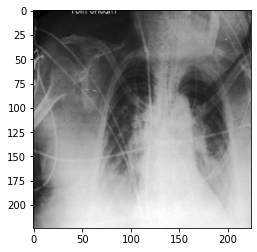

In [54]:
for images, labels in dataloader:  
    sample_image = images[0]    
    sample_label = labels[0]
    break

print("class:", sample_label)
plt.imshow(sample_image.reshape(224, 224, 1), cmap='gray')
plt.show()

## Saving sample image func

In [55]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    labels = F.one_hot(labels, num_classes=opt.n_classes)
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

## Generator Class

In [56]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        #self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes) ### One hot encoding

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        #gen_input = torch.cat((self.label_emb(labels), noise), -1)
        gen_input = torch.cat((labels, noise), -1) ### One hot encoding

        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

## Discriminator Class

In [57]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes) ### One hot encoding

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        #d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        
        d_in = torch.cat((img.view(img.size(0), -1), labels), -1) ### One hot encoding
        validity = self.model(d_in)
        
        return validity

## Loss function and Initializing Model

In [58]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Loss functions
adversarial_loss = torch.nn.MSELoss()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

## Optimizers

In [59]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

## Training

In [ ]:
# ----------
#  Training
# ----------

### Generator and Discriminator Losses
G_losses = []
D_losses = []

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        
        labels = Variable(labels.type(LongTensor))
        print("real:", end="")
        print(real_imgs.shape, labels.shape)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(2, size=(64, 14))))
        #gen_labels = F.one_hot(gen_labels, num_classes=opt.n_classes) ### One hot encoding
        print("gen:", end="")
        print(z.shape, gen_labels.shape)
    
        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=opt.n_classes, batches_done=batches_done)

        ### Loss check
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 0/3145] [D loss: 0.483960] [G loss: 0.985699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1/3145] [D loss: 0.677550] [G loss: 0.939638]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2/3145] [D loss: 0.245726] [G loss: 0.912147]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3/3145] [D loss: 0.118503] [G loss: 0.894680]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 4/3145] [D loss: 0.124570] [G loss: 0.857665]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 5/3145] [D loss: 0.059630]

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 48/3145] [D loss: 0.076124] [G loss: 0.768933]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 49/3145] [D loss: 0.058522] [G loss: 0.847881]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 50/3145] [D loss: 0.053379] [G loss: 1.040058]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 51/3145] [D loss: 0.053427] [G loss: 0.903481]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 52/3145] [D loss: 0.058108] [G loss: 0.838065]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 53/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 97/3145] [D loss: 0.168328] [G loss: 0.391695]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 98/3145] [D loss: 0.071307] [G loss: 1.008762]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 99/3145] [D loss: 0.101657] [G loss: 0.725690]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 100/3145] [D loss: 0.075893] [G loss: 1.080600]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 101/3145] [D loss: 0.099905] [G loss: 0.776824]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 102/3145] [D loss: 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 145/3145] [D loss: 0.087188] [G loss: 0.822749]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 146/3145] [D loss: 0.077507] [G loss: 0.885728]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 147/3145] [D loss: 0.079709] [G loss: 0.827991]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 148/3145] [D loss: 0.083808] [G loss: 1.123161]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 149/3145] [D loss: 0.166052] [G loss: 0.375283]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 150/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 193/3145] [D loss: 0.113250] [G loss: 0.693118]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 194/3145] [D loss: 0.080314] [G loss: 1.014513]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 195/3145] [D loss: 0.067882] [G loss: 0.809093]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 196/3145] [D loss: 0.070728] [G loss: 0.863745]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 197/3145] [D loss: 0.068580] [G loss: 0.690483]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 198/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 242/3145] [D loss: 0.078278] [G loss: 0.737172]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 243/3145] [D loss: 0.068476] [G loss: 0.953640]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 244/3145] [D loss: 0.073565] [G loss: 0.706545]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 245/3145] [D loss: 0.100154] [G loss: 1.024127]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 246/3145] [D loss: 0.082535] [G loss: 0.765946]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 247/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 291/3145] [D loss: 0.060155] [G loss: 1.104888]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 292/3145] [D loss: 0.065833] [G loss: 0.769433]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 293/3145] [D loss: 0.072763] [G loss: 0.986606]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 294/3145] [D loss: 0.108193] [G loss: 0.495508]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 295/3145] [D loss: 0.133762] [G loss: 1.441452]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 296/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 340/3145] [D loss: 0.048937] [G loss: 0.983132]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 341/3145] [D loss: 0.047787] [G loss: 0.875176]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 342/3145] [D loss: 0.063084] [G loss: 0.782545]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 343/3145] [D loss: 0.053814] [G loss: 0.913987]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 344/3145] [D loss: 0.093029] [G loss: 0.572024]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 345/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 389/3145] [D loss: 0.069025] [G loss: 0.705269]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 390/3145] [D loss: 0.078089] [G loss: 0.904423]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 391/3145] [D loss: 0.079768] [G loss: 0.737235]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 392/3145] [D loss: 0.081717] [G loss: 0.752611]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 393/3145] [D loss: 0.075095] [G loss: 0.809646]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 394/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 437/3145] [D loss: 0.061275] [G loss: 1.013317]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 438/3145] [D loss: 0.073424] [G loss: 0.757357]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 439/3145] [D loss: 0.062090] [G loss: 0.779556]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 440/3145] [D loss: 0.108871] [G loss: 0.964072]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 441/3145] [D loss: 0.093626] [G loss: 0.666130]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 442/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 486/3145] [D loss: 0.102985] [G loss: 1.093810]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 487/3145] [D loss: 0.085057] [G loss: 0.571851]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 488/3145] [D loss: 0.062937] [G loss: 0.910780]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 489/3145] [D loss: 0.064120] [G loss: 0.899052]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 490/3145] [D loss: 0.072436] [G loss: 0.614184]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 491/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 534/3145] [D loss: 0.091176] [G loss: 1.188212]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 535/3145] [D loss: 0.107035] [G loss: 0.774251]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 536/3145] [D loss: 0.086580] [G loss: 0.701394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 537/3145] [D loss: 0.071568] [G loss: 0.853430]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 538/3145] [D loss: 0.068330] [G loss: 0.775049]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 539/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 582/3145] [D loss: 0.058467] [G loss: 0.871288]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 583/3145] [D loss: 0.080037] [G loss: 0.608225]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 584/3145] [D loss: 0.060007] [G loss: 0.924495]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 585/3145] [D loss: 0.064463] [G loss: 0.906644]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 586/3145] [D loss: 0.070259] [G loss: 0.743886]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 587/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 630/3145] [D loss: 0.096336] [G loss: 0.620657]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 631/3145] [D loss: 0.063195] [G loss: 0.812118]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 632/3145] [D loss: 0.101689] [G loss: 0.835305]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 633/3145] [D loss: 0.097695] [G loss: 0.576682]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 634/3145] [D loss: 0.131417] [G loss: 1.150105]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 635/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 678/3145] [D loss: 0.090670] [G loss: 0.917081]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 679/3145] [D loss: 0.170828] [G loss: 0.371985]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 680/3145] [D loss: 0.255002] [G loss: 1.541141]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 681/3145] [D loss: 0.135112] [G loss: 0.686992]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 682/3145] [D loss: 0.108554] [G loss: 0.542335]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 683/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 727/3145] [D loss: 0.076640] [G loss: 0.669682]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 728/3145] [D loss: 0.122031] [G loss: 0.654512]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 729/3145] [D loss: 0.156018] [G loss: 1.248542]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 730/3145] [D loss: 0.193413] [G loss: 0.278865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 731/3145] [D loss: 0.153854] [G loss: 1.137826]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 732/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 775/3145] [D loss: 0.110090] [G loss: 0.664367]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 776/3145] [D loss: 0.106134] [G loss: 0.596234]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 777/3145] [D loss: 0.096610] [G loss: 0.858946]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 778/3145] [D loss: 0.098834] [G loss: 0.843048]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 779/3145] [D loss: 0.089776] [G loss: 0.701797]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 780/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 823/3145] [D loss: 0.086707] [G loss: 0.758784]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 824/3145] [D loss: 0.098617] [G loss: 0.682732]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 825/3145] [D loss: 0.096978] [G loss: 0.587155]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 826/3145] [D loss: 0.103171] [G loss: 0.780206]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 827/3145] [D loss: 0.102380] [G loss: 0.642441]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 828/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 871/3145] [D loss: 0.181719] [G loss: 0.659957]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 872/3145] [D loss: 0.128271] [G loss: 0.553314]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 873/3145] [D loss: 0.138452] [G loss: 0.514267]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 874/3145] [D loss: 0.134013] [G loss: 0.724567]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 875/3145] [D loss: 0.154859] [G loss: 0.544248]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 876/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 919/3145] [D loss: 0.164953] [G loss: 0.503019]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 920/3145] [D loss: 0.147129] [G loss: 0.953688]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 921/3145] [D loss: 0.105626] [G loss: 0.702383]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 922/3145] [D loss: 0.108945] [G loss: 0.671384]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 923/3145] [D loss: 0.133736] [G loss: 0.747905]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 924/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 967/3145] [D loss: 0.089830] [G loss: 0.657297]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 968/3145] [D loss: 0.123266] [G loss: 0.829054]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 969/3145] [D loss: 0.124585] [G loss: 0.831984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 970/3145] [D loss: 0.253209] [G loss: 0.309378]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 971/3145] [D loss: 0.340682] [G loss: 1.350026]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 972/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1015/3145] [D loss: 0.158208] [G loss: 0.587482]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1016/3145] [D loss: 0.164588] [G loss: 0.764683]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1017/3145] [D loss: 0.161092] [G loss: 0.645623]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1018/3145] [D loss: 0.119314] [G loss: 0.776529]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1019/3145] [D loss: 0.105232] [G loss: 0.606055]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1020/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1063/3145] [D loss: 0.111081] [G loss: 0.666930]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1064/3145] [D loss: 0.148990] [G loss: 0.891949]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1065/3145] [D loss: 0.116467] [G loss: 0.714490]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1066/3145] [D loss: 0.131611] [G loss: 0.441344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1067/3145] [D loss: 0.125401] [G loss: 0.768439]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1068/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1111/3145] [D loss: 0.176546] [G loss: 0.475603]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1112/3145] [D loss: 0.195749] [G loss: 0.500545]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1113/3145] [D loss: 0.168776] [G loss: 0.581150]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1114/3145] [D loss: 0.157421] [G loss: 0.633305]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1115/3145] [D loss: 0.180697] [G loss: 0.521244]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1116/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1159/3145] [D loss: 0.150174] [G loss: 0.633020]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1160/3145] [D loss: 0.164522] [G loss: 0.580362]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1161/3145] [D loss: 0.149339] [G loss: 0.549956]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1162/3145] [D loss: 0.175609] [G loss: 1.046617]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1163/3145] [D loss: 0.143099] [G loss: 0.439753]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1164/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1207/3145] [D loss: 0.171898] [G loss: 0.905156]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1208/3145] [D loss: 0.151336] [G loss: 0.566854]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1209/3145] [D loss: 0.107120] [G loss: 0.597212]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1210/3145] [D loss: 0.111771] [G loss: 0.887157]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1211/3145] [D loss: 0.124910] [G loss: 0.693755]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1212/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1256/3145] [D loss: 0.149856] [G loss: 0.480428]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1257/3145] [D loss: 0.130257] [G loss: 0.645679]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1258/3145] [D loss: 0.142449] [G loss: 0.800120]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1259/3145] [D loss: 0.129232] [G loss: 0.587106]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1260/3145] [D loss: 0.162180] [G loss: 0.946191]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1261/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1304/3145] [D loss: 0.094554] [G loss: 0.737153]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1305/3145] [D loss: 0.106387] [G loss: 0.770203]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1306/3145] [D loss: 0.097295] [G loss: 0.618324]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1307/3145] [D loss: 0.099575] [G loss: 0.688695]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1308/3145] [D loss: 0.130021] [G loss: 0.626964]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1309/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1353/3145] [D loss: 0.115602] [G loss: 0.735924]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1354/3145] [D loss: 0.133669] [G loss: 0.578219]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1355/3145] [D loss: 0.099615] [G loss: 0.680517]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1356/3145] [D loss: 0.108093] [G loss: 0.719966]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1357/3145] [D loss: 0.152388] [G loss: 0.486793]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1358/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1402/3145] [D loss: 0.204733] [G loss: 1.117873]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1403/3145] [D loss: 0.114628] [G loss: 0.626020]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1404/3145] [D loss: 0.169048] [G loss: 0.438721]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1405/3145] [D loss: 0.131249] [G loss: 0.974720]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1406/3145] [D loss: 0.149170] [G loss: 0.900574]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1407/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1450/3145] [D loss: 0.138910] [G loss: 0.823916]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1451/3145] [D loss: 0.191650] [G loss: 0.281468]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1452/3145] [D loss: 0.395146] [G loss: 1.600763]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1453/3145] [D loss: 0.133148] [G loss: 0.784971]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1454/3145] [D loss: 0.196456] [G loss: 0.349877]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1455/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1499/3145] [D loss: 0.123871] [G loss: 0.759692]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1500/3145] [D loss: 0.151674] [G loss: 0.818741]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1501/3145] [D loss: 0.132122] [G loss: 0.909394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1502/3145] [D loss: 0.132389] [G loss: 0.533888]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1503/3145] [D loss: 0.164187] [G loss: 0.756976]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1504/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1547/3145] [D loss: 0.110427] [G loss: 0.676596]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1548/3145] [D loss: 0.120958] [G loss: 0.852336]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1549/3145] [D loss: 0.104191] [G loss: 0.720346]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1550/3145] [D loss: 0.115028] [G loss: 0.658359]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1551/3145] [D loss: 0.112539] [G loss: 0.744790]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1552/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1595/3145] [D loss: 0.133939] [G loss: 0.667964]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1596/3145] [D loss: 0.109564] [G loss: 0.793753]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1597/3145] [D loss: 0.124379] [G loss: 0.697723]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1598/3145] [D loss: 0.117253] [G loss: 0.599157]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1599/3145] [D loss: 0.119117] [G loss: 0.827783]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1600/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1643/3145] [D loss: 0.178293] [G loss: 0.646792]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1644/3145] [D loss: 0.132998] [G loss: 0.592156]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1645/3145] [D loss: 0.148762] [G loss: 0.676344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1646/3145] [D loss: 0.162223] [G loss: 0.495880]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1647/3145] [D loss: 0.138802] [G loss: 0.780528]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1648/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1691/3145] [D loss: 0.182384] [G loss: 0.450063]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1692/3145] [D loss: 0.183902] [G loss: 0.387692]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1693/3145] [D loss: 0.188047] [G loss: 0.903232]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1694/3145] [D loss: 0.120322] [G loss: 0.749579]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1695/3145] [D loss: 0.139074] [G loss: 0.470033]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1696/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1739/3145] [D loss: 0.164845] [G loss: 0.643376]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1740/3145] [D loss: 0.189063] [G loss: 0.343305]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1741/3145] [D loss: 0.172700] [G loss: 0.735678]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1742/3145] [D loss: 0.121171] [G loss: 0.795130]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1743/3145] [D loss: 0.148222] [G loss: 0.545011]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1744/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1788/3145] [D loss: 0.198329] [G loss: 0.460707]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1789/3145] [D loss: 0.155483] [G loss: 0.520141]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1790/3145] [D loss: 0.129943] [G loss: 0.593962]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1791/3145] [D loss: 0.147508] [G loss: 0.620094]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1792/3145] [D loss: 0.178760] [G loss: 0.764825]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1793/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1837/3145] [D loss: 0.166798] [G loss: 0.504318]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1838/3145] [D loss: 0.152293] [G loss: 0.674490]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1839/3145] [D loss: 0.136088] [G loss: 0.675483]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1840/3145] [D loss: 0.148261] [G loss: 0.527058]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1841/3145] [D loss: 0.132294] [G loss: 0.583386]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1842/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1886/3145] [D loss: 0.182381] [G loss: 0.756989]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1887/3145] [D loss: 0.160586] [G loss: 0.431477]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1888/3145] [D loss: 0.159619] [G loss: 0.557090]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1889/3145] [D loss: 0.136349] [G loss: 0.708313]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1890/3145] [D loss: 0.202608] [G loss: 0.440825]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1891/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1935/3145] [D loss: 0.186226] [G loss: 0.689192]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1936/3145] [D loss: 0.174214] [G loss: 0.537318]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1937/3145] [D loss: 0.200930] [G loss: 0.979313]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1938/3145] [D loss: 0.154907] [G loss: 0.581544]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1939/3145] [D loss: 0.157104] [G loss: 0.505580]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1940/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1984/3145] [D loss: 0.169907] [G loss: 0.632120]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1985/3145] [D loss: 0.183636] [G loss: 0.465266]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1986/3145] [D loss: 0.207213] [G loss: 0.799604]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1987/3145] [D loss: 0.180162] [G loss: 0.458325]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1988/3145] [D loss: 0.138329] [G loss: 0.565676]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 1989/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2033/3145] [D loss: 0.123603] [G loss: 0.541400]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2034/3145] [D loss: 0.154120] [G loss: 0.709051]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2035/3145] [D loss: 0.160534] [G loss: 0.447501]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2036/3145] [D loss: 0.141307] [G loss: 0.638292]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2037/3145] [D loss: 0.175895] [G loss: 0.539378]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2038/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2081/3145] [D loss: 0.142365] [G loss: 0.785302]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2082/3145] [D loss: 0.182937] [G loss: 0.493597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2083/3145] [D loss: 0.163261] [G loss: 0.868756]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2084/3145] [D loss: 0.156074] [G loss: 0.670455]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2085/3145] [D loss: 0.154609] [G loss: 0.441507]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2086/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2130/3145] [D loss: 0.208544] [G loss: 0.718877]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2131/3145] [D loss: 0.167558] [G loss: 0.552631]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2132/3145] [D loss: 0.128814] [G loss: 0.497001]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2133/3145] [D loss: 0.118372] [G loss: 0.508937]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2134/3145] [D loss: 0.160773] [G loss: 0.576270]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2135/3145] 

[Epoch 0/200] [Batch 2177/3145] [D loss: 0.126043] [G loss: 0.645206]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2178/3145] [D loss: 0.134480] [G loss: 0.630903]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2179/3145] [D loss: 0.108279] [G loss: 0.545453]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2180/3145] [D loss: 0.117552] [G loss: 0.572726]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2181/3145] [D loss: 0.112929] [G loss: 0.666019]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2182/3145] [D loss: 0.123916] [G loss: 0.670864]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2225/3145] [D loss: 0.291985] [G loss: 0.931939]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2226/3145] [D loss: 0.188933] [G loss: 0.558683]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2227/3145] [D loss: 0.174777] [G loss: 0.472049]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2228/3145] [D loss: 0.169516] [G loss: 0.554360]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2229/3145] [D loss: 0.158156] [G loss: 0.601809]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2230/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2273/3145] [D loss: 0.143354] [G loss: 0.580153]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2274/3145] [D loss: 0.136992] [G loss: 0.578221]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2275/3145] [D loss: 0.144499] [G loss: 0.710643]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2276/3145] [D loss: 0.128084] [G loss: 0.558401]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2277/3145] [D loss: 0.152849] [G loss: 0.675081]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2278/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2321/3145] [D loss: 0.180096] [G loss: 0.435013]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2322/3145] [D loss: 0.151457] [G loss: 0.701036]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2323/3145] [D loss: 0.162522] [G loss: 0.588747]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2324/3145] [D loss: 0.160445] [G loss: 0.469438]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2325/3145] [D loss: 0.160478] [G loss: 0.541014]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2326/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2369/3145] [D loss: 0.157372] [G loss: 0.694933]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2370/3145] [D loss: 0.160752] [G loss: 0.428903]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2371/3145] [D loss: 0.188989] [G loss: 0.952981]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2372/3145] [D loss: 0.176302] [G loss: 0.506881]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2373/3145] [D loss: 0.181621] [G loss: 0.414910]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2374/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2417/3145] [D loss: 0.141004] [G loss: 0.658520]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2418/3145] [D loss: 0.181926] [G loss: 0.468426]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2419/3145] [D loss: 0.186918] [G loss: 0.778284]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2420/3145] [D loss: 0.161568] [G loss: 0.461955]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2421/3145] [D loss: 0.115085] [G loss: 0.559405]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2422/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2466/3145] [D loss: 0.150409] [G loss: 0.551775]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2467/3145] [D loss: 0.111923] [G loss: 0.587838]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2468/3145] [D loss: 0.122854] [G loss: 0.487921]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2469/3145] [D loss: 0.106484] [G loss: 0.650213]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2470/3145] [D loss: 0.131156] [G loss: 0.608391]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2471/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2514/3145] [D loss: 0.175512] [G loss: 0.534130]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2515/3145] [D loss: 0.145160] [G loss: 0.491269]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2516/3145] [D loss: 0.145981] [G loss: 0.543974]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2517/3145] [D loss: 0.178825] [G loss: 0.715789]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2518/3145] [D loss: 0.238545] [G loss: 0.436013]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2519/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2562/3145] [D loss: 0.125983] [G loss: 0.630129]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2563/3145] [D loss: 0.137662] [G loss: 0.571911]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2564/3145] [D loss: 0.188762] [G loss: 0.582654]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2565/3145] [D loss: 0.167521] [G loss: 0.584243]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2566/3145] [D loss: 0.196897] [G loss: 0.523348]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2567/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2610/3145] [D loss: 0.175891] [G loss: 0.496938]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2611/3145] [D loss: 0.146694] [G loss: 0.545290]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2612/3145] [D loss: 0.187932] [G loss: 0.788159]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2613/3145] [D loss: 0.161802] [G loss: 0.532965]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2614/3145] [D loss: 0.171300] [G loss: 0.751463]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2615/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2659/3145] [D loss: 0.209535] [G loss: 0.958052]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2660/3145] [D loss: 0.165402] [G loss: 0.400126]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2661/3145] [D loss: 0.120840] [G loss: 0.591940]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2662/3145] [D loss: 0.169609] [G loss: 0.758838]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2663/3145] [D loss: 0.131295] [G loss: 0.494725]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2664/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2707/3145] [D loss: 0.168530] [G loss: 0.497281]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2708/3145] [D loss: 0.182295] [G loss: 0.685492]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2709/3145] [D loss: 0.159034] [G loss: 0.566737]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2710/3145] [D loss: 0.233463] [G loss: 0.406247]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2711/3145] [D loss: 0.309213] [G loss: 1.044383]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2712/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2756/3145] [D loss: 0.161752] [G loss: 0.649805]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2757/3145] [D loss: 0.135182] [G loss: 0.601093]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2758/3145] [D loss: 0.145488] [G loss: 0.755949]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2759/3145] [D loss: 0.146141] [G loss: 0.508209]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2760/3145] [D loss: 0.152836] [G loss: 0.695392]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2761/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2805/3145] [D loss: 0.137766] [G loss: 0.519858]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2806/3145] [D loss: 0.149048] [G loss: 0.876455]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2807/3145] [D loss: 0.133414] [G loss: 0.597405]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2808/3145] [D loss: 0.154000] [G loss: 0.527823]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2809/3145] [D loss: 0.179422] [G loss: 1.009353]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2810/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2853/3145] [D loss: 0.159430] [G loss: 0.572729]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2854/3145] [D loss: 0.138614] [G loss: 0.517978]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2855/3145] [D loss: 0.164525] [G loss: 0.540546]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2856/3145] [D loss: 0.148962] [G loss: 0.464820]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2857/3145] [D loss: 0.191833] [G loss: 0.694569]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2858/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2901/3145] [D loss: 0.212894] [G loss: 1.073542]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2902/3145] [D loss: 0.147116] [G loss: 0.683847]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2903/3145] [D loss: 0.148835] [G loss: 0.423636]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2904/3145] [D loss: 0.154691] [G loss: 0.727134]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2905/3145] [D loss: 0.132986] [G loss: 0.537390]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2906/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2949/3145] [D loss: 0.110994] [G loss: 0.570651]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2950/3145] [D loss: 0.107285] [G loss: 0.685030]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2951/3145] [D loss: 0.119033] [G loss: 0.668463]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2952/3145] [D loss: 0.150149] [G loss: 0.570061]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2953/3145] [D loss: 0.172556] [G loss: 0.813181]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2954/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2997/3145] [D loss: 0.184994] [G loss: 0.443394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2998/3145] [D loss: 0.187559] [G loss: 0.799460]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 2999/3145] [D loss: 0.197086] [G loss: 0.407341]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3000/3145] [D loss: 0.151676] [G loss: 0.630450]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3001/3145] [D loss: 0.176581] [G loss: 0.618811]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3002/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3045/3145] [D loss: 0.115391] [G loss: 0.619788]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3046/3145] [D loss: 0.153550] [G loss: 0.724474]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3047/3145] [D loss: 0.127462] [G loss: 0.691003]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3048/3145] [D loss: 0.141193] [G loss: 0.572699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3049/3145] [D loss: 0.105692] [G loss: 0.581507]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3050/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3094/3145] [D loss: 0.155233] [G loss: 0.691264]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3095/3145] [D loss: 0.161191] [G loss: 0.484236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3096/3145] [D loss: 0.132788] [G loss: 0.603390]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3097/3145] [D loss: 0.134523] [G loss: 0.612438]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3098/3145] [D loss: 0.126287] [G loss: 0.620812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3099/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3142/3145] [D loss: 0.124093] [G loss: 0.626112]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3143/3145] [D loss: 0.133404] [G loss: 0.519728]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 0/200] [Batch 3144/3145] [D loss: 0.137037] [G loss: 0.783036]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 0/3145] [D loss: 0.169453] [G loss: 0.500919]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1/3145] [D loss: 0.201314] [G loss: 0.829536]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2/3145] [D loss: 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 46/3145] [D loss: 0.143985] [G loss: 0.610218]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 47/3145] [D loss: 0.232691] [G loss: 0.416591]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 48/3145] [D loss: 0.279363] [G loss: 1.073279]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 49/3145] [D loss: 0.167194] [G loss: 0.729327]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 50/3145] [D loss: 0.157826] [G loss: 0.421434]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 51/3145] [D loss: 0.1

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 94/3145] [D loss: 0.358486] [G loss: 1.110738]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 95/3145] [D loss: 0.233806] [G loss: 0.713863]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 96/3145] [D loss: 0.197077] [G loss: 0.354831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 97/3145] [D loss: 0.173965] [G loss: 0.359725]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 98/3145] [D loss: 0.178262] [G loss: 0.484840]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 99/3145] [D loss: 0.1

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 142/3145] [D loss: 0.108594] [G loss: 0.714230]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 143/3145] [D loss: 0.124722] [G loss: 0.675923]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 144/3145] [D loss: 0.121345] [G loss: 0.511551]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 145/3145] [D loss: 0.130557] [G loss: 0.710835]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 146/3145] [D loss: 0.106695] [G loss: 0.687964]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 147/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 191/3145] [D loss: 0.144444] [G loss: 0.751001]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 192/3145] [D loss: 0.131596] [G loss: 0.501318]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 193/3145] [D loss: 0.131379] [G loss: 0.446133]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 194/3145] [D loss: 0.179950] [G loss: 0.802218]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 195/3145] [D loss: 0.154100] [G loss: 0.421757]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 196/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 240/3145] [D loss: 0.156937] [G loss: 0.636270]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 241/3145] [D loss: 0.192468] [G loss: 0.481181]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 242/3145] [D loss: 0.267925] [G loss: 0.914347]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 243/3145] [D loss: 0.154276] [G loss: 0.529758]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 244/3145] [D loss: 0.134448] [G loss: 0.556100]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 245/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 289/3145] [D loss: 0.126177] [G loss: 0.565271]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 290/3145] [D loss: 0.141122] [G loss: 0.549632]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 291/3145] [D loss: 0.166948] [G loss: 0.788323]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 292/3145] [D loss: 0.127165] [G loss: 0.499263]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 293/3145] [D loss: 0.111415] [G loss: 0.541775]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 294/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 337/3145] [D loss: 0.166397] [G loss: 0.548980]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 338/3145] [D loss: 0.170219] [G loss: 0.513784]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 339/3145] [D loss: 0.151002] [G loss: 0.658863]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 340/3145] [D loss: 0.147580] [G loss: 0.554437]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 341/3145] [D loss: 0.135729] [G loss: 0.639738]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 342/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 385/3145] [D loss: 0.143844] [G loss: 0.655139]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 386/3145] [D loss: 0.112500] [G loss: 0.551209]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 387/3145] [D loss: 0.102652] [G loss: 0.534629]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 388/3145] [D loss: 0.156397] [G loss: 0.766963]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 389/3145] [D loss: 0.120201] [G loss: 0.536040]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 390/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 434/3145] [D loss: 0.156215] [G loss: 0.772284]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 435/3145] [D loss: 0.120127] [G loss: 0.635501]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 436/3145] [D loss: 0.137084] [G loss: 0.432506]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 437/3145] [D loss: 0.148124] [G loss: 0.805775]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 438/3145] [D loss: 0.126036] [G loss: 0.491414]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 439/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 483/3145] [D loss: 0.122429] [G loss: 0.600808]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 484/3145] [D loss: 0.131704] [G loss: 0.539129]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 485/3145] [D loss: 0.157363] [G loss: 0.621963]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 486/3145] [D loss: 0.133493] [G loss: 0.596187]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 487/3145] [D loss: 0.156897] [G loss: 0.402224]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 488/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 531/3145] [D loss: 0.124620] [G loss: 0.531845]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 532/3145] [D loss: 0.120191] [G loss: 0.746451]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 533/3145] [D loss: 0.134626] [G loss: 0.518750]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 534/3145] [D loss: 0.201104] [G loss: 0.796981]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 535/3145] [D loss: 0.151794] [G loss: 0.400721]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 536/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 580/3145] [D loss: 0.123453] [G loss: 0.568642]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 581/3145] [D loss: 0.107407] [G loss: 0.537609]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 582/3145] [D loss: 0.097421] [G loss: 0.662957]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 583/3145] [D loss: 0.101923] [G loss: 0.603688]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 584/3145] [D loss: 0.117925] [G loss: 0.563659]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 585/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 629/3145] [D loss: 0.121232] [G loss: 0.628264]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 630/3145] [D loss: 0.161490] [G loss: 0.452190]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 631/3145] [D loss: 0.166704] [G loss: 0.955281]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 632/3145] [D loss: 0.161391] [G loss: 0.650015]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 633/3145] [D loss: 0.168940] [G loss: 0.444996]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 634/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 677/3145] [D loss: 0.121584] [G loss: 0.494590]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 678/3145] [D loss: 0.118994] [G loss: 0.532241]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 679/3145] [D loss: 0.129221] [G loss: 0.515959]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 680/3145] [D loss: 0.116362] [G loss: 0.527599]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 681/3145] [D loss: 0.088959] [G loss: 0.632783]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 682/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 725/3145] [D loss: 0.204477] [G loss: 0.407727]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 726/3145] [D loss: 0.159911] [G loss: 0.606595]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 727/3145] [D loss: 0.143277] [G loss: 0.563900]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 728/3145] [D loss: 0.135990] [G loss: 0.480922]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 729/3145] [D loss: 0.109143] [G loss: 0.649241]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 730/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 773/3145] [D loss: 0.112838] [G loss: 0.675091]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 774/3145] [D loss: 0.135521] [G loss: 0.446728]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 775/3145] [D loss: 0.133694] [G loss: 0.837722]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 776/3145] [D loss: 0.126236] [G loss: 0.517354]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 777/3145] [D loss: 0.097251] [G loss: 0.589812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 778/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 822/3145] [D loss: 0.148630] [G loss: 0.542674]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 823/3145] [D loss: 0.156890] [G loss: 0.594132]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 824/3145] [D loss: 0.163087] [G loss: 0.567345]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 825/3145] [D loss: 0.147424] [G loss: 0.454999]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 826/3145] [D loss: 0.153106] [G loss: 0.722153]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 827/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 871/3145] [D loss: 0.128038] [G loss: 0.749826]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 872/3145] [D loss: 0.107127] [G loss: 0.585575]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 873/3145] [D loss: 0.097087] [G loss: 0.656047]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 874/3145] [D loss: 0.115594] [G loss: 0.791642]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 875/3145] [D loss: 0.136240] [G loss: 0.557959]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 876/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 919/3145] [D loss: 0.149573] [G loss: 0.528223]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 920/3145] [D loss: 0.136106] [G loss: 0.478303]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 921/3145] [D loss: 0.124393] [G loss: 0.620723]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 922/3145] [D loss: 0.097713] [G loss: 0.561624]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 923/3145] [D loss: 0.110838] [G loss: 0.615503]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 924/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 968/3145] [D loss: 0.104555] [G loss: 0.618591]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 969/3145] [D loss: 0.109908] [G loss: 0.555382]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 970/3145] [D loss: 0.092435] [G loss: 0.659885]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 971/3145] [D loss: 0.109037] [G loss: 0.578322]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 972/3145] [D loss: 0.093258] [G loss: 0.584078]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 973/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1017/3145] [D loss: 0.115276] [G loss: 0.689457]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1018/3145] [D loss: 0.104534] [G loss: 0.567284]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1019/3145] [D loss: 0.107521] [G loss: 0.714408]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1020/3145] [D loss: 0.124607] [G loss: 0.675427]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1021/3145] [D loss: 0.115177] [G loss: 0.654830]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1022/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1065/3145] [D loss: 0.106057] [G loss: 0.586878]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1066/3145] [D loss: 0.124952] [G loss: 0.521716]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1067/3145] [D loss: 0.146097] [G loss: 0.879526]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1068/3145] [D loss: 0.141151] [G loss: 0.592691]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1069/3145] [D loss: 0.124318] [G loss: 0.501510]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1070/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1114/3145] [D loss: 0.161962] [G loss: 0.994030]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1115/3145] [D loss: 0.120265] [G loss: 0.669573]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1116/3145] [D loss: 0.228878] [G loss: 0.305048]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1117/3145] [D loss: 0.281718] [G loss: 1.082371]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1118/3145] [D loss: 0.158129] [G loss: 0.810997]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1119/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1162/3145] [D loss: 0.141056] [G loss: 0.517192]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1163/3145] [D loss: 0.168084] [G loss: 0.914121]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1164/3145] [D loss: 0.207950] [G loss: 0.419082]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1165/3145] [D loss: 0.289596] [G loss: 1.203797]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1166/3145] [D loss: 0.286979] [G loss: 0.878864]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1167/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1210/3145] [D loss: 0.116539] [G loss: 0.633419]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1211/3145] [D loss: 0.091762] [G loss: 0.668161]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1212/3145] [D loss: 0.094828] [G loss: 0.705086]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1213/3145] [D loss: 0.102218] [G loss: 0.691730]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1214/3145] [D loss: 0.101286] [G loss: 0.766388]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1215/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1258/3145] [D loss: 0.132384] [G loss: 0.726019]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1259/3145] [D loss: 0.148970] [G loss: 0.444990]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1260/3145] [D loss: 0.152184] [G loss: 0.935883]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1261/3145] [D loss: 0.121367] [G loss: 0.583574]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1262/3145] [D loss: 0.126944] [G loss: 0.505095]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1263/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1307/3145] [D loss: 0.108286] [G loss: 0.552919]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1308/3145] [D loss: 0.093406] [G loss: 0.861343]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1309/3145] [D loss: 0.100953] [G loss: 0.736473]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1310/3145] [D loss: 0.170182] [G loss: 0.505918]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1311/3145] [D loss: 0.273700] [G loss: 1.170715]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1312/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1356/3145] [D loss: 0.092595] [G loss: 0.597703]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1357/3145] [D loss: 0.103626] [G loss: 0.688175]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1358/3145] [D loss: 0.124170] [G loss: 0.847254]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1359/3145] [D loss: 0.125342] [G loss: 0.497850]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1360/3145] [D loss: 0.168584] [G loss: 0.957787]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1361/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1405/3145] [D loss: 0.171660] [G loss: 0.827728]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1406/3145] [D loss: 0.168954] [G loss: 0.498797]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1407/3145] [D loss: 0.120457] [G loss: 0.521055]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1408/3145] [D loss: 0.127157] [G loss: 0.629082]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1409/3145] [D loss: 0.108232] [G loss: 0.658606]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1410/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1454/3145] [D loss: 0.104210] [G loss: 0.544677]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1455/3145] [D loss: 0.135344] [G loss: 0.847086]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1456/3145] [D loss: 0.101849] [G loss: 0.568995]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1457/3145] [D loss: 0.113129] [G loss: 0.702248]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1458/3145] [D loss: 0.100490] [G loss: 0.636644]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1459/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1503/3145] [D loss: 0.127045] [G loss: 0.532268]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1504/3145] [D loss: 0.116041] [G loss: 0.468087]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1505/3145] [D loss: 0.083318] [G loss: 0.612298]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1506/3145] [D loss: 0.089863] [G loss: 0.629173]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1507/3145] [D loss: 0.093210] [G loss: 0.704453]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1508/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1551/3145] [D loss: 0.130416] [G loss: 0.453736]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1552/3145] [D loss: 0.153140] [G loss: 0.909719]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1553/3145] [D loss: 0.091192] [G loss: 0.643423]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1554/3145] [D loss: 0.140590] [G loss: 0.451867]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1555/3145] [D loss: 0.110205] [G loss: 0.874747]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1556/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1600/3145] [D loss: 0.078265] [G loss: 0.800670]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1601/3145] [D loss: 0.097358] [G loss: 0.710554]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1602/3145] [D loss: 0.073799] [G loss: 0.656075]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1603/3145] [D loss: 0.079305] [G loss: 0.731493]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1604/3145] [D loss: 0.087119] [G loss: 0.707132]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1605/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1649/3145] [D loss: 0.090664] [G loss: 0.786096]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1650/3145] [D loss: 0.096426] [G loss: 0.667281]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1651/3145] [D loss: 0.094231] [G loss: 0.750092]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1652/3145] [D loss: 0.141747] [G loss: 0.495928]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1653/3145] [D loss: 0.281524] [G loss: 1.110820]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1654/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1697/3145] [D loss: 0.211710] [G loss: 0.325087]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1698/3145] [D loss: 0.234169] [G loss: 0.890747]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1699/3145] [D loss: 0.176002] [G loss: 0.797324]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1700/3145] [D loss: 0.133315] [G loss: 0.546928]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1701/3145] [D loss: 0.151661] [G loss: 0.376127]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1702/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1745/3145] [D loss: 0.094586] [G loss: 0.613644]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1746/3145] [D loss: 0.105368] [G loss: 0.877096]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1747/3145] [D loss: 0.132138] [G loss: 0.520649]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1748/3145] [D loss: 0.140749] [G loss: 0.757879]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1749/3145] [D loss: 0.134558] [G loss: 0.544589]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1750/3145] 

[Epoch 1/200] [Batch 1792/3145] [D loss: 0.091828] [G loss: 0.667142]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1793/3145] [D loss: 0.098153] [G loss: 0.662746]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1794/3145] [D loss: 0.130891] [G loss: 0.742725]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1795/3145] [D loss: 0.165867] [G loss: 0.551831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1796/3145] [D loss: 0.136026] [G loss: 0.840504]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1797/3145] [D loss: 0.128834] [G loss: 0.591302]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1841/3145] [D loss: 0.144690] [G loss: 1.026375]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1842/3145] [D loss: 0.130523] [G loss: 0.532851]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1843/3145] [D loss: 0.152553] [G loss: 0.642257]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1844/3145] [D loss: 0.093222] [G loss: 0.699498]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1845/3145] [D loss: 0.100876] [G loss: 0.677650]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1846/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1890/3145] [D loss: 0.150817] [G loss: 0.480241]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1891/3145] [D loss: 0.149580] [G loss: 0.833730]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1892/3145] [D loss: 0.172230] [G loss: 0.526329]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1893/3145] [D loss: 0.110662] [G loss: 0.570877]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1894/3145] [D loss: 0.122978] [G loss: 0.621984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1895/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1939/3145] [D loss: 0.092886] [G loss: 0.635935]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1940/3145] [D loss: 0.068999] [G loss: 0.658306]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1941/3145] [D loss: 0.073289] [G loss: 0.723263]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1942/3145] [D loss: 0.076236] [G loss: 0.781803]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1943/3145] [D loss: 0.109017] [G loss: 0.730452]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1944/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1988/3145] [D loss: 0.165700] [G loss: 0.365555]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1989/3145] [D loss: 0.158985] [G loss: 0.330832]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1990/3145] [D loss: 0.135941] [G loss: 0.489316]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1991/3145] [D loss: 0.119729] [G loss: 0.599454]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1992/3145] [D loss: 0.103749] [G loss: 0.552972]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 1993/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2036/3145] [D loss: 0.127270] [G loss: 0.701543]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2037/3145] [D loss: 0.209709] [G loss: 0.283091]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2038/3145] [D loss: 0.194021] [G loss: 0.802404]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2039/3145] [D loss: 0.154050] [G loss: 0.751403]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2040/3145] [D loss: 0.139154] [G loss: 0.613978]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2041/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2084/3145] [D loss: 0.113896] [G loss: 0.833802]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2085/3145] [D loss: 0.114079] [G loss: 0.568132]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2086/3145] [D loss: 0.098473] [G loss: 0.592564]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2087/3145] [D loss: 0.142862] [G loss: 0.881079]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2088/3145] [D loss: 0.097241] [G loss: 0.549991]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2089/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2132/3145] [D loss: 0.090433] [G loss: 0.658043]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2133/3145] [D loss: 0.074108] [G loss: 0.658593]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2134/3145] [D loss: 0.085842] [G loss: 0.846634]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2135/3145] [D loss: 0.112982] [G loss: 0.559421]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2136/3145] [D loss: 0.135029] [G loss: 1.002468]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2137/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2180/3145] [D loss: 0.192258] [G loss: 0.449290]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2181/3145] [D loss: 0.180860] [G loss: 0.396400]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2182/3145] [D loss: 0.154863] [G loss: 0.461529]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2183/3145] [D loss: 0.157961] [G loss: 0.660871]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2184/3145] [D loss: 0.141708] [G loss: 0.505592]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2185/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2229/3145] [D loss: 0.133276] [G loss: 0.603672]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2230/3145] [D loss: 0.186184] [G loss: 1.033333]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2231/3145] [D loss: 0.099972] [G loss: 0.651432]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2232/3145] [D loss: 0.105487] [G loss: 0.504156]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2233/3145] [D loss: 0.096555] [G loss: 0.650976]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2234/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2277/3145] [D loss: 0.093204] [G loss: 0.593386]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2278/3145] [D loss: 0.088872] [G loss: 0.668395]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2279/3145] [D loss: 0.125820] [G loss: 0.620625]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2280/3145] [D loss: 0.111298] [G loss: 0.845538]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2281/3145] [D loss: 0.104750] [G loss: 0.564684]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2282/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2325/3145] [D loss: 0.092013] [G loss: 0.565361]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2326/3145] [D loss: 0.086111] [G loss: 0.557461]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2327/3145] [D loss: 0.087494] [G loss: 0.674643]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2328/3145] [D loss: 0.071034] [G loss: 0.789649]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2329/3145] [D loss: 0.096109] [G loss: 0.607669]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2330/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2373/3145] [D loss: 0.098988] [G loss: 0.550271]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2374/3145] [D loss: 0.118950] [G loss: 0.905327]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2375/3145] [D loss: 0.188587] [G loss: 0.544585]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2376/3145] [D loss: 0.141903] [G loss: 0.889104]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2377/3145] [D loss: 0.143061] [G loss: 0.663309]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2378/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2421/3145] [D loss: 0.109318] [G loss: 0.708268]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2422/3145] [D loss: 0.081820] [G loss: 0.597949]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2423/3145] [D loss: 0.124828] [G loss: 0.855899]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2424/3145] [D loss: 0.164272] [G loss: 0.311116]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2425/3145] [D loss: 0.293712] [G loss: 1.120225]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2426/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2470/3145] [D loss: 0.091945] [G loss: 0.663949]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2471/3145] [D loss: 0.115123] [G loss: 0.446157]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2472/3145] [D loss: 0.096474] [G loss: 0.774872]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2473/3145] [D loss: 0.087312] [G loss: 0.664871]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2474/3145] [D loss: 0.079079] [G loss: 0.632324]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2475/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2519/3145] [D loss: 0.069713] [G loss: 0.698744]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2520/3145] [D loss: 0.135653] [G loss: 0.821764]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2521/3145] [D loss: 0.089599] [G loss: 0.736230]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2522/3145] [D loss: 0.096009] [G loss: 0.684023]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2523/3145] [D loss: 0.114410] [G loss: 0.854999]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2524/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2567/3145] [D loss: 0.070235] [G loss: 0.780135]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2568/3145] [D loss: 0.081410] [G loss: 0.628943]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2569/3145] [D loss: 0.132525] [G loss: 1.012152]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2570/3145] [D loss: 0.113535] [G loss: 0.636882]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2571/3145] [D loss: 0.110246] [G loss: 0.628154]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2572/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2616/3145] [D loss: 0.110937] [G loss: 0.664039]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2617/3145] [D loss: 0.087444] [G loss: 0.623368]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2618/3145] [D loss: 0.089293] [G loss: 0.817268]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2619/3145] [D loss: 0.131779] [G loss: 0.496420]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2620/3145] [D loss: 0.210125] [G loss: 1.248721]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2621/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2665/3145] [D loss: 0.087287] [G loss: 0.711404]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2666/3145] [D loss: 0.103080] [G loss: 0.573030]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2667/3145] [D loss: 0.203247] [G loss: 1.149792]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2668/3145] [D loss: 0.108165] [G loss: 0.532679]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2669/3145] [D loss: 0.089962] [G loss: 0.604220]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2670/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2714/3145] [D loss: 0.131311] [G loss: 0.964825]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2715/3145] [D loss: 0.092581] [G loss: 0.666320]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2716/3145] [D loss: 0.108904] [G loss: 0.652581]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2717/3145] [D loss: 0.099171] [G loss: 0.715938]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2718/3145] [D loss: 0.099169] [G loss: 0.495306]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2719/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2762/3145] [D loss: 0.068262] [G loss: 0.631786]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2763/3145] [D loss: 0.091912] [G loss: 0.814865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2764/3145] [D loss: 0.074633] [G loss: 0.753143]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2765/3145] [D loss: 0.089462] [G loss: 0.747329]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2766/3145] [D loss: 0.098040] [G loss: 0.849428]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2767/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2810/3145] [D loss: 0.142932] [G loss: 0.474070]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2811/3145] [D loss: 0.106323] [G loss: 0.853235]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2812/3145] [D loss: 0.090574] [G loss: 0.749395]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2813/3145] [D loss: 0.121477] [G loss: 0.483733]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2814/3145] [D loss: 0.135582] [G loss: 0.956488]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2815/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2858/3145] [D loss: 0.112305] [G loss: 0.893052]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2859/3145] [D loss: 0.124625] [G loss: 0.649741]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2860/3145] [D loss: 0.103755] [G loss: 0.604352]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2861/3145] [D loss: 0.073084] [G loss: 0.835627]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2862/3145] [D loss: 0.069537] [G loss: 0.665438]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2863/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2907/3145] [D loss: 0.104562] [G loss: 0.531963]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2908/3145] [D loss: 0.177694] [G loss: 1.211585]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2909/3145] [D loss: 0.103826] [G loss: 0.634574]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2910/3145] [D loss: 0.142575] [G loss: 0.381050]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2911/3145] [D loss: 0.165864] [G loss: 0.931409]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2912/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2956/3145] [D loss: 0.060655] [G loss: 0.909995]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2957/3145] [D loss: 0.077441] [G loss: 0.698509]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2958/3145] [D loss: 0.080712] [G loss: 0.721123]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2959/3145] [D loss: 0.126671] [G loss: 0.835348]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2960/3145] [D loss: 0.121112] [G loss: 0.506854]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 2961/3145] 

[Epoch 1/200] [Batch 3004/3145] [D loss: 0.105479] [G loss: 0.579736]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3005/3145] [D loss: 0.084746] [G loss: 0.800987]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3006/3145] [D loss: 0.087821] [G loss: 0.669034]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3007/3145] [D loss: 0.076910] [G loss: 0.677478]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3008/3145] [D loss: 0.076270] [G loss: 0.749479]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3009/3145] [D loss: 0.086472] [G loss: 0.676469]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3052/3145] [D loss: 0.207635] [G loss: 1.085429]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3053/3145] [D loss: 0.142301] [G loss: 0.810910]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3054/3145] [D loss: 0.108509] [G loss: 0.498785]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3055/3145] [D loss: 0.102144] [G loss: 0.504108]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3056/3145] [D loss: 0.073040] [G loss: 0.672809]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3057/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3101/3145] [D loss: 0.085378] [G loss: 0.643173]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3102/3145] [D loss: 0.072944] [G loss: 0.670777]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3103/3145] [D loss: 0.066719] [G loss: 0.796117]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3104/3145] [D loss: 0.069863] [G loss: 0.898708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3105/3145] [D loss: 0.059622] [G loss: 0.726506]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 1/200] [Batch 3106/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 4/3145] [D loss: 0.127540] [G loss: 0.622020]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 5/3145] [D loss: 0.077713] [G loss: 0.857926]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 6/3145] [D loss: 0.117277] [G loss: 0.562286]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 7/3145] [D loss: 0.169254] [G loss: 1.123794]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 8/3145] [D loss: 0.145867] [G loss: 0.478153]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 9/3145] [D loss: 0.113197]

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 52/3145] [D loss: 0.098323] [G loss: 0.509640]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 53/3145] [D loss: 0.111943] [G loss: 0.950520]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 54/3145] [D loss: 0.115612] [G loss: 0.681053]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 55/3145] [D loss: 0.101965] [G loss: 0.610797]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 56/3145] [D loss: 0.074808] [G loss: 0.851320]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 57/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 100/3145] [D loss: 0.060990] [G loss: 0.728022]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 101/3145] [D loss: 0.079159] [G loss: 0.689090]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 102/3145] [D loss: 0.112496] [G loss: 0.905920]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 103/3145] [D loss: 0.116367] [G loss: 0.530739]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 104/3145] [D loss: 0.204602] [G loss: 1.183199]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 105/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 149/3145] [D loss: 0.077268] [G loss: 0.622956]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 150/3145] [D loss: 0.098364] [G loss: 0.796689]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 151/3145] [D loss: 0.084384] [G loss: 0.678226]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 152/3145] [D loss: 0.121842] [G loss: 0.855368]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 153/3145] [D loss: 0.118316] [G loss: 0.504564]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 154/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 198/3145] [D loss: 0.121355] [G loss: 1.059036]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 199/3145] [D loss: 0.079309] [G loss: 0.516845]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 200/3145] [D loss: 0.096677] [G loss: 0.699252]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 201/3145] [D loss: 0.076049] [G loss: 0.621230]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 202/3145] [D loss: 0.089370] [G loss: 0.705812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 203/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 246/3145] [D loss: 0.098510] [G loss: 0.712389]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 247/3145] [D loss: 0.060190] [G loss: 0.715017]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 248/3145] [D loss: 0.092551] [G loss: 0.801154]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 249/3145] [D loss: 0.091651] [G loss: 0.806699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 250/3145] [D loss: 0.074341] [G loss: 0.611822]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 251/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 295/3145] [D loss: 0.100687] [G loss: 0.572950]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 296/3145] [D loss: 0.081615] [G loss: 0.801447]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 297/3145] [D loss: 0.086836] [G loss: 0.703582]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 298/3145] [D loss: 0.084340] [G loss: 0.866293]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 299/3145] [D loss: 0.069977] [G loss: 0.735456]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 300/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 343/3145] [D loss: 0.140082] [G loss: 0.834318]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 344/3145] [D loss: 0.144965] [G loss: 0.379594]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 345/3145] [D loss: 0.114469] [G loss: 0.562399]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 346/3145] [D loss: 0.137031] [G loss: 0.693347]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 347/3145] [D loss: 0.086782] [G loss: 0.611785]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 348/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 391/3145] [D loss: 0.095476] [G loss: 0.764834]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 392/3145] [D loss: 0.069204] [G loss: 0.793134]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 393/3145] [D loss: 0.066348] [G loss: 0.832726]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 394/3145] [D loss: 0.091297] [G loss: 0.710012]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 395/3145] [D loss: 0.105586] [G loss: 0.801724]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 396/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 439/3145] [D loss: 0.077632] [G loss: 0.675782]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 440/3145] [D loss: 0.078385] [G loss: 0.547414]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 441/3145] [D loss: 0.085999] [G loss: 0.722932]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 442/3145] [D loss: 0.059402] [G loss: 0.888995]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 443/3145] [D loss: 0.053717] [G loss: 0.691157]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 444/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 488/3145] [D loss: 0.094182] [G loss: 0.594994]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 489/3145] [D loss: 0.065601] [G loss: 0.924946]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 490/3145] [D loss: 0.074506] [G loss: 0.639927]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 491/3145] [D loss: 0.089349] [G loss: 0.857093]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 492/3145] [D loss: 0.111549] [G loss: 0.559729]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 493/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 537/3145] [D loss: 0.077280] [G loss: 0.729871]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 538/3145] [D loss: 0.077373] [G loss: 0.908323]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 539/3145] [D loss: 0.132070] [G loss: 0.437093]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 540/3145] [D loss: 0.191100] [G loss: 1.140164]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 541/3145] [D loss: 0.083395] [G loss: 0.711873]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 542/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 585/3145] [D loss: 0.078538] [G loss: 0.772389]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 586/3145] [D loss: 0.060142] [G loss: 0.901893]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 587/3145] [D loss: 0.073592] [G loss: 0.616442]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 588/3145] [D loss: 0.121931] [G loss: 0.938549]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 589/3145] [D loss: 0.128709] [G loss: 0.452536]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 590/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 633/3145] [D loss: 0.085178] [G loss: 0.732009]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 634/3145] [D loss: 0.100922] [G loss: 0.473325]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 635/3145] [D loss: 0.084122] [G loss: 0.825830]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 636/3145] [D loss: 0.098639] [G loss: 0.890147]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 637/3145] [D loss: 0.062941] [G loss: 0.672112]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 638/3145] [D los

[Epoch 2/200] [Batch 681/3145] [D loss: 0.058207] [G loss: 0.816096]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 682/3145] [D loss: 0.062220] [G loss: 0.756593]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 683/3145] [D loss: 0.070750] [G loss: 0.794240]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 684/3145] [D loss: 0.070836] [G loss: 0.704858]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 685/3145] [D loss: 0.092262] [G loss: 0.833870]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 686/3145] [D loss: 0.080220] [G loss: 0.616070]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size(

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 731/3145] [D loss: 0.078338] [G loss: 0.568390]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 732/3145] [D loss: 0.070016] [G loss: 0.709709]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 733/3145] [D loss: 0.069404] [G loss: 0.787182]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 734/3145] [D loss: 0.066419] [G loss: 0.748244]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 735/3145] [D loss: 0.056657] [G loss: 0.727829]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 736/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 780/3145] [D loss: 0.060619] [G loss: 0.801291]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 781/3145] [D loss: 0.076523] [G loss: 0.698229]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 782/3145] [D loss: 0.077888] [G loss: 0.782621]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 783/3145] [D loss: 0.083272] [G loss: 0.926059]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 784/3145] [D loss: 0.085273] [G loss: 0.559567]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 785/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 828/3145] [D loss: 0.061586] [G loss: 0.735352]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 829/3145] [D loss: 0.052584] [G loss: 0.673769]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 830/3145] [D loss: 0.063687] [G loss: 1.001787]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 831/3145] [D loss: 0.094468] [G loss: 0.718912]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 832/3145] [D loss: 0.070211] [G loss: 0.848761]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 833/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 877/3145] [D loss: 0.118683] [G loss: 0.923847]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 878/3145] [D loss: 0.068035] [G loss: 0.693665]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 879/3145] [D loss: 0.079677] [G loss: 0.614537]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 880/3145] [D loss: 0.060226] [G loss: 0.902125]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 881/3145] [D loss: 0.073150] [G loss: 0.769264]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 882/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 925/3145] [D loss: 0.094430] [G loss: 0.530027]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 926/3145] [D loss: 0.118514] [G loss: 0.910048]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 927/3145] [D loss: 0.059874] [G loss: 0.578751]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 928/3145] [D loss: 0.085469] [G loss: 0.659774]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 929/3145] [D loss: 0.088266] [G loss: 0.927671]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 930/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 974/3145] [D loss: 0.065754] [G loss: 0.798699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 975/3145] [D loss: 0.076739] [G loss: 0.845689]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 976/3145] [D loss: 0.056785] [G loss: 0.797565]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 977/3145] [D loss: 0.051031] [G loss: 0.709204]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 978/3145] [D loss: 0.081653] [G loss: 0.986085]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 979/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1022/3145] [D loss: 0.053778] [G loss: 0.708333]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1023/3145] [D loss: 0.072868] [G loss: 0.610345]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1024/3145] [D loss: 0.059356] [G loss: 0.965799]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1025/3145] [D loss: 0.062944] [G loss: 0.780938]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1026/3145] [D loss: 0.081416] [G loss: 0.664609]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1027/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1071/3145] [D loss: 0.078636] [G loss: 0.913450]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1072/3145] [D loss: 0.071752] [G loss: 0.704905]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1073/3145] [D loss: 0.060933] [G loss: 0.799125]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1074/3145] [D loss: 0.050272] [G loss: 0.903026]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1075/3145] [D loss: 0.055086] [G loss: 0.757276]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1076/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1119/3145] [D loss: 0.111690] [G loss: 1.076525]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1120/3145] [D loss: 0.092352] [G loss: 0.601629]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1121/3145] [D loss: 0.073012] [G loss: 0.742636]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1122/3145] [D loss: 0.082873] [G loss: 0.782468]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1123/3145] [D loss: 0.063022] [G loss: 0.647863]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1124/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1168/3145] [D loss: 0.089111] [G loss: 0.822047]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1169/3145] [D loss: 0.065302] [G loss: 0.720063]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1170/3145] [D loss: 0.057720] [G loss: 0.934973]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1171/3145] [D loss: 0.077072] [G loss: 0.709029]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1172/3145] [D loss: 0.074482] [G loss: 0.827779]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1173/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1217/3145] [D loss: 0.065178] [G loss: 0.758598]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1218/3145] [D loss: 0.074189] [G loss: 0.671100]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1219/3145] [D loss: 0.066890] [G loss: 0.876246]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1220/3145] [D loss: 0.085111] [G loss: 0.805050]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1221/3145] [D loss: 0.086908] [G loss: 0.686054]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1222/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1265/3145] [D loss: 0.072707] [G loss: 0.710742]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1266/3145] [D loss: 0.072235] [G loss: 0.966413]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1267/3145] [D loss: 0.093613] [G loss: 0.599173]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1268/3145] [D loss: 0.080500] [G loss: 0.988491]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1269/3145] [D loss: 0.051574] [G loss: 0.831676]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1270/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1313/3145] [D loss: 0.130714] [G loss: 0.904307]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1314/3145] [D loss: 0.133457] [G loss: 0.449387]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1315/3145] [D loss: 0.116551] [G loss: 0.888428]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1316/3145] [D loss: 0.073279] [G loss: 0.771701]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1317/3145] [D loss: 0.093528] [G loss: 0.558302]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1318/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1361/3145] [D loss: 0.082329] [G loss: 0.514060]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1362/3145] [D loss: 0.074535] [G loss: 0.770611]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1363/3145] [D loss: 0.082186] [G loss: 0.885196]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1364/3145] [D loss: 0.079256] [G loss: 0.646121]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1365/3145] [D loss: 0.076610] [G loss: 0.941475]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1366/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1409/3145] [D loss: 0.149764] [G loss: 0.345456]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1410/3145] [D loss: 0.094851] [G loss: 0.623352]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1411/3145] [D loss: 0.101382] [G loss: 0.720462]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1412/3145] [D loss: 0.067907] [G loss: 0.695240]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1413/3145] [D loss: 0.081728] [G loss: 0.657318]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1414/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1458/3145] [D loss: 0.062406] [G loss: 0.815145]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1459/3145] [D loss: 0.065535] [G loss: 0.822858]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1460/3145] [D loss: 0.088151] [G loss: 0.904674]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1461/3145] [D loss: 0.083629] [G loss: 0.568522]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1462/3145] [D loss: 0.050375] [G loss: 0.827746]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1463/3145] 

[Epoch 2/200] [Batch 1506/3145] [D loss: 0.088277] [G loss: 0.806340]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1507/3145] [D loss: 0.104881] [G loss: 0.458201]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1508/3145] [D loss: 0.092919] [G loss: 0.991442]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1509/3145] [D loss: 0.073202] [G loss: 0.916055]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1510/3145] [D loss: 0.125713] [G loss: 0.464992]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1511/3145] [D loss: 0.093732] [G loss: 0.906424]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1555/3145] [D loss: 0.122674] [G loss: 0.674703]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1556/3145] [D loss: 0.088214] [G loss: 0.569684]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1557/3145] [D loss: 0.083682] [G loss: 0.697015]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1558/3145] [D loss: 0.073435] [G loss: 0.785546]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1559/3145] [D loss: 0.065872] [G loss: 0.798575]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1560/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1603/3145] [D loss: 0.083366] [G loss: 0.957438]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1604/3145] [D loss: 0.055373] [G loss: 0.698554]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1605/3145] [D loss: 0.071851] [G loss: 0.863077]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1606/3145] [D loss: 0.056677] [G loss: 0.907596]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1607/3145] [D loss: 0.072648] [G loss: 0.670047]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1608/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1652/3145] [D loss: 0.044827] [G loss: 0.836385]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1653/3145] [D loss: 0.046585] [G loss: 0.927402]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1654/3145] [D loss: 0.051435] [G loss: 0.841315]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1655/3145] [D loss: 0.067548] [G loss: 0.948044]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1656/3145] [D loss: 0.109418] [G loss: 0.551490]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1657/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1701/3145] [D loss: 0.079867] [G loss: 0.805056]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1702/3145] [D loss: 0.044472] [G loss: 0.838284]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1703/3145] [D loss: 0.053748] [G loss: 0.805044]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1704/3145] [D loss: 0.053320] [G loss: 0.893116]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1705/3145] [D loss: 0.077789] [G loss: 0.814713]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1706/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1749/3145] [D loss: 0.059464] [G loss: 0.890194]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1750/3145] [D loss: 0.073229] [G loss: 0.812501]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1751/3145] [D loss: 0.053429] [G loss: 0.782123]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1752/3145] [D loss: 0.071458] [G loss: 0.998457]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1753/3145] [D loss: 0.069608] [G loss: 0.650054]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1754/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1798/3145] [D loss: 0.060509] [G loss: 0.699193]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1799/3145] [D loss: 0.055768] [G loss: 0.791160]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1800/3145] [D loss: 0.051243] [G loss: 0.901018]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1801/3145] [D loss: 0.080331] [G loss: 0.676165]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1802/3145] [D loss: 0.060723] [G loss: 0.956539]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1803/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1847/3145] [D loss: 0.072583] [G loss: 0.961526]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1848/3145] [D loss: 0.084456] [G loss: 0.630755]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1849/3145] [D loss: 0.067830] [G loss: 0.930713]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1850/3145] [D loss: 0.072768] [G loss: 0.929916]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1851/3145] [D loss: 0.048021] [G loss: 0.708158]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1852/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1895/3145] [D loss: 0.063567] [G loss: 0.738218]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1896/3145] [D loss: 0.048611] [G loss: 0.767976]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1897/3145] [D loss: 0.046394] [G loss: 0.892951]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1898/3145] [D loss: 0.039360] [G loss: 0.954884]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1899/3145] [D loss: 0.077343] [G loss: 0.744664]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1900/3145] [D loss: 0.058934] [G loss: 1.058055]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1944/3145] [D loss: 0.089941] [G loss: 0.628828]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1945/3145] [D loss: 0.079906] [G loss: 1.066358]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1946/3145] [D loss: 0.045062] [G loss: 0.802095]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1947/3145] [D loss: 0.063829] [G loss: 0.674663]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1948/3145] [D loss: 0.085053] [G loss: 1.050416]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1949/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1992/3145] [D loss: 0.062323] [G loss: 0.816959]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1993/3145] [D loss: 0.074222] [G loss: 0.741855]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1994/3145] [D loss: 0.066963] [G loss: 0.786952]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1995/3145] [D loss: 0.058951] [G loss: 0.803473]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1996/3145] [D loss: 0.055749] [G loss: 0.854244]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 1997/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2040/3145] [D loss: 0.076432] [G loss: 0.612116]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2041/3145] [D loss: 0.066022] [G loss: 0.826915]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2042/3145] [D loss: 0.080206] [G loss: 0.783516]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2043/3145] [D loss: 0.063260] [G loss: 0.824444]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2044/3145] [D loss: 0.064062] [G loss: 0.782249]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2045/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2088/3145] [D loss: 0.054954] [G loss: 0.660803]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2089/3145] [D loss: 0.059576] [G loss: 0.905742]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2090/3145] [D loss: 0.052178] [G loss: 0.886465]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2091/3145] [D loss: 0.054807] [G loss: 0.721295]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2092/3145] [D loss: 0.048650] [G loss: 0.824807]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2093/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2137/3145] [D loss: 0.054094] [G loss: 0.824725]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2138/3145] [D loss: 0.071691] [G loss: 0.789673]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2139/3145] [D loss: 0.043220] [G loss: 0.939152]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2140/3145] [D loss: 0.078330] [G loss: 0.774914]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2141/3145] [D loss: 0.080377] [G loss: 0.934825]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2142/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2186/3145] [D loss: 0.075627] [G loss: 0.701696]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2187/3145] [D loss: 0.063115] [G loss: 0.907518]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2188/3145] [D loss: 0.072798] [G loss: 0.687953]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2189/3145] [D loss: 0.045271] [G loss: 0.966504]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2190/3145] [D loss: 0.077798] [G loss: 0.815066]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2191/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2234/3145] [D loss: 0.058218] [G loss: 0.911464]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2235/3145] [D loss: 0.074928] [G loss: 0.839223]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2236/3145] [D loss: 0.082434] [G loss: 0.689045]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2237/3145] [D loss: 0.055908] [G loss: 0.895602]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2238/3145] [D loss: 0.056957] [G loss: 0.868061]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2239/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2282/3145] [D loss: 0.097314] [G loss: 0.537419]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2283/3145] [D loss: 0.057628] [G loss: 0.701329]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2284/3145] [D loss: 0.067131] [G loss: 0.883813]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2285/3145] [D loss: 0.052951] [G loss: 0.957644]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2286/3145] [D loss: 0.051249] [G loss: 0.851893]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2287/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2330/3145] [D loss: 0.038905] [G loss: 0.784772]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2331/3145] [D loss: 0.069959] [G loss: 0.836268]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2332/3145] [D loss: 0.063709] [G loss: 0.690444]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2333/3145] [D loss: 0.050892] [G loss: 0.953078]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2334/3145] [D loss: 0.062962] [G loss: 0.887073]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2335/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2378/3145] [D loss: 0.051041] [G loss: 0.918477]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2379/3145] [D loss: 0.057569] [G loss: 0.903674]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2380/3145] [D loss: 0.041350] [G loss: 0.981255]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2381/3145] [D loss: 0.048213] [G loss: 0.785558]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2382/3145] [D loss: 0.051234] [G loss: 0.946986]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2383/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2427/3145] [D loss: 0.089462] [G loss: 0.648976]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2428/3145] [D loss: 0.073498] [G loss: 0.872600]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2429/3145] [D loss: 0.054551] [G loss: 0.829870]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2430/3145] [D loss: 0.063940] [G loss: 0.724340]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2431/3145] [D loss: 0.053574] [G loss: 0.919659]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2432/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2476/3145] [D loss: 0.177528] [G loss: 1.177997]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2477/3145] [D loss: 0.142999] [G loss: 0.423648]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2478/3145] [D loss: 0.090169] [G loss: 0.622853]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2479/3145] [D loss: 0.064539] [G loss: 0.841394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2480/3145] [D loss: 0.076175] [G loss: 0.858598]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2481/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2525/3145] [D loss: 0.056957] [G loss: 0.812812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2526/3145] [D loss: 0.069884] [G loss: 0.826053]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2527/3145] [D loss: 0.066714] [G loss: 0.844961]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2528/3145] [D loss: 0.088138] [G loss: 0.610464]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2529/3145] [D loss: 0.086255] [G loss: 1.102222]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2530/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2573/3145] [D loss: 0.057309] [G loss: 0.835120]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2574/3145] [D loss: 0.073011] [G loss: 0.991837]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2575/3145] [D loss: 0.067189] [G loss: 0.741799]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2576/3145] [D loss: 0.050340] [G loss: 0.796441]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2577/3145] [D loss: 0.057356] [G loss: 0.821726]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2578/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2621/3145] [D loss: 0.068554] [G loss: 1.032919]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2622/3145] [D loss: 0.088532] [G loss: 0.602942]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2623/3145] [D loss: 0.093222] [G loss: 1.191375]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2624/3145] [D loss: 0.073375] [G loss: 0.583027]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2625/3145] [D loss: 0.075505] [G loss: 0.908231]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2626/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2670/3145] [D loss: 0.049222] [G loss: 0.889619]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2671/3145] [D loss: 0.039769] [G loss: 0.982261]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2672/3145] [D loss: 0.054915] [G loss: 0.873381]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2673/3145] [D loss: 0.061176] [G loss: 0.804889]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2674/3145] [D loss: 0.064915] [G loss: 1.011565]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2675/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2718/3145] [D loss: 0.153934] [G loss: 0.536208]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2719/3145] [D loss: 0.155343] [G loss: 1.017252]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2720/3145] [D loss: 0.083533] [G loss: 0.639235]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2721/3145] [D loss: 0.096002] [G loss: 0.572433]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2722/3145] [D loss: 0.055006] [G loss: 0.761442]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2723/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2766/3145] [D loss: 0.039803] [G loss: 0.848357]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2767/3145] [D loss: 0.036684] [G loss: 0.943905]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2768/3145] [D loss: 0.058896] [G loss: 0.792127]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2769/3145] [D loss: 0.061652] [G loss: 0.920164]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2770/3145] [D loss: 0.043153] [G loss: 0.818780]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2771/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2814/3145] [D loss: 0.097951] [G loss: 0.537617]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2815/3145] [D loss: 0.063034] [G loss: 0.731145]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2816/3145] [D loss: 0.062805] [G loss: 0.967424]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2817/3145] [D loss: 0.062970] [G loss: 0.656904]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2818/3145] [D loss: 0.061106] [G loss: 1.044764]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2819/3145] 

[Epoch 2/200] [Batch 2862/3145] [D loss: 0.052397] [G loss: 0.722138]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2863/3145] [D loss: 0.070410] [G loss: 0.923920]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2864/3145] [D loss: 0.060978] [G loss: 0.834303]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2865/3145] [D loss: 0.078179] [G loss: 0.763711]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2866/3145] [D loss: 0.048273] [G loss: 0.889220]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2867/3145] [D loss: 0.068518] [G loss: 0.745035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2911/3145] [D loss: 0.067434] [G loss: 0.709706]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2912/3145] [D loss: 0.061400] [G loss: 0.930899]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2913/3145] [D loss: 0.090584] [G loss: 0.664061]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2914/3145] [D loss: 0.061863] [G loss: 0.817772]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2915/3145] [D loss: 0.069503] [G loss: 0.956495]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2916/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2960/3145] [D loss: 0.067181] [G loss: 0.843035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2961/3145] [D loss: 0.051252] [G loss: 0.988640]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2962/3145] [D loss: 0.066671] [G loss: 0.726677]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2963/3145] [D loss: 0.063843] [G loss: 1.030306]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2964/3145] [D loss: 0.057549] [G loss: 0.788590]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 2965/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3009/3145] [D loss: 0.063286] [G loss: 0.859549]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3010/3145] [D loss: 0.056665] [G loss: 0.817449]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3011/3145] [D loss: 0.044292] [G loss: 0.956075]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3012/3145] [D loss: 0.052409] [G loss: 0.739089]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3013/3145] [D loss: 0.094165] [G loss: 1.136782]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3014/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3057/3145] [D loss: 0.049462] [G loss: 0.883571]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3058/3145] [D loss: 0.052016] [G loss: 0.867159]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3059/3145] [D loss: 0.042647] [G loss: 0.817117]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3060/3145] [D loss: 0.059169] [G loss: 0.719542]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3061/3145] [D loss: 0.079785] [G loss: 1.036661]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3062/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3105/3145] [D loss: 0.071362] [G loss: 0.886934]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3106/3145] [D loss: 0.069879] [G loss: 0.712623]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3107/3145] [D loss: 0.056459] [G loss: 0.994688]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3108/3145] [D loss: 0.040851] [G loss: 0.780502]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3109/3145] [D loss: 0.060534] [G loss: 0.763757]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 2/200] [Batch 3110/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 9/3145] [D loss: 0.052331] [G loss: 0.899248]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 10/3145] [D loss: 0.048342] [G loss: 0.813826]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 11/3145] [D loss: 0.087509] [G loss: 0.665377]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 12/3145] [D loss: 0.112663] [G loss: 1.085401]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 13/3145] [D loss: 0.128144] [G loss: 0.486225]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 14/3145] [D loss: 0.08

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 57/3145] [D loss: 0.054548] [G loss: 0.867282]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 58/3145] [D loss: 0.063776] [G loss: 0.802976]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 59/3145] [D loss: 0.060466] [G loss: 0.831625]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 60/3145] [D loss: 0.061935] [G loss: 0.833516]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 61/3145] [D loss: 0.056647] [G loss: 0.910001]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 62/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 105/3145] [D loss: 0.035007] [G loss: 0.772984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 106/3145] [D loss: 0.062539] [G loss: 0.875520]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 107/3145] [D loss: 0.028952] [G loss: 0.922876]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 108/3145] [D loss: 0.052983] [G loss: 0.996675]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 109/3145] [D loss: 0.069895] [G loss: 0.678070]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 110/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 153/3145] [D loss: 0.078933] [G loss: 0.626348]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 154/3145] [D loss: 0.091421] [G loss: 0.922015]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 155/3145] [D loss: 0.076831] [G loss: 0.690477]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 156/3145] [D loss: 0.046539] [G loss: 0.785434]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 157/3145] [D loss: 0.081738] [G loss: 0.892056]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 158/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 202/3145] [D loss: 0.091286] [G loss: 0.691013]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 203/3145] [D loss: 0.063040] [G loss: 0.966108]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 204/3145] [D loss: 0.082929] [G loss: 0.958257]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 205/3145] [D loss: 0.070253] [G loss: 0.554943]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 206/3145] [D loss: 0.070824] [G loss: 0.941773]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 207/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 250/3145] [D loss: 0.047614] [G loss: 0.852337]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 251/3145] [D loss: 0.036485] [G loss: 0.803015]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 252/3145] [D loss: 0.068460] [G loss: 1.016096]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 253/3145] [D loss: 0.111767] [G loss: 0.552914]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 254/3145] [D loss: 0.064383] [G loss: 1.097727]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 255/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 298/3145] [D loss: 0.055355] [G loss: 0.854724]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 299/3145] [D loss: 0.068292] [G loss: 0.700455]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 300/3145] [D loss: 0.053018] [G loss: 0.990618]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 301/3145] [D loss: 0.060093] [G loss: 0.737554]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 302/3145] [D loss: 0.043724] [G loss: 0.872718]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 303/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 347/3145] [D loss: 0.043082] [G loss: 0.766432]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 348/3145] [D loss: 0.064290] [G loss: 0.897044]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 349/3145] [D loss: 0.038410] [G loss: 0.841592]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 350/3145] [D loss: 0.049105] [G loss: 0.818601]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 351/3145] [D loss: 0.047486] [G loss: 0.923969]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 352/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 395/3145] [D loss: 0.048463] [G loss: 0.755535]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 396/3145] [D loss: 0.066079] [G loss: 0.772045]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 397/3145] [D loss: 0.065790] [G loss: 0.848098]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 398/3145] [D loss: 0.058319] [G loss: 0.886736]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 399/3145] [D loss: 0.053411] [G loss: 0.727492]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 400/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 443/3145] [D loss: 0.065330] [G loss: 0.736216]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 444/3145] [D loss: 0.043413] [G loss: 0.874924]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 445/3145] [D loss: 0.062111] [G loss: 0.770163]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 446/3145] [D loss: 0.073424] [G loss: 0.967956]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 447/3145] [D loss: 0.063135] [G loss: 0.700187]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 448/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 491/3145] [D loss: 0.097427] [G loss: 0.691211]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 492/3145] [D loss: 0.132064] [G loss: 1.040520]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 493/3145] [D loss: 0.108284] [G loss: 0.500095]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 494/3145] [D loss: 0.102237] [G loss: 0.608841]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 495/3145] [D loss: 0.065890] [G loss: 0.921247]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 496/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 540/3145] [D loss: 0.056667] [G loss: 0.939600]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 541/3145] [D loss: 0.050541] [G loss: 0.854144]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 542/3145] [D loss: 0.081444] [G loss: 0.654400]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 543/3145] [D loss: 0.113131] [G loss: 1.167658]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 544/3145] [D loss: 0.068657] [G loss: 0.641919]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 545/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 588/3145] [D loss: 0.090203] [G loss: 0.540596]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 589/3145] [D loss: 0.060744] [G loss: 0.913821]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 590/3145] [D loss: 0.056631] [G loss: 0.912874]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 591/3145] [D loss: 0.057716] [G loss: 0.788174]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 592/3145] [D loss: 0.053179] [G loss: 0.788816]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 593/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 637/3145] [D loss: 0.044059] [G loss: 1.014816]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 638/3145] [D loss: 0.062844] [G loss: 0.766003]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 639/3145] [D loss: 0.067092] [G loss: 0.674632]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 640/3145] [D loss: 0.045224] [G loss: 0.828944]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 641/3145] [D loss: 0.055297] [G loss: 1.007243]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 642/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 685/3145] [D loss: 0.065534] [G loss: 1.087841]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 686/3145] [D loss: 0.074068] [G loss: 0.635929]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 687/3145] [D loss: 0.057297] [G loss: 0.992467]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 688/3145] [D loss: 0.044632] [G loss: 0.832872]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 689/3145] [D loss: 0.071452] [G loss: 0.646447]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 690/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 734/3145] [D loss: 0.070161] [G loss: 0.796491]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 735/3145] [D loss: 0.044366] [G loss: 0.800325]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 736/3145] [D loss: 0.060064] [G loss: 0.821326]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 737/3145] [D loss: 0.046877] [G loss: 1.078236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 738/3145] [D loss: 0.069119] [G loss: 0.660519]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 739/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 783/3145] [D loss: 0.066855] [G loss: 0.934812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 784/3145] [D loss: 0.043738] [G loss: 0.899053]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 785/3145] [D loss: 0.074680] [G loss: 0.675467]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 786/3145] [D loss: 0.060298] [G loss: 0.831127]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 787/3145] [D loss: 0.050539] [G loss: 0.730858]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 788/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 832/3145] [D loss: 0.039572] [G loss: 0.909611]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 833/3145] [D loss: 0.036890] [G loss: 0.877535]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 834/3145] [D loss: 0.052034] [G loss: 0.847179]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 835/3145] [D loss: 0.055268] [G loss: 0.846887]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 836/3145] [D loss: 0.025750] [G loss: 0.931411]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 837/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 881/3145] [D loss: 0.061941] [G loss: 1.089454]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 882/3145] [D loss: 0.069961] [G loss: 0.686159]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 883/3145] [D loss: 0.048914] [G loss: 0.852802]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 884/3145] [D loss: 0.039575] [G loss: 0.805577]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 885/3145] [D loss: 0.040965] [G loss: 0.875906]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 886/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 930/3145] [D loss: 0.061032] [G loss: 0.793912]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 931/3145] [D loss: 0.056482] [G loss: 0.797057]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 932/3145] [D loss: 0.043930] [G loss: 1.044226]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 933/3145] [D loss: 0.048677] [G loss: 0.739801]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 934/3145] [D loss: 0.087461] [G loss: 0.723908]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 935/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 978/3145] [D loss: 0.082848] [G loss: 0.615230]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 979/3145] [D loss: 0.063544] [G loss: 1.029286]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 980/3145] [D loss: 0.058850] [G loss: 0.756718]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 981/3145] [D loss: 0.070486] [G loss: 0.687187]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 982/3145] [D loss: 0.060624] [G loss: 0.862708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 983/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1027/3145] [D loss: 0.062971] [G loss: 0.994848]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1028/3145] [D loss: 0.083204] [G loss: 0.721314]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1029/3145] [D loss: 0.052592] [G loss: 0.825652]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1030/3145] [D loss: 0.053327] [G loss: 0.850636]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1031/3145] [D loss: 0.111031] [G loss: 0.588568]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1032/3145] 

[Epoch 3/200] [Batch 1074/3145] [D loss: 0.058735] [G loss: 1.074168]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1075/3145] [D loss: 0.051377] [G loss: 0.755574]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1076/3145] [D loss: 0.076404] [G loss: 0.769290]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1077/3145] [D loss: 0.061122] [G loss: 0.766435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1078/3145] [D loss: 0.043726] [G loss: 0.932980]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1079/3145] [D loss: 0.059159] [G loss: 0.870762]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1122/3145] [D loss: 0.071242] [G loss: 0.933990]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1123/3145] [D loss: 0.054974] [G loss: 0.884499]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1124/3145] [D loss: 0.049195] [G loss: 0.840941]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1125/3145] [D loss: 0.047732] [G loss: 0.785857]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1126/3145] [D loss: 0.068767] [G loss: 0.791473]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1127/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1170/3145] [D loss: 0.056900] [G loss: 0.705245]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1171/3145] [D loss: 0.067913] [G loss: 0.748015]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1172/3145] [D loss: 0.049350] [G loss: 0.935106]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1173/3145] [D loss: 0.046016] [G loss: 0.835983]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1174/3145] [D loss: 0.060324] [G loss: 0.712968]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1175/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1218/3145] [D loss: 0.056281] [G loss: 0.852432]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1219/3145] [D loss: 0.073996] [G loss: 0.709702]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1220/3145] [D loss: 0.064556] [G loss: 0.878957]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1221/3145] [D loss: 0.056842] [G loss: 1.091628]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1222/3145] [D loss: 0.052482] [G loss: 0.727080]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1223/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1267/3145] [D loss: 0.063830] [G loss: 1.057909]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1268/3145] [D loss: 0.084028] [G loss: 0.653587]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1269/3145] [D loss: 0.048604] [G loss: 0.906974]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1270/3145] [D loss: 0.054078] [G loss: 0.875759]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1271/3145] [D loss: 0.074998] [G loss: 0.690549]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1272/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1315/3145] [D loss: 0.079248] [G loss: 0.907433]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1316/3145] [D loss: 0.078710] [G loss: 0.977274]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1317/3145] [D loss: 0.061470] [G loss: 0.700267]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1318/3145] [D loss: 0.049821] [G loss: 0.746493]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1319/3145] [D loss: 0.035344] [G loss: 0.911385]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1320/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1364/3145] [D loss: 0.070524] [G loss: 0.844631]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1365/3145] [D loss: 0.074426] [G loss: 0.734937]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1366/3145] [D loss: 0.063263] [G loss: 0.903808]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1367/3145] [D loss: 0.081598] [G loss: 0.978695]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1368/3145] [D loss: 0.048339] [G loss: 0.743248]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1369/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1413/3145] [D loss: 0.037740] [G loss: 0.879612]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1414/3145] [D loss: 0.051058] [G loss: 0.829360]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1415/3145] [D loss: 0.054847] [G loss: 1.106941]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1416/3145] [D loss: 0.051544] [G loss: 0.806192]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1417/3145] [D loss: 0.057271] [G loss: 0.730572]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1418/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1461/3145] [D loss: 0.041172] [G loss: 0.801228]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1462/3145] [D loss: 0.048241] [G loss: 0.807538]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1463/3145] [D loss: 0.054177] [G loss: 0.900063]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1464/3145] [D loss: 0.043695] [G loss: 0.790534]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1465/3145] [D loss: 0.044068] [G loss: 0.906450]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1466/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1510/3145] [D loss: 0.067056] [G loss: 0.663121]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1511/3145] [D loss: 0.058354] [G loss: 0.692019]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1512/3145] [D loss: 0.084716] [G loss: 0.934408]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1513/3145] [D loss: 0.058471] [G loss: 0.745732]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1514/3145] [D loss: 0.045066] [G loss: 0.797658]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1515/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1559/3145] [D loss: 0.109506] [G loss: 0.621981]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1560/3145] [D loss: 0.063370] [G loss: 0.791385]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1561/3145] [D loss: 0.049449] [G loss: 0.811435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1562/3145] [D loss: 0.058262] [G loss: 0.703921]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1563/3145] [D loss: 0.042984] [G loss: 1.075954]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1564/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1608/3145] [D loss: 0.078114] [G loss: 0.645462]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1609/3145] [D loss: 0.046987] [G loss: 0.911481]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1610/3145] [D loss: 0.052877] [G loss: 0.887322]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1611/3145] [D loss: 0.067962] [G loss: 0.766461]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1612/3145] [D loss: 0.046454] [G loss: 0.822425]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1613/3145] 

[Epoch 3/200] [Batch 1655/3145] [D loss: 0.068574] [G loss: 0.777138]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1656/3145] [D loss: 0.057939] [G loss: 0.732211]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1657/3145] [D loss: 0.076934] [G loss: 1.002675]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1658/3145] [D loss: 0.033668] [G loss: 0.799134]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1659/3145] [D loss: 0.054175] [G loss: 0.799158]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1660/3145] [D loss: 0.065150] [G loss: 0.891232]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1704/3145] [D loss: 0.062432] [G loss: 0.762603]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1705/3145] [D loss: 0.058143] [G loss: 0.936878]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1706/3145] [D loss: 0.060179] [G loss: 0.835499]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1707/3145] [D loss: 0.051345] [G loss: 0.744012]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1708/3145] [D loss: 0.062422] [G loss: 0.784026]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1709/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1753/3145] [D loss: 0.088007] [G loss: 1.153487]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1754/3145] [D loss: 0.085345] [G loss: 0.686832]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1755/3145] [D loss: 0.046986] [G loss: 0.884178]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1756/3145] [D loss: 0.039454] [G loss: 0.838399]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1757/3145] [D loss: 0.038987] [G loss: 0.885344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1758/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1801/3145] [D loss: 0.041569] [G loss: 0.938205]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1802/3145] [D loss: 0.045282] [G loss: 0.730994]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1803/3145] [D loss: 0.049858] [G loss: 0.884575]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1804/3145] [D loss: 0.053822] [G loss: 0.811779]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1805/3145] [D loss: 0.059292] [G loss: 0.901007]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1806/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1849/3145] [D loss: 0.061556] [G loss: 0.770907]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1850/3145] [D loss: 0.039193] [G loss: 0.834946]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1851/3145] [D loss: 0.075781] [G loss: 0.697895]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1852/3145] [D loss: 0.061597] [G loss: 0.949748]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1853/3145] [D loss: 0.039323] [G loss: 0.945010]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1854/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1897/3145] [D loss: 0.034855] [G loss: 0.877257]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1898/3145] [D loss: 0.048003] [G loss: 0.863316]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1899/3145] [D loss: 0.042465] [G loss: 0.951479]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1900/3145] [D loss: 0.045418] [G loss: 0.785596]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1901/3145] [D loss: 0.047558] [G loss: 0.823254]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1902/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1945/3145] [D loss: 0.051575] [G loss: 0.791207]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1946/3145] [D loss: 0.068662] [G loss: 1.007145]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1947/3145] [D loss: 0.057154] [G loss: 0.650937]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1948/3145] [D loss: 0.048320] [G loss: 0.961181]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1949/3145] [D loss: 0.028773] [G loss: 0.853203]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1950/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1994/3145] [D loss: 0.038789] [G loss: 1.020564]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1995/3145] [D loss: 0.061038] [G loss: 0.903174]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1996/3145] [D loss: 0.062833] [G loss: 0.679936]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1997/3145] [D loss: 0.066320] [G loss: 0.686062]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1998/3145] [D loss: 0.058421] [G loss: 0.965318]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 1999/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2043/3145] [D loss: 0.038491] [G loss: 0.956945]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2044/3145] [D loss: 0.061793] [G loss: 0.705105]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2045/3145] [D loss: 0.065830] [G loss: 1.010065]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2046/3145] [D loss: 0.079243] [G loss: 0.709167]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2047/3145] [D loss: 0.060489] [G loss: 1.037543]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2048/3145] 

[Epoch 3/200] [Batch 2090/3145] [D loss: 0.031268] [G loss: 0.962865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2091/3145] [D loss: 0.031450] [G loss: 0.845786]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2092/3145] [D loss: 0.069972] [G loss: 0.922036]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2093/3145] [D loss: 0.077130] [G loss: 0.748324]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2094/3145] [D loss: 0.047283] [G loss: 0.883144]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2095/3145] [D loss: 0.068444] [G loss: 0.950616]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2139/3145] [D loss: 0.098197] [G loss: 0.593945]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2140/3145] [D loss: 0.048686] [G loss: 1.028708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2141/3145] [D loss: 0.048256] [G loss: 0.782268]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2142/3145] [D loss: 0.084524] [G loss: 0.755879]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2143/3145] [D loss: 0.089664] [G loss: 1.074386]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2144/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2188/3145] [D loss: 0.104033] [G loss: 0.612210]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2189/3145] [D loss: 0.063379] [G loss: 0.759593]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2190/3145] [D loss: 0.055619] [G loss: 0.852893]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2191/3145] [D loss: 0.051986] [G loss: 0.867086]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2192/3145] [D loss: 0.038724] [G loss: 0.882594]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2193/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2236/3145] [D loss: 0.046250] [G loss: 0.876803]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2237/3145] [D loss: 0.042181] [G loss: 0.851957]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2238/3145] [D loss: 0.063233] [G loss: 0.688394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2239/3145] [D loss: 0.064367] [G loss: 1.082352]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2240/3145] [D loss: 0.048126] [G loss: 0.885362]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2241/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2285/3145] [D loss: 0.061164] [G loss: 0.882313]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2286/3145] [D loss: 0.039708] [G loss: 0.898238]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2287/3145] [D loss: 0.048643] [G loss: 0.827477]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2288/3145] [D loss: 0.059049] [G loss: 0.892354]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2289/3145] [D loss: 0.058983] [G loss: 0.734234]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2290/3145] 

[Epoch 3/200] [Batch 2332/3145] [D loss: 0.047436] [G loss: 0.738965]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2333/3145] [D loss: 0.039835] [G loss: 0.998562]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2334/3145] [D loss: 0.050415] [G loss: 0.809217]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2335/3145] [D loss: 0.048331] [G loss: 0.834016]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2336/3145] [D loss: 0.055785] [G loss: 1.042445]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2337/3145] [D loss: 0.050510] [G loss: 0.857383]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2380/3145] [D loss: 0.051893] [G loss: 0.898713]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2381/3145] [D loss: 0.049030] [G loss: 0.857418]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2382/3145] [D loss: 0.049189] [G loss: 0.994278]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2383/3145] [D loss: 0.038606] [G loss: 0.800836]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2384/3145] [D loss: 0.047375] [G loss: 0.955764]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2385/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2428/3145] [D loss: 0.055431] [G loss: 0.777549]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2429/3145] [D loss: 0.048427] [G loss: 1.170361]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2430/3145] [D loss: 0.035788] [G loss: 0.819636]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2431/3145] [D loss: 0.049719] [G loss: 0.811157]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2432/3145] [D loss: 0.031547] [G loss: 0.869035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2433/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2476/3145] [D loss: 0.057330] [G loss: 1.199253]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2477/3145] [D loss: 0.072523] [G loss: 0.611663]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2478/3145] [D loss: 0.041427] [G loss: 0.761933]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2479/3145] [D loss: 0.085820] [G loss: 1.058034]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2480/3145] [D loss: 0.045978] [G loss: 0.848184]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2481/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2525/3145] [D loss: 0.056425] [G loss: 0.767911]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2526/3145] [D loss: 0.065448] [G loss: 0.928539]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2527/3145] [D loss: 0.039072] [G loss: 0.770790]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2528/3145] [D loss: 0.048710] [G loss: 0.861604]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2529/3145] [D loss: 0.048219] [G loss: 0.922597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2530/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2574/3145] [D loss: 0.034470] [G loss: 0.975840]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2575/3145] [D loss: 0.037736] [G loss: 0.921640]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2576/3145] [D loss: 0.039674] [G loss: 0.784968]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2577/3145] [D loss: 0.041440] [G loss: 0.915456]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2578/3145] [D loss: 0.041784] [G loss: 0.799960]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2579/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2622/3145] [D loss: 0.066791] [G loss: 0.633587]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2623/3145] [D loss: 0.042407] [G loss: 1.124960]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2624/3145] [D loss: 0.031600] [G loss: 0.899708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2625/3145] [D loss: 0.053220] [G loss: 0.801924]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2626/3145] [D loss: 0.033302] [G loss: 0.891636]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2627/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2670/3145] [D loss: 0.026878] [G loss: 0.931366]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2671/3145] [D loss: 0.055519] [G loss: 0.846159]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2672/3145] [D loss: 0.044406] [G loss: 0.764813]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2673/3145] [D loss: 0.043576] [G loss: 0.924792]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2674/3145] [D loss: 0.039685] [G loss: 0.969108]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2675/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2718/3145] [D loss: 0.054652] [G loss: 0.833708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2719/3145] [D loss: 0.042163] [G loss: 0.819119]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2720/3145] [D loss: 0.061661] [G loss: 0.812912]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2721/3145] [D loss: 0.065610] [G loss: 1.167102]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2722/3145] [D loss: 0.077735] [G loss: 0.698589]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2723/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2766/3145] [D loss: 0.050003] [G loss: 0.756015]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2767/3145] [D loss: 0.048354] [G loss: 0.865183]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2768/3145] [D loss: 0.035753] [G loss: 0.937932]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2769/3145] [D loss: 0.048333] [G loss: 0.764500]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2770/3145] [D loss: 0.045927] [G loss: 0.880302]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2771/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2815/3145] [D loss: 0.058605] [G loss: 0.885866]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2816/3145] [D loss: 0.055201] [G loss: 0.711087]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2817/3145] [D loss: 0.032877] [G loss: 0.909277]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2818/3145] [D loss: 0.039589] [G loss: 0.987328]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2819/3145] [D loss: 0.064332] [G loss: 0.734375]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2820/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2863/3145] [D loss: 0.100013] [G loss: 0.537729]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2864/3145] [D loss: 0.056339] [G loss: 0.861784]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2865/3145] [D loss: 0.073597] [G loss: 0.927734]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2866/3145] [D loss: 0.046143] [G loss: 0.741106]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2867/3145] [D loss: 0.032021] [G loss: 0.822890]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2868/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2911/3145] [D loss: 0.039622] [G loss: 1.018353]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2912/3145] [D loss: 0.034028] [G loss: 0.944708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2913/3145] [D loss: 0.028053] [G loss: 0.847279]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2914/3145] [D loss: 0.050502] [G loss: 0.761867]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2915/3145] [D loss: 0.058239] [G loss: 0.791346]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2916/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2960/3145] [D loss: 0.049079] [G loss: 0.975794]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2961/3145] [D loss: 0.068128] [G loss: 0.833782]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2962/3145] [D loss: 0.059931] [G loss: 0.766553]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2963/3145] [D loss: 0.071076] [G loss: 0.778723]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2964/3145] [D loss: 0.044712] [G loss: 0.901347]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 2965/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3009/3145] [D loss: 0.077629] [G loss: 0.674142]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3010/3145] [D loss: 0.065067] [G loss: 0.847677]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3011/3145] [D loss: 0.045857] [G loss: 0.827086]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3012/3145] [D loss: 0.050601] [G loss: 1.079346]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3013/3145] [D loss: 0.059162] [G loss: 0.693406]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3014/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3057/3145] [D loss: 0.052666] [G loss: 0.853799]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3058/3145] [D loss: 0.050160] [G loss: 0.793319]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3059/3145] [D loss: 0.060740] [G loss: 0.861711]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3060/3145] [D loss: 0.036330] [G loss: 0.911813]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3061/3145] [D loss: 0.067159] [G loss: 0.958488]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3062/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3105/3145] [D loss: 0.048780] [G loss: 0.928501]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3106/3145] [D loss: 0.023001] [G loss: 1.047276]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3107/3145] [D loss: 0.040341] [G loss: 0.853399]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3108/3145] [D loss: 0.047414] [G loss: 0.827309]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3109/3145] [D loss: 0.039146] [G loss: 0.853889]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 3/200] [Batch 3110/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 9/3145] [D loss: 0.048429] [G loss: 0.895266]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 10/3145] [D loss: 0.074607] [G loss: 1.001017]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 11/3145] [D loss: 0.041753] [G loss: 0.774727]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 12/3145] [D loss: 0.040932] [G loss: 0.823898]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 13/3145] [D loss: 0.033207] [G loss: 0.966404]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 14/3145] [D loss: 0.03

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 57/3145] [D loss: 0.060877] [G loss: 0.844943]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 58/3145] [D loss: 0.054375] [G loss: 0.800834]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 59/3145] [D loss: 0.034143] [G loss: 0.935569]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 60/3145] [D loss: 0.043161] [G loss: 0.841379]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 61/3145] [D loss: 0.037962] [G loss: 0.878449]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 62/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 106/3145] [D loss: 0.065478] [G loss: 0.811295]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 107/3145] [D loss: 0.040099] [G loss: 0.893714]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 108/3145] [D loss: 0.072270] [G loss: 0.976795]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 109/3145] [D loss: 0.050728] [G loss: 0.707825]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 110/3145] [D loss: 0.031758] [G loss: 0.907335]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 111/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 154/3145] [D loss: 0.085763] [G loss: 0.630000]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 155/3145] [D loss: 0.047218] [G loss: 1.011677]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 156/3145] [D loss: 0.058235] [G loss: 0.927457]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 157/3145] [D loss: 0.057621] [G loss: 0.773566]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 158/3145] [D loss: 0.043325] [G loss: 0.782509]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 159/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 203/3145] [D loss: 0.041802] [G loss: 0.990187]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 204/3145] [D loss: 0.041673] [G loss: 0.850106]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 205/3145] [D loss: 0.032710] [G loss: 0.807496]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 206/3145] [D loss: 0.046143] [G loss: 0.865266]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 207/3145] [D loss: 0.045767] [G loss: 0.897275]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 208/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 252/3145] [D loss: 0.039938] [G loss: 0.863133]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 253/3145] [D loss: 0.038515] [G loss: 0.936715]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 254/3145] [D loss: 0.049180] [G loss: 0.861553]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 255/3145] [D loss: 0.033905] [G loss: 0.951861]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 256/3145] [D loss: 0.059041] [G loss: 0.835776]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 257/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 300/3145] [D loss: 0.039604] [G loss: 0.813681]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 301/3145] [D loss: 0.028556] [G loss: 0.955631]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 302/3145] [D loss: 0.045372] [G loss: 0.862523]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 303/3145] [D loss: 0.037096] [G loss: 0.878605]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 304/3145] [D loss: 0.050656] [G loss: 0.796478]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 305/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 349/3145] [D loss: 0.047165] [G loss: 0.800375]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 350/3145] [D loss: 0.068438] [G loss: 0.885903]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 351/3145] [D loss: 0.055325] [G loss: 0.952829]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 352/3145] [D loss: 0.071693] [G loss: 0.656779]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 353/3145] [D loss: 0.049097] [G loss: 0.832621]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 354/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 397/3145] [D loss: 0.037413] [G loss: 0.899734]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 398/3145] [D loss: 0.036488] [G loss: 0.857520]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 399/3145] [D loss: 0.045729] [G loss: 0.874316]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 400/3145] [D loss: 0.054561] [G loss: 0.771316]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 401/3145] [D loss: 0.071136] [G loss: 0.838476]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 402/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 445/3145] [D loss: 0.065387] [G loss: 0.876215]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 446/3145] [D loss: 0.054253] [G loss: 0.752428]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 447/3145] [D loss: 0.046372] [G loss: 0.837831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 448/3145] [D loss: 0.045356] [G loss: 0.871250]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 449/3145] [D loss: 0.045219] [G loss: 0.993151]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 450/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 493/3145] [D loss: 0.096950] [G loss: 0.625443]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 494/3145] [D loss: 0.082340] [G loss: 0.686795]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 495/3145] [D loss: 0.058433] [G loss: 0.869715]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 496/3145] [D loss: 0.059406] [G loss: 0.959053]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 497/3145] [D loss: 0.031709] [G loss: 0.854481]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 498/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 541/3145] [D loss: 0.032914] [G loss: 0.889539]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 542/3145] [D loss: 0.062290] [G loss: 0.879462]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 543/3145] [D loss: 0.052073] [G loss: 0.760737]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 544/3145] [D loss: 0.064287] [G loss: 0.845778]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 545/3145] [D loss: 0.046599] [G loss: 1.004330]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 546/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 590/3145] [D loss: 0.072805] [G loss: 0.849140]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 591/3145] [D loss: 0.083854] [G loss: 0.966066]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 592/3145] [D loss: 0.087298] [G loss: 0.750868]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 593/3145] [D loss: 0.082539] [G loss: 0.803028]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 594/3145] [D loss: 0.046268] [G loss: 0.893655]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 595/3145] [D los

[Epoch 4/200] [Batch 638/3145] [D loss: 0.043569] [G loss: 0.840575]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 639/3145] [D loss: 0.044189] [G loss: 0.812595]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 640/3145] [D loss: 0.035441] [G loss: 0.850911]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 641/3145] [D loss: 0.052476] [G loss: 0.821589]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 642/3145] [D loss: 0.040286] [G loss: 0.949936]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 643/3145] [D loss: 0.062190] [G loss: 0.812369]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size(

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 688/3145] [D loss: 0.032697] [G loss: 0.917293]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 689/3145] [D loss: 0.049830] [G loss: 1.037986]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 690/3145] [D loss: 0.074579] [G loss: 0.624371]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 691/3145] [D loss: 0.062392] [G loss: 1.040433]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 692/3145] [D loss: 0.054858] [G loss: 0.806229]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 693/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 737/3145] [D loss: 0.061990] [G loss: 0.829961]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 738/3145] [D loss: 0.058002] [G loss: 0.675356]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 739/3145] [D loss: 0.053094] [G loss: 0.921731]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 740/3145] [D loss: 0.048457] [G loss: 0.795769]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 741/3145] [D loss: 0.046326] [G loss: 0.906793]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 742/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 786/3145] [D loss: 0.063052] [G loss: 1.013254]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 787/3145] [D loss: 0.080411] [G loss: 0.794488]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 788/3145] [D loss: 0.047691] [G loss: 0.947707]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 789/3145] [D loss: 0.043054] [G loss: 0.864763]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 790/3145] [D loss: 0.041508] [G loss: 0.957389]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 791/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 835/3145] [D loss: 0.047198] [G loss: 0.906586]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 836/3145] [D loss: 0.061437] [G loss: 0.875160]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 837/3145] [D loss: 0.053254] [G loss: 0.867192]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 838/3145] [D loss: 0.086361] [G loss: 0.592745]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 839/3145] [D loss: 0.051226] [G loss: 1.106500]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 840/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 883/3145] [D loss: 0.046705] [G loss: 0.884872]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 884/3145] [D loss: 0.052802] [G loss: 0.772637]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 885/3145] [D loss: 0.046277] [G loss: 0.818279]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 886/3145] [D loss: 0.050794] [G loss: 0.837357]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 887/3145] [D loss: 0.058930] [G loss: 0.990508]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 888/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 931/3145] [D loss: 0.040486] [G loss: 1.008672]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 932/3145] [D loss: 0.052808] [G loss: 0.829070]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 933/3145] [D loss: 0.033364] [G loss: 0.890071]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 934/3145] [D loss: 0.029569] [G loss: 0.857182]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 935/3145] [D loss: 0.050443] [G loss: 0.953428]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 936/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 979/3145] [D loss: 0.052640] [G loss: 0.785407]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 980/3145] [D loss: 0.050605] [G loss: 0.829337]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 981/3145] [D loss: 0.040022] [G loss: 0.787710]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 982/3145] [D loss: 0.064410] [G loss: 0.912180]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 983/3145] [D loss: 0.030935] [G loss: 0.934698]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 984/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1027/3145] [D loss: 0.084909] [G loss: 0.716006]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1028/3145] [D loss: 0.049216] [G loss: 0.872096]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1029/3145] [D loss: 0.054116] [G loss: 0.936884]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1030/3145] [D loss: 0.042229] [G loss: 0.940042]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1031/3145] [D loss: 0.043099] [G loss: 0.881152]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1032/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1076/3145] [D loss: 0.045060] [G loss: 0.943301]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1077/3145] [D loss: 0.045384] [G loss: 0.841176]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1078/3145] [D loss: 0.031056] [G loss: 0.851112]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1079/3145] [D loss: 0.047114] [G loss: 0.849466]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1080/3145] [D loss: 0.036257] [G loss: 0.877839]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1081/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1124/3145] [D loss: 0.049957] [G loss: 0.734598]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1125/3145] [D loss: 0.045615] [G loss: 0.790008]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1126/3145] [D loss: 0.055197] [G loss: 1.002829]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1127/3145] [D loss: 0.037809] [G loss: 0.855065]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1128/3145] [D loss: 0.051520] [G loss: 0.696693]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1129/3145] 

[Epoch 4/200] [Batch 1172/3145] [D loss: 0.049042] [G loss: 1.097381]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1173/3145] [D loss: 0.073264] [G loss: 0.648918]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1174/3145] [D loss: 0.039329] [G loss: 0.940734]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1175/3145] [D loss: 0.041203] [G loss: 0.833568]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1176/3145] [D loss: 0.052079] [G loss: 0.809908]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1177/3145] [D loss: 0.033467] [G loss: 0.931863]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1221/3145] [D loss: 0.040575] [G loss: 0.794121]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1222/3145] [D loss: 0.031726] [G loss: 0.902843]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1223/3145] [D loss: 0.022334] [G loss: 1.051471]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1224/3145] [D loss: 0.047085] [G loss: 0.816359]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1225/3145] [D loss: 0.029745] [G loss: 0.901337]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1226/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1269/3145] [D loss: 0.042959] [G loss: 0.872240]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1270/3145] [D loss: 0.042030] [G loss: 0.871945]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1271/3145] [D loss: 0.037956] [G loss: 0.951110]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1272/3145] [D loss: 0.067263] [G loss: 0.726394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1273/3145] [D loss: 0.049282] [G loss: 0.994726]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1274/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1318/3145] [D loss: 0.047076] [G loss: 0.862144]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1319/3145] [D loss: 0.031612] [G loss: 0.886809]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1320/3145] [D loss: 0.038653] [G loss: 0.825899]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1321/3145] [D loss: 0.043944] [G loss: 0.843741]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1322/3145] [D loss: 0.036483] [G loss: 0.985298]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1323/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1366/3145] [D loss: 0.054205] [G loss: 0.866498]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1367/3145] [D loss: 0.060476] [G loss: 0.748894]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1368/3145] [D loss: 0.072177] [G loss: 1.159565]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1369/3145] [D loss: 0.063513] [G loss: 0.786426]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1370/3145] [D loss: 0.052729] [G loss: 0.722287]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1371/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1414/3145] [D loss: 0.035300] [G loss: 0.987198]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1415/3145] [D loss: 0.033705] [G loss: 0.820570]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1416/3145] [D loss: 0.029383] [G loss: 0.842179]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1417/3145] [D loss: 0.027987] [G loss: 0.971491]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1418/3145] [D loss: 0.039112] [G loss: 1.017169]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1419/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1462/3145] [D loss: 0.046028] [G loss: 0.764491]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1463/3145] [D loss: 0.051620] [G loss: 0.974419]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1464/3145] [D loss: 0.075128] [G loss: 0.889349]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1465/3145] [D loss: 0.042261] [G loss: 0.809843]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1466/3145] [D loss: 0.073351] [G loss: 0.850566]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1467/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1510/3145] [D loss: 0.038615] [G loss: 0.847830]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1511/3145] [D loss: 0.053362] [G loss: 0.814952]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1512/3145] [D loss: 0.072110] [G loss: 0.867702]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1513/3145] [D loss: 0.040200] [G loss: 0.788801]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1514/3145] [D loss: 0.043546] [G loss: 0.819286]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1515/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1559/3145] [D loss: 0.060067] [G loss: 0.953254]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1560/3145] [D loss: 0.074974] [G loss: 0.786081]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1561/3145] [D loss: 0.056990] [G loss: 0.954079]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1562/3145] [D loss: 0.049902] [G loss: 0.804679]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1563/3145] [D loss: 0.057306] [G loss: 0.741083]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1564/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1607/3145] [D loss: 0.054936] [G loss: 0.858354]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1608/3145] [D loss: 0.038957] [G loss: 0.836016]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1609/3145] [D loss: 0.046555] [G loss: 0.808410]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1610/3145] [D loss: 0.046210] [G loss: 0.876605]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1611/3145] [D loss: 0.030997] [G loss: 0.957037]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1612/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1655/3145] [D loss: 0.038129] [G loss: 1.029751]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1656/3145] [D loss: 0.043572] [G loss: 0.876060]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1657/3145] [D loss: 0.041986] [G loss: 0.860908]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1658/3145] [D loss: 0.044996] [G loss: 0.790334]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1659/3145] [D loss: 0.036416] [G loss: 0.833590]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1660/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1703/3145] [D loss: 0.027198] [G loss: 0.892190]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1704/3145] [D loss: 0.051918] [G loss: 0.892020]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1705/3145] [D loss: 0.059230] [G loss: 0.890722]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1706/3145] [D loss: 0.065601] [G loss: 0.729986]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1707/3145] [D loss: 0.043891] [G loss: 0.900769]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1708/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1752/3145] [D loss: 0.054144] [G loss: 0.989594]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1753/3145] [D loss: 0.061206] [G loss: 0.826470]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1754/3145] [D loss: 0.040784] [G loss: 0.782014]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1755/3145] [D loss: 0.049907] [G loss: 0.918496]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1756/3145] [D loss: 0.031822] [G loss: 0.910420]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1757/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1801/3145] [D loss: 0.032603] [G loss: 0.903763]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1802/3145] [D loss: 0.065531] [G loss: 0.994435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1803/3145] [D loss: 0.078683] [G loss: 0.649730]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1804/3145] [D loss: 0.073336] [G loss: 0.717656]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1805/3145] [D loss: 0.042796] [G loss: 0.927234]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1806/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1849/3145] [D loss: 0.027041] [G loss: 0.882226]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1850/3145] [D loss: 0.037143] [G loss: 0.962532]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1851/3145] [D loss: 0.056531] [G loss: 0.750835]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1852/3145] [D loss: 0.069114] [G loss: 0.827718]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1853/3145] [D loss: 0.050916] [G loss: 0.958069]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1854/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1898/3145] [D loss: 0.047769] [G loss: 0.897038]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1899/3145] [D loss: 0.049226] [G loss: 0.907915]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1900/3145] [D loss: 0.072889] [G loss: 0.795295]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1901/3145] [D loss: 0.057734] [G loss: 0.922620]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1902/3145] [D loss: 0.070415] [G loss: 0.957960]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1903/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1947/3145] [D loss: 0.039698] [G loss: 0.899606]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1948/3145] [D loss: 0.053553] [G loss: 0.929045]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1949/3145] [D loss: 0.052569] [G loss: 0.830122]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1950/3145] [D loss: 0.038311] [G loss: 0.874408]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1951/3145] [D loss: 0.043584] [G loss: 0.887967]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1952/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1995/3145] [D loss: 0.046545] [G loss: 0.903003]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1996/3145] [D loss: 0.058953] [G loss: 0.790152]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1997/3145] [D loss: 0.093947] [G loss: 0.985831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1998/3145] [D loss: 0.080110] [G loss: 0.663397]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 1999/3145] [D loss: 0.049455] [G loss: 0.923597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2000/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2043/3145] [D loss: 0.059909] [G loss: 0.875173]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2044/3145] [D loss: 0.035206] [G loss: 0.882344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2045/3145] [D loss: 0.047141] [G loss: 0.811865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2046/3145] [D loss: 0.041096] [G loss: 0.932641]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2047/3145] [D loss: 0.038468] [G loss: 0.873833]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2048/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2091/3145] [D loss: 0.042069] [G loss: 1.000831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2092/3145] [D loss: 0.039232] [G loss: 0.808947]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2093/3145] [D loss: 0.031108] [G loss: 0.836157]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2094/3145] [D loss: 0.042041] [G loss: 0.858830]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2095/3145] [D loss: 0.024624] [G loss: 0.973026]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2096/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2139/3145] [D loss: 0.035070] [G loss: 0.871368]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2140/3145] [D loss: 0.047900] [G loss: 0.958914]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2141/3145] [D loss: 0.049308] [G loss: 0.785913]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2142/3145] [D loss: 0.050530] [G loss: 0.861770]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2143/3145] [D loss: 0.044651] [G loss: 0.952307]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2144/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2187/3145] [D loss: 0.048483] [G loss: 0.906024]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2188/3145] [D loss: 0.042688] [G loss: 0.860182]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2189/3145] [D loss: 0.054572] [G loss: 0.835245]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2190/3145] [D loss: 0.039932] [G loss: 0.925590]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2191/3145] [D loss: 0.036794] [G loss: 0.963113]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2192/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2236/3145] [D loss: 0.048146] [G loss: 0.733649]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2237/3145] [D loss: 0.060674] [G loss: 0.869162]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2238/3145] [D loss: 0.052889] [G loss: 0.983263]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2239/3145] [D loss: 0.086784] [G loss: 0.648243]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2240/3145] [D loss: 0.044744] [G loss: 1.016479]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2241/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2284/3145] [D loss: 0.049017] [G loss: 0.858965]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2285/3145] [D loss: 0.033513] [G loss: 0.861038]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2286/3145] [D loss: 0.064867] [G loss: 0.859428]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2287/3145] [D loss: 0.053301] [G loss: 1.094219]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2288/3145] [D loss: 0.053354] [G loss: 0.751256]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2289/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2332/3145] [D loss: 0.046588] [G loss: 0.922999]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2333/3145] [D loss: 0.066462] [G loss: 0.787100]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2334/3145] [D loss: 0.043833] [G loss: 0.872499]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2335/3145] [D loss: 0.043567] [G loss: 0.911470]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2336/3145] [D loss: 0.040653] [G loss: 0.879799]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2337/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2380/3145] [D loss: 0.020695] [G loss: 0.950764]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2381/3145] [D loss: 0.048921] [G loss: 0.965025]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2382/3145] [D loss: 0.056264] [G loss: 0.748988]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2383/3145] [D loss: 0.036377] [G loss: 0.877298]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2384/3145] [D loss: 0.048435] [G loss: 0.873215]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2385/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2428/3145] [D loss: 0.047946] [G loss: 0.964793]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2429/3145] [D loss: 0.041938] [G loss: 0.896076]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2430/3145] [D loss: 0.033423] [G loss: 0.759236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2431/3145] [D loss: 0.048443] [G loss: 0.928322]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2432/3145] [D loss: 0.062998] [G loss: 0.982449]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2433/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2476/3145] [D loss: 0.032398] [G loss: 0.887405]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2477/3145] [D loss: 0.043057] [G loss: 0.889410]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2478/3145] [D loss: 0.050788] [G loss: 0.940768]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2479/3145] [D loss: 0.040463] [G loss: 0.851865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2480/3145] [D loss: 0.047303] [G loss: 0.895193]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2481/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2525/3145] [D loss: 0.065149] [G loss: 0.728455]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2526/3145] [D loss: 0.048972] [G loss: 0.880261]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2527/3145] [D loss: 0.040864] [G loss: 0.958858]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2528/3145] [D loss: 0.072454] [G loss: 0.748876]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2529/3145] [D loss: 0.085625] [G loss: 0.973815]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2530/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2573/3145] [D loss: 0.036339] [G loss: 0.764521]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2574/3145] [D loss: 0.042545] [G loss: 0.940434]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2575/3145] [D loss: 0.033894] [G loss: 0.990046]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2576/3145] [D loss: 0.063205] [G loss: 0.647155]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2577/3145] [D loss: 0.082228] [G loss: 1.004330]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2578/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2621/3145] [D loss: 0.046039] [G loss: 0.814067]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2622/3145] [D loss: 0.065436] [G loss: 1.165187]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2623/3145] [D loss: 0.120188] [G loss: 0.435208]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2624/3145] [D loss: 0.079403] [G loss: 1.217097]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2625/3145] [D loss: 0.061155] [G loss: 0.659786]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2626/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2669/3145] [D loss: 0.042130] [G loss: 0.923102]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2670/3145] [D loss: 0.051224] [G loss: 0.978683]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2671/3145] [D loss: 0.036138] [G loss: 0.873521]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2672/3145] [D loss: 0.047494] [G loss: 0.793924]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2673/3145] [D loss: 0.027044] [G loss: 0.851193]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2674/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2717/3145] [D loss: 0.043179] [G loss: 0.816593]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2718/3145] [D loss: 0.040411] [G loss: 0.975515]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2719/3145] [D loss: 0.037281] [G loss: 0.834802]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2720/3145] [D loss: 0.040043] [G loss: 0.750732]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2721/3145] [D loss: 0.029528] [G loss: 0.930405]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2722/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2766/3145] [D loss: 0.046150] [G loss: 0.910388]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2767/3145] [D loss: 0.056367] [G loss: 0.747689]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2768/3145] [D loss: 0.066070] [G loss: 1.072539]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2769/3145] [D loss: 0.137400] [G loss: 0.448132]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2770/3145] [D loss: 0.077124] [G loss: 0.889400]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2771/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2815/3145] [D loss: 0.024882] [G loss: 0.888404]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2816/3145] [D loss: 0.051328] [G loss: 0.811080]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2817/3145] [D loss: 0.052188] [G loss: 0.986408]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2818/3145] [D loss: 0.035328] [G loss: 0.813372]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2819/3145] [D loss: 0.044503] [G loss: 0.877146]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2820/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2864/3145] [D loss: 0.092639] [G loss: 0.608077]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2865/3145] [D loss: 0.061336] [G loss: 0.991597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2866/3145] [D loss: 0.048004] [G loss: 0.968448]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2867/3145] [D loss: 0.040620] [G loss: 0.902924]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2868/3145] [D loss: 0.040698] [G loss: 0.917612]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2869/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2912/3145] [D loss: 0.046264] [G loss: 0.884884]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2913/3145] [D loss: 0.044657] [G loss: 0.824332]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2914/3145] [D loss: 0.031099] [G loss: 1.038164]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2915/3145] [D loss: 0.043099] [G loss: 0.791989]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2916/3145] [D loss: 0.063319] [G loss: 0.861200]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2917/3145] 

[Epoch 4/200] [Batch 2959/3145] [D loss: 0.050593] [G loss: 0.866179]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2960/3145] [D loss: 0.047954] [G loss: 0.851949]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2961/3145] [D loss: 0.054820] [G loss: 0.870132]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2962/3145] [D loss: 0.031801] [G loss: 0.954174]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2963/3145] [D loss: 0.028421] [G loss: 0.833351]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 2964/3145] [D loss: 0.064265] [G loss: 0.853821]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3007/3145] [D loss: 0.050972] [G loss: 0.806278]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3008/3145] [D loss: 0.062420] [G loss: 0.864813]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3009/3145] [D loss: 0.046904] [G loss: 0.925932]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3010/3145] [D loss: 0.051162] [G loss: 0.784984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3011/3145] [D loss: 0.044096] [G loss: 0.862382]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3012/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3055/3145] [D loss: 0.063397] [G loss: 0.789854]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3056/3145] [D loss: 0.084718] [G loss: 0.681193]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3057/3145] [D loss: 0.086608] [G loss: 0.949821]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3058/3145] [D loss: 0.070183] [G loss: 0.704752]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3059/3145] [D loss: 0.029666] [G loss: 0.960356]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3060/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3103/3145] [D loss: 0.047858] [G loss: 0.752679]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3104/3145] [D loss: 0.034543] [G loss: 0.873904]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3105/3145] [D loss: 0.047615] [G loss: 0.947096]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3106/3145] [D loss: 0.039570] [G loss: 0.881073]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3107/3145] [D loss: 0.043915] [G loss: 0.805899]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 4/200] [Batch 3108/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 6/3145] [D loss: 0.035717] [G loss: 0.840724]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 7/3145] [D loss: 0.032009] [G loss: 1.009738]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 8/3145] [D loss: 0.027729] [G loss: 0.894485]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 9/3145] [D loss: 0.056311] [G loss: 0.790950]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 10/3145] [D loss: 0.045541] [G loss: 0.922437]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 11/3145] [D loss: 0.04334

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 54/3145] [D loss: 0.095661] [G loss: 0.791545]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 55/3145] [D loss: 0.052075] [G loss: 0.758353]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 56/3145] [D loss: 0.068332] [G loss: 0.866485]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 57/3145] [D loss: 0.041864] [G loss: 0.967115]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 58/3145] [D loss: 0.057355] [G loss: 0.797446]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 59/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 103/3145] [D loss: 0.035800] [G loss: 0.828623]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 104/3145] [D loss: 0.040101] [G loss: 1.012228]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 105/3145] [D loss: 0.046045] [G loss: 0.867629]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 106/3145] [D loss: 0.038814] [G loss: 0.809365]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 107/3145] [D loss: 0.029897] [G loss: 0.941949]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 108/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 152/3145] [D loss: 0.036538] [G loss: 0.821824]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 153/3145] [D loss: 0.036359] [G loss: 0.873434]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 154/3145] [D loss: 0.064444] [G loss: 0.818108]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 155/3145] [D loss: 0.034685] [G loss: 1.063638]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 156/3145] [D loss: 0.029061] [G loss: 0.873332]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 157/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 200/3145] [D loss: 0.037747] [G loss: 0.815860]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 201/3145] [D loss: 0.044514] [G loss: 0.737712]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 202/3145] [D loss: 0.063687] [G loss: 0.990870]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 203/3145] [D loss: 0.034815] [G loss: 0.816988]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 204/3145] [D loss: 0.038945] [G loss: 0.860149]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 205/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 249/3145] [D loss: 0.037033] [G loss: 0.950337]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 250/3145] [D loss: 0.038451] [G loss: 0.871472]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 251/3145] [D loss: 0.045512] [G loss: 0.922560]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 252/3145] [D loss: 0.037204] [G loss: 0.837876]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 253/3145] [D loss: 0.059861] [G loss: 0.875073]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 254/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 298/3145] [D loss: 0.038763] [G loss: 0.984122]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 299/3145] [D loss: 0.027394] [G loss: 0.819066]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 300/3145] [D loss: 0.032337] [G loss: 0.907544]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 301/3145] [D loss: 0.059623] [G loss: 0.765980]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 302/3145] [D loss: 0.036622] [G loss: 0.987972]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 303/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 347/3145] [D loss: 0.035563] [G loss: 0.946019]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 348/3145] [D loss: 0.068189] [G loss: 0.691345]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 349/3145] [D loss: 0.062721] [G loss: 0.902044]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 350/3145] [D loss: 0.048263] [G loss: 0.853846]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 351/3145] [D loss: 0.039082] [G loss: 0.851083]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 352/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 395/3145] [D loss: 0.059409] [G loss: 0.741020]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 396/3145] [D loss: 0.065614] [G loss: 1.071872]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 397/3145] [D loss: 0.055380] [G loss: 0.782505]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 398/3145] [D loss: 0.042111] [G loss: 0.800344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 399/3145] [D loss: 0.065721] [G loss: 0.905812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 400/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 443/3145] [D loss: 0.029789] [G loss: 1.005408]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 444/3145] [D loss: 0.036556] [G loss: 0.856779]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 445/3145] [D loss: 0.039733] [G loss: 0.819591]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 446/3145] [D loss: 0.047324] [G loss: 0.960545]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 447/3145] [D loss: 0.051718] [G loss: 0.824402]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 448/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 492/3145] [D loss: 0.037501] [G loss: 0.940298]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 493/3145] [D loss: 0.026380] [G loss: 0.848984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 494/3145] [D loss: 0.052064] [G loss: 0.807950]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 495/3145] [D loss: 0.035640] [G loss: 1.074319]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 496/3145] [D loss: 0.049347] [G loss: 0.783340]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 497/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 540/3145] [D loss: 0.065720] [G loss: 0.716674]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 541/3145] [D loss: 0.061008] [G loss: 0.845233]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 542/3145] [D loss: 0.039989] [G loss: 0.828162]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 543/3145] [D loss: 0.038298] [G loss: 1.115887]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 544/3145] [D loss: 0.028042] [G loss: 0.886333]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 545/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 588/3145] [D loss: 0.036825] [G loss: 0.777967]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 589/3145] [D loss: 0.048657] [G loss: 0.841209]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 590/3145] [D loss: 0.049383] [G loss: 0.813755]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 591/3145] [D loss: 0.050733] [G loss: 0.898145]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 592/3145] [D loss: 0.047784] [G loss: 0.959957]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 593/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 636/3145] [D loss: 0.038036] [G loss: 0.891550]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 637/3145] [D loss: 0.044101] [G loss: 1.033534]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 638/3145] [D loss: 0.072384] [G loss: 0.747585]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 639/3145] [D loss: 0.054985] [G loss: 0.897938]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 640/3145] [D loss: 0.037855] [G loss: 0.832121]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 641/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 684/3145] [D loss: 0.035047] [G loss: 0.850228]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 685/3145] [D loss: 0.059570] [G loss: 0.990369]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 686/3145] [D loss: 0.047168] [G loss: 0.801514]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 687/3145] [D loss: 0.037903] [G loss: 0.819246]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 688/3145] [D loss: 0.025204] [G loss: 0.901826]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 689/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 733/3145] [D loss: 0.026534] [G loss: 0.897547]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 734/3145] [D loss: 0.053015] [G loss: 0.812000]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 735/3145] [D loss: 0.058625] [G loss: 0.813894]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 736/3145] [D loss: 0.049597] [G loss: 0.958604]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 737/3145] [D loss: 0.054924] [G loss: 0.748700]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 738/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 781/3145] [D loss: 0.049888] [G loss: 0.806819]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 782/3145] [D loss: 0.060842] [G loss: 1.099926]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 783/3145] [D loss: 0.054886] [G loss: 0.733789]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 784/3145] [D loss: 0.044021] [G loss: 0.822767]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 785/3145] [D loss: 0.059607] [G loss: 0.913547]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 786/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 829/3145] [D loss: 0.068636] [G loss: 1.191525]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 830/3145] [D loss: 0.077633] [G loss: 0.582265]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 831/3145] [D loss: 0.047270] [G loss: 0.716091]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 832/3145] [D loss: 0.039271] [G loss: 0.904802]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 833/3145] [D loss: 0.026543] [G loss: 0.863843]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 834/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 877/3145] [D loss: 0.063827] [G loss: 0.921385]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 878/3145] [D loss: 0.036376] [G loss: 0.853905]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 879/3145] [D loss: 0.037377] [G loss: 0.822349]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 880/3145] [D loss: 0.030869] [G loss: 0.985893]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 881/3145] [D loss: 0.040452] [G loss: 0.861014]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 882/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 926/3145] [D loss: 0.059348] [G loss: 0.781631]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 927/3145] [D loss: 0.045534] [G loss: 0.920143]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 928/3145] [D loss: 0.031960] [G loss: 0.812520]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 929/3145] [D loss: 0.038285] [G loss: 0.916934]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 930/3145] [D loss: 0.023838] [G loss: 0.889543]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 931/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 974/3145] [D loss: 0.025763] [G loss: 0.911756]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 975/3145] [D loss: 0.049404] [G loss: 0.841388]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 976/3145] [D loss: 0.042667] [G loss: 0.892172]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 977/3145] [D loss: 0.035961] [G loss: 0.926600]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 978/3145] [D loss: 0.054037] [G loss: 0.728251]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 979/3145] [D loss: 0.061405] [G loss: 0.966806]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1023/3145] [D loss: 0.061460] [G loss: 0.719798]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1024/3145] [D loss: 0.035487] [G loss: 0.867582]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1025/3145] [D loss: 0.044282] [G loss: 0.941969]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1026/3145] [D loss: 0.038116] [G loss: 0.860344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1027/3145] [D loss: 0.045623] [G loss: 0.923190]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1028/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1071/3145] [D loss: 0.039319] [G loss: 0.938089]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1072/3145] [D loss: 0.040653] [G loss: 0.856977]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1073/3145] [D loss: 0.039684] [G loss: 0.913772]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1074/3145] [D loss: 0.039436] [G loss: 0.799984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1075/3145] [D loss: 0.025809] [G loss: 0.895608]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1076/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1119/3145] [D loss: 0.086961] [G loss: 0.509437]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1120/3145] [D loss: 0.045150] [G loss: 0.657788]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1121/3145] [D loss: 0.047676] [G loss: 0.913657]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1122/3145] [D loss: 0.046932] [G loss: 0.905148]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1123/3145] [D loss: 0.047847] [G loss: 0.885559]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1124/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1167/3145] [D loss: 0.037280] [G loss: 0.843354]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1168/3145] [D loss: 0.027172] [G loss: 0.865274]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1169/3145] [D loss: 0.024503] [G loss: 0.920925]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1170/3145] [D loss: 0.024096] [G loss: 0.920460]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1171/3145] [D loss: 0.045867] [G loss: 0.880258]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1172/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1216/3145] [D loss: 0.042071] [G loss: 0.863961]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1217/3145] [D loss: 0.036440] [G loss: 0.824899]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1218/3145] [D loss: 0.043392] [G loss: 0.832238]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1219/3145] [D loss: 0.044297] [G loss: 0.923593]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1220/3145] [D loss: 0.035248] [G loss: 0.843380]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1221/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1264/3145] [D loss: 0.037509] [G loss: 0.745142]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1265/3145] [D loss: 0.041290] [G loss: 0.843165]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1266/3145] [D loss: 0.052934] [G loss: 1.044352]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1267/3145] [D loss: 0.055640] [G loss: 0.690431]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1268/3145] [D loss: 0.028667] [G loss: 0.902110]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1269/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1312/3145] [D loss: 0.038996] [G loss: 0.845840]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1313/3145] [D loss: 0.039255] [G loss: 0.953853]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1314/3145] [D loss: 0.035135] [G loss: 0.877333]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1315/3145] [D loss: 0.041569] [G loss: 0.825629]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1316/3145] [D loss: 0.033858] [G loss: 0.986242]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1317/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1360/3145] [D loss: 0.039293] [G loss: 0.911337]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1361/3145] [D loss: 0.040154] [G loss: 0.876115]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1362/3145] [D loss: 0.047185] [G loss: 0.918408]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1363/3145] [D loss: 0.056186] [G loss: 0.740738]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1364/3145] [D loss: 0.037799] [G loss: 1.005530]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1365/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1408/3145] [D loss: 0.053362] [G loss: 0.845973]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1409/3145] [D loss: 0.046084] [G loss: 0.970175]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1410/3145] [D loss: 0.071644] [G loss: 0.673155]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1411/3145] [D loss: 0.039276] [G loss: 1.007571]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1412/3145] [D loss: 0.031764] [G loss: 0.910940]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1413/3145] 

[Epoch 5/200] [Batch 1455/3145] [D loss: 0.039185] [G loss: 0.791238]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1456/3145] [D loss: 0.028725] [G loss: 0.960254]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1457/3145] [D loss: 0.032612] [G loss: 0.963681]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1458/3145] [D loss: 0.032777] [G loss: 0.849784]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1459/3145] [D loss: 0.074352] [G loss: 1.004541]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1460/3145] [D loss: 0.063024] [G loss: 0.628375]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1504/3145] [D loss: 0.038994] [G loss: 0.800778]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1505/3145] [D loss: 0.070790] [G loss: 0.861833]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1506/3145] [D loss: 0.024737] [G loss: 1.008046]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1507/3145] [D loss: 0.035551] [G loss: 0.823078]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1508/3145] [D loss: 0.034650] [G loss: 0.910004]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1509/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1553/3145] [D loss: 0.097533] [G loss: 0.643282]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1554/3145] [D loss: 0.059340] [G loss: 0.714229]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1555/3145] [D loss: 0.047360] [G loss: 1.025667]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1556/3145] [D loss: 0.039550] [G loss: 0.920110]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1557/3145] [D loss: 0.040421] [G loss: 0.766856]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1558/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1602/3145] [D loss: 0.035546] [G loss: 0.818945]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1603/3145] [D loss: 0.057244] [G loss: 0.817802]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1604/3145] [D loss: 0.055375] [G loss: 0.813653]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1605/3145] [D loss: 0.038000] [G loss: 1.008958]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1606/3145] [D loss: 0.055232] [G loss: 0.887024]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1607/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1651/3145] [D loss: 0.043066] [G loss: 0.822717]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1652/3145] [D loss: 0.059623] [G loss: 0.992098]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1653/3145] [D loss: 0.060057] [G loss: 0.899388]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1654/3145] [D loss: 0.056918] [G loss: 0.721262]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1655/3145] [D loss: 0.035282] [G loss: 0.797726]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1656/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1699/3145] [D loss: 0.066594] [G loss: 1.000017]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1700/3145] [D loss: 0.078208] [G loss: 0.590702]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1701/3145] [D loss: 0.082183] [G loss: 0.744191]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1702/3145] [D loss: 0.037523] [G loss: 0.889645]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1703/3145] [D loss: 0.050438] [G loss: 1.091752]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1704/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1747/3145] [D loss: 0.040534] [G loss: 0.904678]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1748/3145] [D loss: 0.046233] [G loss: 0.821156]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1749/3145] [D loss: 0.033265] [G loss: 0.951728]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1750/3145] [D loss: 0.054613] [G loss: 0.919036]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1751/3145] [D loss: 0.048905] [G loss: 0.794213]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1752/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1796/3145] [D loss: 0.073069] [G loss: 0.756285]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1797/3145] [D loss: 0.085295] [G loss: 0.868305]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1798/3145] [D loss: 0.051120] [G loss: 0.807658]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1799/3145] [D loss: 0.054580] [G loss: 1.036699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1800/3145] [D loss: 0.058984] [G loss: 0.732554]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1801/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1845/3145] [D loss: 0.054430] [G loss: 0.739152]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1846/3145] [D loss: 0.033455] [G loss: 0.974091]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1847/3145] [D loss: 0.038285] [G loss: 0.832111]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1848/3145] [D loss: 0.058291] [G loss: 0.809403]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1849/3145] [D loss: 0.031192] [G loss: 0.923226]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1850/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1893/3145] [D loss: 0.072501] [G loss: 1.346483]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1894/3145] [D loss: 0.055458] [G loss: 0.712569]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1895/3145] [D loss: 0.068053] [G loss: 0.752522]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1896/3145] [D loss: 0.040304] [G loss: 0.864424]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1897/3145] [D loss: 0.062590] [G loss: 0.957953]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1898/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1941/3145] [D loss: 0.042696] [G loss: 0.833996]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1942/3145] [D loss: 0.036443] [G loss: 0.990966]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1943/3145] [D loss: 0.047932] [G loss: 0.820475]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1944/3145] [D loss: 0.058232] [G loss: 0.826236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1945/3145] [D loss: 0.039488] [G loss: 0.855020]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1946/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1990/3145] [D loss: 0.034901] [G loss: 0.868156]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1991/3145] [D loss: 0.041779] [G loss: 0.854500]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1992/3145] [D loss: 0.032627] [G loss: 0.837857]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1993/3145] [D loss: 0.058656] [G loss: 0.881110]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1994/3145] [D loss: 0.032106] [G loss: 0.942348]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 1995/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2039/3145] [D loss: 0.051886] [G loss: 0.996117]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2040/3145] [D loss: 0.048753] [G loss: 0.655635]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2041/3145] [D loss: 0.032459] [G loss: 0.908449]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2042/3145] [D loss: 0.039211] [G loss: 1.038895]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2043/3145] [D loss: 0.071027] [G loss: 0.683439]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2044/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2087/3145] [D loss: 0.038200] [G loss: 0.947153]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2088/3145] [D loss: 0.057923] [G loss: 0.847507]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2089/3145] [D loss: 0.045288] [G loss: 0.892637]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2090/3145] [D loss: 0.053576] [G loss: 0.736275]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2091/3145] [D loss: 0.054441] [G loss: 0.791934]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2092/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2135/3145] [D loss: 0.037201] [G loss: 0.948176]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2136/3145] [D loss: 0.024179] [G loss: 0.825568]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2137/3145] [D loss: 0.025952] [G loss: 0.982357]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2138/3145] [D loss: 0.048751] [G loss: 0.837527]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2139/3145] [D loss: 0.073784] [G loss: 0.935339]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2140/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2183/3145] [D loss: 0.029831] [G loss: 0.847511]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2184/3145] [D loss: 0.038873] [G loss: 0.851044]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2185/3145] [D loss: 0.032752] [G loss: 0.883236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2186/3145] [D loss: 0.032964] [G loss: 1.017106]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2187/3145] [D loss: 0.047077] [G loss: 0.805365]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2188/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2232/3145] [D loss: 0.045764] [G loss: 0.828742]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2233/3145] [D loss: 0.054768] [G loss: 0.759861]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2234/3145] [D loss: 0.043091] [G loss: 0.913857]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2235/3145] [D loss: 0.032563] [G loss: 0.898881]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2236/3145] [D loss: 0.024294] [G loss: 0.944344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2237/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2280/3145] [D loss: 0.054911] [G loss: 0.879353]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2281/3145] [D loss: 0.058834] [G loss: 0.887777]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2282/3145] [D loss: 0.075951] [G loss: 0.869074]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2283/3145] [D loss: 0.053055] [G loss: 0.756753]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2284/3145] [D loss: 0.058439] [G loss: 0.888823]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2285/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2328/3145] [D loss: 0.027545] [G loss: 1.010816]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2329/3145] [D loss: 0.038189] [G loss: 0.875639]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2330/3145] [D loss: 0.029775] [G loss: 0.868762]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2331/3145] [D loss: 0.046610] [G loss: 0.982356]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2332/3145] [D loss: 0.042479] [G loss: 0.799707]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2333/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2376/3145] [D loss: 0.044940] [G loss: 0.893772]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2377/3145] [D loss: 0.038646] [G loss: 0.834511]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2378/3145] [D loss: 0.031725] [G loss: 0.939154]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2379/3145] [D loss: 0.033868] [G loss: 0.778859]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2380/3145] [D loss: 0.046563] [G loss: 0.896994]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2381/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2424/3145] [D loss: 0.042068] [G loss: 1.061468]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2425/3145] [D loss: 0.032500] [G loss: 0.925619]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2426/3145] [D loss: 0.050424] [G loss: 0.819396]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2427/3145] [D loss: 0.040410] [G loss: 0.849651]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2428/3145] [D loss: 0.026035] [G loss: 0.890041]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2429/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2472/3145] [D loss: 0.045923] [G loss: 0.804509]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2473/3145] [D loss: 0.032788] [G loss: 0.953729]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2474/3145] [D loss: 0.037742] [G loss: 0.943278]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2475/3145] [D loss: 0.046034] [G loss: 0.740507]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2476/3145] [D loss: 0.051812] [G loss: 0.977303]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2477/3145] [D loss: 0.030095] [G loss: 0.879984]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2520/3145] [D loss: 0.040831] [G loss: 0.827529]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2521/3145] [D loss: 0.051705] [G loss: 0.883575]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2522/3145] [D loss: 0.034553] [G loss: 0.869601]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2523/3145] [D loss: 0.041578] [G loss: 0.991970]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2524/3145] [D loss: 0.038627] [G loss: 0.814113]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2525/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2568/3145] [D loss: 0.039020] [G loss: 1.026236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2569/3145] [D loss: 0.062399] [G loss: 0.688421]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2570/3145] [D loss: 0.065433] [G loss: 0.935507]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2571/3145] [D loss: 0.043164] [G loss: 0.778910]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2572/3145] [D loss: 0.058524] [G loss: 0.917188]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2573/3145] [D loss: 0.052198] [G loss: 0.833830]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2616/3145] [D loss: 0.061216] [G loss: 0.887048]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2617/3145] [D loss: 0.030918] [G loss: 0.816285]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2618/3145] [D loss: 0.031589] [G loss: 0.905292]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2619/3145] [D loss: 0.038522] [G loss: 1.015199]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2620/3145] [D loss: 0.051845] [G loss: 0.704535]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2621/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2664/3145] [D loss: 0.040119] [G loss: 0.755016]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2665/3145] [D loss: 0.030838] [G loss: 0.987334]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2666/3145] [D loss: 0.032587] [G loss: 0.834314]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2667/3145] [D loss: 0.063290] [G loss: 0.936419]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2668/3145] [D loss: 0.043760] [G loss: 0.772091]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2669/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2712/3145] [D loss: 0.069526] [G loss: 0.978783]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2713/3145] [D loss: 0.050260] [G loss: 0.663169]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2714/3145] [D loss: 0.035571] [G loss: 0.863946]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2715/3145] [D loss: 0.040258] [G loss: 1.051065]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2716/3145] [D loss: 0.065646] [G loss: 0.775981]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2717/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2760/3145] [D loss: 0.089717] [G loss: 0.916848]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2761/3145] [D loss: 0.051010] [G loss: 0.823509]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2762/3145] [D loss: 0.054010] [G loss: 0.795466]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2763/3145] [D loss: 0.045292] [G loss: 0.903708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2764/3145] [D loss: 0.040550] [G loss: 0.750049]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2765/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2808/3145] [D loss: 0.030506] [G loss: 1.056163]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2809/3145] [D loss: 0.030416] [G loss: 0.753581]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2810/3145] [D loss: 0.036438] [G loss: 0.967324]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2811/3145] [D loss: 0.024615] [G loss: 0.936457]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2812/3145] [D loss: 0.066522] [G loss: 0.765286]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2813/3145] [D loss: 0.047728] [G loss: 0.786110]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2856/3145] [D loss: 0.093141] [G loss: 0.813909]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2857/3145] [D loss: 0.061943] [G loss: 0.822366]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2858/3145] [D loss: 0.097203] [G loss: 0.738993]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2859/3145] [D loss: 0.049563] [G loss: 0.928064]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2860/3145] [D loss: 0.054568] [G loss: 0.836820]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2861/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2904/3145] [D loss: 0.405434] [G loss: 0.920055]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2905/3145] [D loss: 0.401005] [G loss: 0.855823]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2906/3145] [D loss: 0.381843] [G loss: 0.857143]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2907/3145] [D loss: 0.420102] [G loss: 0.592683]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2908/3145] [D loss: 0.267018] [G loss: 0.914757]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2909/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2952/3145] [D loss: 0.312323] [G loss: 0.843442]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2953/3145] [D loss: 0.228868] [G loss: 0.815583]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2954/3145] [D loss: 0.278365] [G loss: 0.971279]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2955/3145] [D loss: 0.306227] [G loss: 0.698663]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2956/3145] [D loss: 0.227688] [G loss: 0.925338]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 2957/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3000/3145] [D loss: 0.218351] [G loss: 0.593059]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3001/3145] [D loss: 0.238860] [G loss: 0.777879]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3002/3145] [D loss: 0.200832] [G loss: 0.817589]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3003/3145] [D loss: 0.230383] [G loss: 0.644714]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3004/3145] [D loss: 0.225737] [G loss: 0.605185]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3005/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3048/3145] [D loss: 0.217808] [G loss: 0.760966]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3049/3145] [D loss: 0.193343] [G loss: 0.597048]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3050/3145] [D loss: 0.179593] [G loss: 0.742987]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3051/3145] [D loss: 0.220824] [G loss: 0.597495]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3052/3145] [D loss: 0.235690] [G loss: 0.492710]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3053/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3096/3145] [D loss: 0.206001] [G loss: 0.634364]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3097/3145] [D loss: 0.206650] [G loss: 0.553193]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3098/3145] [D loss: 0.273190] [G loss: 0.574510]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3099/3145] [D loss: 0.211604] [G loss: 0.687435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3100/3145] [D loss: 0.177411] [G loss: 0.792845]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3101/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 5/200] [Batch 3144/3145] [D loss: 0.176973] [G loss: 0.582565]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 0/3145] [D loss: 0.159938] [G loss: 0.645919]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1/3145] [D loss: 0.190987] [G loss: 0.728295]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2/3145] [D loss: 0.178887] [G loss: 0.604187]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3/3145] [D loss: 0.212481] [G loss: 0.681708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 4/3145] [D loss: 0.193947] [G loss: 0.623975]
real:torch.Size([64, 1, 224, 224]

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 49/3145] [D loss: 0.138246] [G loss: 0.609240]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 50/3145] [D loss: 0.191791] [G loss: 0.564966]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 51/3145] [D loss: 0.199376] [G loss: 0.591876]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 52/3145] [D loss: 0.203348] [G loss: 0.565836]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 53/3145] [D loss: 0.187045] [G loss: 0.505619]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 54/3145] [D loss: 0.1

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 97/3145] [D loss: 0.174816] [G loss: 0.571939]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 98/3145] [D loss: 0.170736] [G loss: 0.514937]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 99/3145] [D loss: 0.201520] [G loss: 0.542123]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 100/3145] [D loss: 0.211480] [G loss: 0.555359]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 101/3145] [D loss: 0.171724] [G loss: 0.557313]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 102/3145] [D loss: 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 145/3145] [D loss: 0.159319] [G loss: 0.590015]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 146/3145] [D loss: 0.185162] [G loss: 0.654171]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 147/3145] [D loss: 0.163414] [G loss: 0.575149]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 148/3145] [D loss: 0.193422] [G loss: 0.556675]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 149/3145] [D loss: 0.145570] [G loss: 0.613663]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 150/3145] [D loss: 0.159890] [G loss: 0.595703]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 193/3145] [D loss: 0.148628] [G loss: 0.627476]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 194/3145] [D loss: 0.147441] [G loss: 0.650703]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 195/3145] [D loss: 0.177469] [G loss: 0.613286]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 196/3145] [D loss: 0.166409] [G loss: 0.654703]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 197/3145] [D loss: 0.179974] [G loss: 0.576440]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 198/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 241/3145] [D loss: 0.167189] [G loss: 0.702394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 242/3145] [D loss: 0.156987] [G loss: 0.617330]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 243/3145] [D loss: 0.149502] [G loss: 0.613914]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 244/3145] [D loss: 0.127241] [G loss: 0.671722]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 245/3145] [D loss: 0.159542] [G loss: 0.536951]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 246/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 289/3145] [D loss: 0.168927] [G loss: 0.629521]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 290/3145] [D loss: 0.153305] [G loss: 0.465159]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 291/3145] [D loss: 0.138886] [G loss: 0.647530]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 292/3145] [D loss: 0.132696] [G loss: 0.611352]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 293/3145] [D loss: 0.154000] [G loss: 0.699852]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 294/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 337/3145] [D loss: 0.135421] [G loss: 0.591274]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 338/3145] [D loss: 0.138397] [G loss: 0.616190]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 339/3145] [D loss: 0.116492] [G loss: 0.591635]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 340/3145] [D loss: 0.127050] [G loss: 0.600682]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 341/3145] [D loss: 0.144609] [G loss: 0.621415]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 342/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 385/3145] [D loss: 0.134786] [G loss: 0.549983]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 386/3145] [D loss: 0.140310] [G loss: 0.540519]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 387/3145] [D loss: 0.138910] [G loss: 0.624724]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 388/3145] [D loss: 0.168657] [G loss: 0.557267]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 389/3145] [D loss: 0.157483] [G loss: 0.529853]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 390/3145] [D loss: 0.125815] [G loss: 0.576124]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 433/3145] [D loss: 0.193617] [G loss: 0.506463]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 434/3145] [D loss: 0.157674] [G loss: 0.478969]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 435/3145] [D loss: 0.163664] [G loss: 0.558100]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 436/3145] [D loss: 0.122278] [G loss: 0.557127]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 437/3145] [D loss: 0.171167] [G loss: 0.447410]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 438/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 481/3145] [D loss: 0.147040] [G loss: 0.544928]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 482/3145] [D loss: 0.165036] [G loss: 0.667874]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 483/3145] [D loss: 0.175247] [G loss: 0.468911]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 484/3145] [D loss: 0.180898] [G loss: 0.485205]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 485/3145] [D loss: 0.165224] [G loss: 0.492553]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 486/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 529/3145] [D loss: 0.167300] [G loss: 0.504659]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 530/3145] [D loss: 0.190340] [G loss: 0.615734]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 531/3145] [D loss: 0.170397] [G loss: 0.583467]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 532/3145] [D loss: 0.170036] [G loss: 0.595026]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 533/3145] [D loss: 0.193235] [G loss: 0.511948]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 534/3145] [D loss: 0.174430] [G loss: 0.436319]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 577/3145] [D loss: 0.118846] [G loss: 0.623144]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 578/3145] [D loss: 0.149688] [G loss: 0.527809]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 579/3145] [D loss: 0.174109] [G loss: 0.535917]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 580/3145] [D loss: 0.162082] [G loss: 0.466847]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 581/3145] [D loss: 0.151515] [G loss: 0.483236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 582/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 625/3145] [D loss: 0.174548] [G loss: 0.459186]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 626/3145] [D loss: 0.135085] [G loss: 0.548446]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 627/3145] [D loss: 0.150211] [G loss: 0.558337]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 628/3145] [D loss: 0.147430] [G loss: 0.475496]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 629/3145] [D loss: 0.155042] [G loss: 0.519618]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 630/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 673/3145] [D loss: 0.163793] [G loss: 0.528537]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 674/3145] [D loss: 0.162255] [G loss: 0.617135]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 675/3145] [D loss: 0.162691] [G loss: 0.535565]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 676/3145] [D loss: 0.151883] [G loss: 0.532875]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 677/3145] [D loss: 0.129274] [G loss: 0.542356]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 678/3145] [D loss: 0.144657] [G loss: 0.517691]
real:torch.Size([64, 1, 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 721/3145] [D loss: 0.138884] [G loss: 0.583899]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 722/3145] [D loss: 0.111738] [G loss: 0.525739]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 723/3145] [D loss: 0.156792] [G loss: 0.481212]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 724/3145] [D loss: 0.180189] [G loss: 0.508554]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 725/3145] [D loss: 0.150922] [G loss: 0.588231]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 726/3145] [D loss: 0.145688] [G loss: 0.539013]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 769/3145] [D loss: 0.167357] [G loss: 0.568626]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 770/3145] [D loss: 0.132115] [G loss: 0.527939]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 771/3145] [D loss: 0.139872] [G loss: 0.589761]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 772/3145] [D loss: 0.130583] [G loss: 0.571128]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 773/3145] [D loss: 0.136241] [G loss: 0.551402]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 774/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 817/3145] [D loss: 0.095845] [G loss: 0.584548]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 818/3145] [D loss: 0.140740] [G loss: 0.518346]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 819/3145] [D loss: 0.122092] [G loss: 0.643922]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 820/3145] [D loss: 0.108699] [G loss: 0.604155]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 821/3145] [D loss: 0.122867] [G loss: 0.636035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 822/3145] [D loss: 0.123073] [G loss: 0.632945]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 865/3145] [D loss: 0.163602] [G loss: 0.602987]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 866/3145] [D loss: 0.118988] [G loss: 0.566261]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 867/3145] [D loss: 0.121742] [G loss: 0.599741]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 868/3145] [D loss: 0.120059] [G loss: 0.618594]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 869/3145] [D loss: 0.116954] [G loss: 0.613370]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 870/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 913/3145] [D loss: 0.106306] [G loss: 0.642284]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 914/3145] [D loss: 0.120772] [G loss: 0.680662]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 915/3145] [D loss: 0.109020] [G loss: 0.624933]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 916/3145] [D loss: 0.138630] [G loss: 0.581329]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 917/3145] [D loss: 0.103245] [G loss: 0.694070]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 918/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 961/3145] [D loss: 0.124647] [G loss: 0.608734]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 962/3145] [D loss: 0.109010] [G loss: 0.635417]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 963/3145] [D loss: 0.115342] [G loss: 0.656981]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 964/3145] [D loss: 0.142118] [G loss: 0.739229]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 965/3145] [D loss: 0.113388] [G loss: 0.644806]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 966/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1009/3145] [D loss: 0.112842] [G loss: 0.746863]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1010/3145] [D loss: 0.117233] [G loss: 0.690189]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1011/3145] [D loss: 0.107083] [G loss: 0.683852]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1012/3145] [D loss: 0.137145] [G loss: 0.642754]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1013/3145] [D loss: 0.121113] [G loss: 0.600905]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1014/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1057/3145] [D loss: 0.126109] [G loss: 0.658478]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1058/3145] [D loss: 0.112275] [G loss: 0.703581]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1059/3145] [D loss: 0.122334] [G loss: 0.641497]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1060/3145] [D loss: 0.124861] [G loss: 0.660428]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1061/3145] [D loss: 0.121285] [G loss: 0.596766]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1062/3145] [D loss: 0.096954] [G loss: 0.706485]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1105/3145] [D loss: 0.106368] [G loss: 0.688803]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1106/3145] [D loss: 0.117876] [G loss: 0.680070]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1107/3145] [D loss: 0.145384] [G loss: 0.657091]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1108/3145] [D loss: 0.127095] [G loss: 0.644474]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1109/3145] [D loss: 0.098003] [G loss: 0.715115]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1110/3145] [D loss: 0.121139] [G loss: 0.691825]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1153/3145] [D loss: 0.093179] [G loss: 0.708443]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1154/3145] [D loss: 0.127019] [G loss: 0.652775]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1155/3145] [D loss: 0.122333] [G loss: 0.640859]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1156/3145] [D loss: 0.110625] [G loss: 0.701696]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1157/3145] [D loss: 0.125711] [G loss: 0.655844]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1158/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1201/3145] [D loss: 0.145029] [G loss: 0.777009]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1202/3145] [D loss: 0.141355] [G loss: 0.706901]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1203/3145] [D loss: 0.129778] [G loss: 0.576761]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1204/3145] [D loss: 0.146048] [G loss: 0.671887]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1205/3145] [D loss: 0.135462] [G loss: 0.625224]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1206/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1249/3145] [D loss: 0.103253] [G loss: 0.644758]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1250/3145] [D loss: 0.120425] [G loss: 0.674985]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1251/3145] [D loss: 0.133615] [G loss: 0.581285]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1252/3145] [D loss: 0.117191] [G loss: 0.681624]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1253/3145] [D loss: 0.111577] [G loss: 0.713164]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1254/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1297/3145] [D loss: 0.090199] [G loss: 0.772584]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1298/3145] [D loss: 0.110964] [G loss: 0.645545]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1299/3145] [D loss: 0.090565] [G loss: 0.678910]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1300/3145] [D loss: 0.089033] [G loss: 0.744524]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1301/3145] [D loss: 0.094912] [G loss: 0.704835]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1302/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1345/3145] [D loss: 0.098534] [G loss: 0.651409]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1346/3145] [D loss: 0.098821] [G loss: 0.686704]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1347/3145] [D loss: 0.070824] [G loss: 0.824512]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1348/3145] [D loss: 0.091852] [G loss: 0.756082]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1349/3145] [D loss: 0.088776] [G loss: 0.675288]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1350/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1393/3145] [D loss: 0.104578] [G loss: 0.787628]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1394/3145] [D loss: 0.075239] [G loss: 0.737245]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1395/3145] [D loss: 0.084596] [G loss: 0.666917]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1396/3145] [D loss: 0.106781] [G loss: 0.637794]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1397/3145] [D loss: 0.078072] [G loss: 0.780617]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1398/3145] [D loss: 0.107500] [G loss: 0.647984]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1441/3145] [D loss: 0.091744] [G loss: 0.678950]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1442/3145] [D loss: 0.096113] [G loss: 0.657879]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1443/3145] [D loss: 0.080249] [G loss: 0.760704]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1444/3145] [D loss: 0.075104] [G loss: 0.722390]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1445/3145] [D loss: 0.114838] [G loss: 0.659825]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1446/3145] [D loss: 0.090186] [G loss: 0.755212]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1489/3145] [D loss: 0.079195] [G loss: 0.739385]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1490/3145] [D loss: 0.083264] [G loss: 0.794421]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1491/3145] [D loss: 0.096800] [G loss: 0.652789]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1492/3145] [D loss: 0.090023] [G loss: 0.816796]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1493/3145] [D loss: 0.097415] [G loss: 0.619712]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1494/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1537/3145] [D loss: 0.123083] [G loss: 0.746524]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1538/3145] [D loss: 0.096482] [G loss: 0.840486]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1539/3145] [D loss: 0.087317] [G loss: 0.715285]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1540/3145] [D loss: 0.086276] [G loss: 0.723154]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1541/3145] [D loss: 0.091024] [G loss: 0.600957]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1542/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1585/3145] [D loss: 0.099577] [G loss: 0.755260]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1586/3145] [D loss: 0.077908] [G loss: 0.809308]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1587/3145] [D loss: 0.088989] [G loss: 0.698908]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1588/3145] [D loss: 0.105085] [G loss: 0.688971]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1589/3145] [D loss: 0.090345] [G loss: 0.661268]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1590/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1633/3145] [D loss: 0.084795] [G loss: 0.670913]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1634/3145] [D loss: 0.078565] [G loss: 0.737124]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1635/3145] [D loss: 0.099968] [G loss: 0.666731]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1636/3145] [D loss: 0.086772] [G loss: 0.666948]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1637/3145] [D loss: 0.104928] [G loss: 0.680974]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1638/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1681/3145] [D loss: 0.085471] [G loss: 0.742937]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1682/3145] [D loss: 0.063492] [G loss: 0.786193]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1683/3145] [D loss: 0.096484] [G loss: 0.716917]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1684/3145] [D loss: 0.093864] [G loss: 0.781855]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1685/3145] [D loss: 0.091822] [G loss: 0.780087]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1686/3145] [D loss: 0.102443] [G loss: 0.722151]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1729/3145] [D loss: 0.087368] [G loss: 0.810952]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1730/3145] [D loss: 0.106595] [G loss: 0.826924]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1731/3145] [D loss: 0.067200] [G loss: 0.742212]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1732/3145] [D loss: 0.085379] [G loss: 0.699483]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1733/3145] [D loss: 0.082298] [G loss: 0.729947]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1734/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1777/3145] [D loss: 0.092206] [G loss: 0.717111]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1778/3145] [D loss: 0.085924] [G loss: 0.659079]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1779/3145] [D loss: 0.081579] [G loss: 0.773705]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1780/3145] [D loss: 0.097031] [G loss: 0.734229]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1781/3145] [D loss: 0.066070] [G loss: 0.671606]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1782/3145] [D loss: 0.069800] [G loss: 0.828493]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1825/3145] [D loss: 0.085009] [G loss: 0.791430]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1826/3145] [D loss: 0.086879] [G loss: 0.814190]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1827/3145] [D loss: 0.079402] [G loss: 0.783222]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1828/3145] [D loss: 0.086031] [G loss: 0.792439]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1829/3145] [D loss: 0.099746] [G loss: 0.655579]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1830/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1873/3145] [D loss: 0.080228] [G loss: 0.708341]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1874/3145] [D loss: 0.080265] [G loss: 0.814699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1875/3145] [D loss: 0.077459] [G loss: 0.815680]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1876/3145] [D loss: 0.103180] [G loss: 0.882140]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1877/3145] [D loss: 0.085240] [G loss: 0.803968]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1878/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1921/3145] [D loss: 0.081865] [G loss: 0.762649]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1922/3145] [D loss: 0.076419] [G loss: 0.793371]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1923/3145] [D loss: 0.076896] [G loss: 0.743437]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1924/3145] [D loss: 0.100918] [G loss: 0.687270]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1925/3145] [D loss: 0.091360] [G loss: 0.890615]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1926/3145] [D loss: 0.053479] [G loss: 0.970019]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1969/3145] [D loss: 0.065458] [G loss: 0.913068]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1970/3145] [D loss: 0.097107] [G loss: 0.778263]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1971/3145] [D loss: 0.077273] [G loss: 0.880513]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1972/3145] [D loss: 0.106836] [G loss: 0.646135]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1973/3145] [D loss: 0.072923] [G loss: 0.867594]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 1974/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2017/3145] [D loss: 0.087471] [G loss: 0.772523]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2018/3145] [D loss: 0.082541] [G loss: 0.777831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2019/3145] [D loss: 0.085240] [G loss: 0.656554]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2020/3145] [D loss: 0.074882] [G loss: 0.864772]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2021/3145] [D loss: 0.087667] [G loss: 0.652968]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2022/3145] [D loss: 0.075108] [G loss: 0.866934]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2065/3145] [D loss: 0.091359] [G loss: 0.726272]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2066/3145] [D loss: 0.084704] [G loss: 0.703109]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2067/3145] [D loss: 0.084903] [G loss: 0.760269]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2068/3145] [D loss: 0.084239] [G loss: 0.836724]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2069/3145] [D loss: 0.077618] [G loss: 0.770207]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2070/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2113/3145] [D loss: 0.082872] [G loss: 0.723061]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2114/3145] [D loss: 0.083707] [G loss: 0.783150]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2115/3145] [D loss: 0.096786] [G loss: 0.793427]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2116/3145] [D loss: 0.091252] [G loss: 0.711617]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2117/3145] [D loss: 0.074075] [G loss: 0.862236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2118/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2161/3145] [D loss: 0.077875] [G loss: 0.825002]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2162/3145] [D loss: 0.077358] [G loss: 0.832254]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2163/3145] [D loss: 0.068504] [G loss: 0.737116]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2164/3145] [D loss: 0.072036] [G loss: 0.875720]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2165/3145] [D loss: 0.061282] [G loss: 0.806650]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2166/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2209/3145] [D loss: 0.110579] [G loss: 0.771085]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2210/3145] [D loss: 0.110124] [G loss: 0.735247]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2211/3145] [D loss: 0.076734] [G loss: 0.787094]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2212/3145] [D loss: 0.072518] [G loss: 0.799880]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2213/3145] [D loss: 0.078323] [G loss: 0.747371]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2214/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2257/3145] [D loss: 0.087515] [G loss: 0.794198]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2258/3145] [D loss: 0.096988] [G loss: 0.748280]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2259/3145] [D loss: 0.078751] [G loss: 0.928418]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2260/3145] [D loss: 0.077794] [G loss: 0.904413]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2261/3145] [D loss: 0.080027] [G loss: 0.823102]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2262/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2305/3145] [D loss: 0.069425] [G loss: 0.943351]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2306/3145] [D loss: 0.075802] [G loss: 0.910954]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2307/3145] [D loss: 0.071218] [G loss: 0.834859]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2308/3145] [D loss: 0.085563] [G loss: 0.686455]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2309/3145] [D loss: 0.069223] [G loss: 0.800000]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2310/3145] [D loss: 0.061731] [G loss: 0.809200]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2353/3145] [D loss: 0.086173] [G loss: 0.809550]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2354/3145] [D loss: 0.076789] [G loss: 0.787266]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2355/3145] [D loss: 0.077719] [G loss: 0.740986]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2356/3145] [D loss: 0.066651] [G loss: 0.902535]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2357/3145] [D loss: 0.072503] [G loss: 0.766573]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2358/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2401/3145] [D loss: 0.084259] [G loss: 0.834445]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2402/3145] [D loss: 0.071218] [G loss: 0.768327]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2403/3145] [D loss: 0.081621] [G loss: 0.815770]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2404/3145] [D loss: 0.063274] [G loss: 0.786268]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2405/3145] [D loss: 0.071958] [G loss: 0.767301]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2406/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2449/3145] [D loss: 0.092283] [G loss: 0.701602]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2450/3145] [D loss: 0.064886] [G loss: 0.848711]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2451/3145] [D loss: 0.086398] [G loss: 0.734766]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2452/3145] [D loss: 0.097038] [G loss: 0.803733]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2453/3145] [D loss: 0.076344] [G loss: 0.887205]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2454/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2497/3145] [D loss: 0.086834] [G loss: 0.781478]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2498/3145] [D loss: 0.090631] [G loss: 0.772720]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2499/3145] [D loss: 0.072897] [G loss: 0.883817]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2500/3145] [D loss: 0.087858] [G loss: 0.812330]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2501/3145] [D loss: 0.094967] [G loss: 0.731622]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2502/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2545/3145] [D loss: 0.092336] [G loss: 0.762831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2546/3145] [D loss: 0.085211] [G loss: 0.744632]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2547/3145] [D loss: 0.079837] [G loss: 0.816084]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2548/3145] [D loss: 0.083893] [G loss: 0.724513]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2549/3145] [D loss: 0.084829] [G loss: 0.704574]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2550/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2593/3145] [D loss: 0.062938] [G loss: 0.951677]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2594/3145] [D loss: 0.076056] [G loss: 0.774718]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2595/3145] [D loss: 0.055695] [G loss: 0.792422]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2596/3145] [D loss: 0.079734] [G loss: 0.751213]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2597/3145] [D loss: 0.074416] [G loss: 0.655961]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2598/3145] [D loss: 0.066687] [G loss: 0.900769]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2641/3145] [D loss: 0.070576] [G loss: 0.849406]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2642/3145] [D loss: 0.079861] [G loss: 0.793964]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2643/3145] [D loss: 0.075872] [G loss: 0.756057]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2644/3145] [D loss: 0.070508] [G loss: 0.701313]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2645/3145] [D loss: 0.073275] [G loss: 0.690691]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2646/3145] [D loss: 0.058489] [G loss: 0.857176]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2689/3145] [D loss: 0.086938] [G loss: 0.790213]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2690/3145] [D loss: 0.091310] [G loss: 0.815930]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2691/3145] [D loss: 0.080889] [G loss: 0.813035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2692/3145] [D loss: 0.070945] [G loss: 0.820298]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2693/3145] [D loss: 0.087660] [G loss: 0.714144]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2694/3145] [D loss: 0.088601] [G loss: 0.697579]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2737/3145] [D loss: 0.087496] [G loss: 0.748605]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2738/3145] [D loss: 0.089010] [G loss: 0.680554]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2739/3145] [D loss: 0.078793] [G loss: 0.734122]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2740/3145] [D loss: 0.076417] [G loss: 0.848250]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2741/3145] [D loss: 0.071142] [G loss: 0.803884]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2742/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2785/3145] [D loss: 0.085662] [G loss: 0.785060]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2786/3145] [D loss: 0.076674] [G loss: 0.684348]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2787/3145] [D loss: 0.074663] [G loss: 0.792724]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2788/3145] [D loss: 0.066129] [G loss: 0.856811]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2789/3145] [D loss: 0.071512] [G loss: 0.886455]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2790/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2833/3145] [D loss: 0.071084] [G loss: 0.888558]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2834/3145] [D loss: 0.063055] [G loss: 0.744957]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2835/3145] [D loss: 0.069955] [G loss: 0.759638]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2836/3145] [D loss: 0.080331] [G loss: 0.770027]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2837/3145] [D loss: 0.072991] [G loss: 0.869286]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2838/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2881/3145] [D loss: 0.067234] [G loss: 0.914124]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2882/3145] [D loss: 0.054359] [G loss: 0.881570]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2883/3145] [D loss: 0.063492] [G loss: 0.766810]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2884/3145] [D loss: 0.062077] [G loss: 0.805009]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2885/3145] [D loss: 0.080570] [G loss: 0.838647]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2886/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2929/3145] [D loss: 0.067628] [G loss: 0.812968]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2930/3145] [D loss: 0.072450] [G loss: 0.935225]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2931/3145] [D loss: 0.067691] [G loss: 0.870892]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2932/3145] [D loss: 0.065033] [G loss: 0.742580]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2933/3145] [D loss: 0.060654] [G loss: 0.851595]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2934/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2977/3145] [D loss: 0.076847] [G loss: 0.811993]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2978/3145] [D loss: 0.061714] [G loss: 0.800308]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2979/3145] [D loss: 0.053179] [G loss: 0.726685]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2980/3145] [D loss: 0.059138] [G loss: 0.884984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2981/3145] [D loss: 0.076142] [G loss: 0.822644]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 2982/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3025/3145] [D loss: 0.071836] [G loss: 0.834505]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3026/3145] [D loss: 0.071678] [G loss: 0.909157]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3027/3145] [D loss: 0.065608] [G loss: 0.748580]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3028/3145] [D loss: 0.076572] [G loss: 0.784716]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3029/3145] [D loss: 0.072979] [G loss: 0.941794]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3030/3145] [D loss: 0.069969] [G loss: 0.855142]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3073/3145] [D loss: 0.101302] [G loss: 0.830515]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3074/3145] [D loss: 0.065755] [G loss: 0.960974]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3075/3145] [D loss: 0.060951] [G loss: 0.879749]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3076/3145] [D loss: 0.060163] [G loss: 0.716980]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3077/3145] [D loss: 0.045174] [G loss: 0.926879]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3078/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3121/3145] [D loss: 0.065425] [G loss: 0.826920]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3122/3145] [D loss: 0.069997] [G loss: 0.780487]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3123/3145] [D loss: 0.060835] [G loss: 0.862071]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3124/3145] [D loss: 0.061251] [G loss: 0.809490]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3125/3145] [D loss: 0.086080] [G loss: 0.869755]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 6/200] [Batch 3126/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 24/3145] [D loss: 0.054579] [G loss: 0.844726]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 25/3145] [D loss: 0.073743] [G loss: 0.777605]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 26/3145] [D loss: 0.069677] [G loss: 0.748611]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 27/3145] [D loss: 0.067499] [G loss: 0.868742]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 28/3145] [D loss: 0.079112] [G loss: 0.895936]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 29/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 72/3145] [D loss: 0.070781] [G loss: 0.818324]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 73/3145] [D loss: 0.070263] [G loss: 0.741122]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 74/3145] [D loss: 0.079565] [G loss: 0.742972]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 75/3145] [D loss: 0.053089] [G loss: 0.859732]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 76/3145] [D loss: 0.067313] [G loss: 0.863593]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 77/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 120/3145] [D loss: 0.072707] [G loss: 0.799909]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 121/3145] [D loss: 0.073063] [G loss: 0.804463]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 122/3145] [D loss: 0.074068] [G loss: 0.758281]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 123/3145] [D loss: 0.078359] [G loss: 0.758560]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 124/3145] [D loss: 0.077266] [G loss: 0.901357]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 125/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 168/3145] [D loss: 0.068235] [G loss: 0.817150]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 169/3145] [D loss: 0.069252] [G loss: 0.835822]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 170/3145] [D loss: 0.063119] [G loss: 0.757693]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 171/3145] [D loss: 0.061226] [G loss: 0.837178]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 172/3145] [D loss: 0.065323] [G loss: 0.771534]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 173/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 216/3145] [D loss: 0.050995] [G loss: 0.792768]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 217/3145] [D loss: 0.067721] [G loss: 0.828579]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 218/3145] [D loss: 0.066651] [G loss: 0.745075]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 219/3145] [D loss: 0.077886] [G loss: 0.822992]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 220/3145] [D loss: 0.067672] [G loss: 0.819736]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 221/3145] [D loss: 0.051549] [G loss: 0.872697]
real:torch.Size([64, 1, 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 264/3145] [D loss: 0.080563] [G loss: 0.783298]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 265/3145] [D loss: 0.069426] [G loss: 0.968068]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 266/3145] [D loss: 0.067331] [G loss: 0.898209]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 267/3145] [D loss: 0.068314] [G loss: 0.887293]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 268/3145] [D loss: 0.074145] [G loss: 0.732452]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 269/3145] [D loss: 0.062336] [G loss: 0.762009]
real:torch.Size([64, 1, 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 312/3145] [D loss: 0.060828] [G loss: 0.822690]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 313/3145] [D loss: 0.073207] [G loss: 0.866574]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 314/3145] [D loss: 0.075840] [G loss: 0.806006]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 315/3145] [D loss: 0.074146] [G loss: 0.795243]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 316/3145] [D loss: 0.052085] [G loss: 0.822839]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 317/3145] [D loss: 0.044970] [G loss: 0.890265]
real:torch.Size([64, 1, 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 360/3145] [D loss: 0.048504] [G loss: 0.857945]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 361/3145] [D loss: 0.051857] [G loss: 1.002069]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 362/3145] [D loss: 0.079561] [G loss: 0.776580]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 363/3145] [D loss: 0.065001] [G loss: 0.780924]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 364/3145] [D loss: 0.064609] [G loss: 0.722408]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 365/3145] [D loss: 0.081108] [G loss: 0.754829]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 408/3145] [D loss: 0.059171] [G loss: 0.724276]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 409/3145] [D loss: 0.062203] [G loss: 0.979589]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 410/3145] [D loss: 0.060332] [G loss: 0.778950]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 411/3145] [D loss: 0.069270] [G loss: 0.739064]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 412/3145] [D loss: 0.079518] [G loss: 0.714483]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 413/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 456/3145] [D loss: 0.051010] [G loss: 0.807704]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 457/3145] [D loss: 0.063059] [G loss: 0.918810]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 458/3145] [D loss: 0.052875] [G loss: 0.807999]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 459/3145] [D loss: 0.047129] [G loss: 0.850150]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 460/3145] [D loss: 0.048189] [G loss: 0.823386]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 461/3145] [D loss: 0.071850] [G loss: 0.787818]
real:torch.Size([64, 1, 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 504/3145] [D loss: 0.058394] [G loss: 0.842245]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 505/3145] [D loss: 0.059311] [G loss: 0.801317]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 506/3145] [D loss: 0.062394] [G loss: 0.730239]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 507/3145] [D loss: 0.043062] [G loss: 0.984606]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 508/3145] [D loss: 0.057804] [G loss: 0.918094]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 509/3145] [D loss: 0.063460] [G loss: 0.812833]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 552/3145] [D loss: 0.061369] [G loss: 0.813801]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 553/3145] [D loss: 0.051064] [G loss: 0.869217]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 554/3145] [D loss: 0.050545] [G loss: 0.986028]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 555/3145] [D loss: 0.060563] [G loss: 0.847642]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 556/3145] [D loss: 0.059262] [G loss: 0.864663]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 557/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 600/3145] [D loss: 0.068686] [G loss: 0.802873]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 601/3145] [D loss: 0.058579] [G loss: 0.895377]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 602/3145] [D loss: 0.070389] [G loss: 0.731077]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 603/3145] [D loss: 0.038701] [G loss: 0.901780]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 604/3145] [D loss: 0.045254] [G loss: 0.954903]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 605/3145] [D loss: 0.067292] [G loss: 0.751874]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 648/3145] [D loss: 0.057372] [G loss: 0.724404]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 649/3145] [D loss: 0.051222] [G loss: 0.870887]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 650/3145] [D loss: 0.068191] [G loss: 0.897717]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 651/3145] [D loss: 0.058206] [G loss: 0.814901]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 652/3145] [D loss: 0.067318] [G loss: 0.861672]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 653/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 696/3145] [D loss: 0.056011] [G loss: 0.922327]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 697/3145] [D loss: 0.048526] [G loss: 0.807673]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 698/3145] [D loss: 0.056640] [G loss: 0.819052]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 699/3145] [D loss: 0.074325] [G loss: 0.803591]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 700/3145] [D loss: 0.056183] [G loss: 0.954105]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 701/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 744/3145] [D loss: 0.040051] [G loss: 0.902551]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 745/3145] [D loss: 0.059707] [G loss: 0.888816]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 746/3145] [D loss: 0.069951] [G loss: 0.672988]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 747/3145] [D loss: 0.048984] [G loss: 0.846815]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 748/3145] [D loss: 0.052837] [G loss: 0.793927]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 749/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 792/3145] [D loss: 0.063688] [G loss: 0.832139]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 793/3145] [D loss: 0.042597] [G loss: 0.868446]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 794/3145] [D loss: 0.041665] [G loss: 0.935752]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 795/3145] [D loss: 0.049314] [G loss: 0.805087]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 796/3145] [D loss: 0.052865] [G loss: 0.787177]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 797/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 840/3145] [D loss: 0.060722] [G loss: 0.818425]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 841/3145] [D loss: 0.073017] [G loss: 0.819641]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 842/3145] [D loss: 0.046804] [G loss: 0.961474]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 843/3145] [D loss: 0.075179] [G loss: 0.826394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 844/3145] [D loss: 0.048181] [G loss: 0.904259]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 845/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 888/3145] [D loss: 0.055899] [G loss: 0.801184]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 889/3145] [D loss: 0.043882] [G loss: 0.822383]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 890/3145] [D loss: 0.033689] [G loss: 0.967989]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 891/3145] [D loss: 0.038944] [G loss: 0.961116]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 892/3145] [D loss: 0.062928] [G loss: 0.669910]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 893/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 936/3145] [D loss: 0.051047] [G loss: 0.820034]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 937/3145] [D loss: 0.070662] [G loss: 0.949166]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 938/3145] [D loss: 0.048802] [G loss: 0.831980]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 939/3145] [D loss: 0.047219] [G loss: 0.944963]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 940/3145] [D loss: 0.036432] [G loss: 0.868691]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 941/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 984/3145] [D loss: 0.048672] [G loss: 0.857151]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 985/3145] [D loss: 0.069441] [G loss: 0.816823]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 986/3145] [D loss: 0.060831] [G loss: 0.873435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 987/3145] [D loss: 0.061216] [G loss: 1.000895]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 988/3145] [D loss: 0.054057] [G loss: 0.853815]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 989/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1032/3145] [D loss: 0.063631] [G loss: 0.843484]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1033/3145] [D loss: 0.050288] [G loss: 0.842389]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1034/3145] [D loss: 0.052284] [G loss: 0.979525]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1035/3145] [D loss: 0.041339] [G loss: 0.826781]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1036/3145] [D loss: 0.059143] [G loss: 0.785660]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1037/3145] [D loss: 0.074323] [G loss: 0.740187]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1080/3145] [D loss: 0.055839] [G loss: 0.727571]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1081/3145] [D loss: 0.066042] [G loss: 0.919831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1082/3145] [D loss: 0.038098] [G loss: 0.989193]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1083/3145] [D loss: 0.049918] [G loss: 0.859251]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1084/3145] [D loss: 0.055951] [G loss: 0.880699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1085/3145] [D loss: 0.054377] [G loss: 0.813489]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1128/3145] [D loss: 0.051253] [G loss: 0.843768]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1129/3145] [D loss: 0.061314] [G loss: 0.745545]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1130/3145] [D loss: 0.056168] [G loss: 0.883139]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1131/3145] [D loss: 0.076824] [G loss: 0.744684]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1132/3145] [D loss: 0.064988] [G loss: 0.808134]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1133/3145] [D loss: 0.053812] [G loss: 0.973412]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1176/3145] [D loss: 0.060116] [G loss: 0.768035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1177/3145] [D loss: 0.037548] [G loss: 1.005830]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1178/3145] [D loss: 0.044902] [G loss: 0.947309]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1179/3145] [D loss: 0.054294] [G loss: 0.710705]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1180/3145] [D loss: 0.051406] [G loss: 0.817455]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1181/3145] [D loss: 0.038834] [G loss: 0.912367]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1224/3145] [D loss: 0.048648] [G loss: 0.965413]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1225/3145] [D loss: 0.053633] [G loss: 0.856205]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1226/3145] [D loss: 0.055082] [G loss: 0.894345]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1227/3145] [D loss: 0.053245] [G loss: 0.832915]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1228/3145] [D loss: 0.038323] [G loss: 0.934224]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1229/3145] [D loss: 0.053232] [G loss: 0.797751]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1272/3145] [D loss: 0.036930] [G loss: 0.880344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1273/3145] [D loss: 0.041003] [G loss: 0.984256]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1274/3145] [D loss: 0.054646] [G loss: 0.868450]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1275/3145] [D loss: 0.048911] [G loss: 0.846964]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1276/3145] [D loss: 0.045384] [G loss: 0.923459]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1277/3145] [D loss: 0.043352] [G loss: 0.861670]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1320/3145] [D loss: 0.053822] [G loss: 0.739865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1321/3145] [D loss: 0.048051] [G loss: 0.903778]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1322/3145] [D loss: 0.049943] [G loss: 0.909040]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1323/3145] [D loss: 0.053070] [G loss: 0.816188]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1324/3145] [D loss: 0.034813] [G loss: 0.957853]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1325/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1368/3145] [D loss: 0.044783] [G loss: 0.826589]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1369/3145] [D loss: 0.043750] [G loss: 0.915153]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1370/3145] [D loss: 0.044457] [G loss: 0.872999]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1371/3145] [D loss: 0.057983] [G loss: 0.881415]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1372/3145] [D loss: 0.046874] [G loss: 0.853694]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1373/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1416/3145] [D loss: 0.048863] [G loss: 0.901042]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1417/3145] [D loss: 0.036161] [G loss: 0.933251]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1418/3145] [D loss: 0.053569] [G loss: 0.774388]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1419/3145] [D loss: 0.045593] [G loss: 0.895374]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1420/3145] [D loss: 0.037823] [G loss: 0.925374]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1421/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1464/3145] [D loss: 0.024766] [G loss: 0.947518]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1465/3145] [D loss: 0.044460] [G loss: 0.855647]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1466/3145] [D loss: 0.054836] [G loss: 0.719113]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1467/3145] [D loss: 0.043018] [G loss: 0.935428]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1468/3145] [D loss: 0.041150] [G loss: 0.950674]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1469/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1512/3145] [D loss: 0.051620] [G loss: 0.823675]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1513/3145] [D loss: 0.033489] [G loss: 0.904204]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1514/3145] [D loss: 0.039668] [G loss: 0.854025]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1515/3145] [D loss: 0.057559] [G loss: 0.883165]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1516/3145] [D loss: 0.034624] [G loss: 0.934473]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1517/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1560/3145] [D loss: 0.048983] [G loss: 0.841444]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1561/3145] [D loss: 0.066909] [G loss: 0.847411]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1562/3145] [D loss: 0.044864] [G loss: 0.848219]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1563/3145] [D loss: 0.062123] [G loss: 0.764643]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1564/3145] [D loss: 0.055395] [G loss: 0.836061]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1565/3145] [D loss: 0.060590] [G loss: 0.805921]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1608/3145] [D loss: 0.056273] [G loss: 0.789664]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1609/3145] [D loss: 0.055787] [G loss: 0.867308]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1610/3145] [D loss: 0.036716] [G loss: 0.908649]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1611/3145] [D loss: 0.052234] [G loss: 0.857765]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1612/3145] [D loss: 0.045513] [G loss: 0.898746]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1613/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1656/3145] [D loss: 0.043936] [G loss: 0.824590]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1657/3145] [D loss: 0.043476] [G loss: 0.816080]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1658/3145] [D loss: 0.037976] [G loss: 0.836538]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1659/3145] [D loss: 0.035511] [G loss: 0.864995]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1660/3145] [D loss: 0.066968] [G loss: 0.793335]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1661/3145] [D loss: 0.047365] [G loss: 0.817078]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1704/3145] [D loss: 0.052235] [G loss: 0.783594]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1705/3145] [D loss: 0.035730] [G loss: 0.861997]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1706/3145] [D loss: 0.058519] [G loss: 0.895223]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1707/3145] [D loss: 0.062044] [G loss: 0.882547]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1708/3145] [D loss: 0.053618] [G loss: 0.770570]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1709/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1752/3145] [D loss: 0.039883] [G loss: 0.839603]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1753/3145] [D loss: 0.046303] [G loss: 0.784891]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1754/3145] [D loss: 0.036720] [G loss: 0.850130]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1755/3145] [D loss: 0.054963] [G loss: 0.891597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1756/3145] [D loss: 0.048900] [G loss: 0.916734]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1757/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1800/3145] [D loss: 0.028919] [G loss: 0.980406]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1801/3145] [D loss: 0.028016] [G loss: 0.827816]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1802/3145] [D loss: 0.047228] [G loss: 0.842618]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1803/3145] [D loss: 0.039129] [G loss: 0.808505]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1804/3145] [D loss: 0.056883] [G loss: 0.824553]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1805/3145] [D loss: 0.048028] [G loss: 0.880906]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1848/3145] [D loss: 0.037672] [G loss: 0.988197]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1849/3145] [D loss: 0.043188] [G loss: 0.902735]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1850/3145] [D loss: 0.029174] [G loss: 1.000095]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1851/3145] [D loss: 0.037806] [G loss: 0.781300]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1852/3145] [D loss: 0.036575] [G loss: 0.830868]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1853/3145] [D loss: 0.049225] [G loss: 0.824922]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1896/3145] [D loss: 0.030885] [G loss: 0.969356]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1897/3145] [D loss: 0.037739] [G loss: 0.913028]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1898/3145] [D loss: 0.043067] [G loss: 0.893962]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1899/3145] [D loss: 0.045113] [G loss: 0.824597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1900/3145] [D loss: 0.033322] [G loss: 1.067651]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1901/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1944/3145] [D loss: 0.054340] [G loss: 0.823710]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1945/3145] [D loss: 0.038131] [G loss: 0.851906]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1946/3145] [D loss: 0.042538] [G loss: 0.899683]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1947/3145] [D loss: 0.046965] [G loss: 0.781750]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1948/3145] [D loss: 0.033492] [G loss: 1.023907]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1949/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1992/3145] [D loss: 0.031024] [G loss: 0.926484]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1993/3145] [D loss: 0.047358] [G loss: 0.932685]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1994/3145] [D loss: 0.035236] [G loss: 0.886105]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1995/3145] [D loss: 0.049419] [G loss: 0.839735]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1996/3145] [D loss: 0.047731] [G loss: 0.858947]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 1997/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2040/3145] [D loss: 0.032628] [G loss: 0.892756]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2041/3145] [D loss: 0.041374] [G loss: 0.876646]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2042/3145] [D loss: 0.030974] [G loss: 0.912321]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2043/3145] [D loss: 0.036073] [G loss: 0.827240]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2044/3145] [D loss: 0.048614] [G loss: 1.023427]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2045/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2088/3145] [D loss: 0.029847] [G loss: 0.838811]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2089/3145] [D loss: 0.022874] [G loss: 0.985803]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2090/3145] [D loss: 0.035733] [G loss: 0.849387]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2091/3145] [D loss: 0.033584] [G loss: 0.986629]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2092/3145] [D loss: 0.037881] [G loss: 0.871390]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2093/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2136/3145] [D loss: 0.045437] [G loss: 0.894418]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2137/3145] [D loss: 0.028198] [G loss: 0.851612]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2138/3145] [D loss: 0.039800] [G loss: 0.891980]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2139/3145] [D loss: 0.041222] [G loss: 0.861771]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2140/3145] [D loss: 0.048930] [G loss: 0.912676]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2141/3145] [D loss: 0.041505] [G loss: 0.818489]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2184/3145] [D loss: 0.028579] [G loss: 0.863978]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2185/3145] [D loss: 0.025584] [G loss: 0.896708]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2186/3145] [D loss: 0.047304] [G loss: 0.875747]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2187/3145] [D loss: 0.046261] [G loss: 0.991223]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2188/3145] [D loss: 0.038775] [G loss: 0.903902]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2189/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2232/3145] [D loss: 0.037843] [G loss: 0.889253]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2233/3145] [D loss: 0.067916] [G loss: 0.775000]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2234/3145] [D loss: 0.038057] [G loss: 0.865555]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2235/3145] [D loss: 0.044996] [G loss: 0.971507]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2236/3145] [D loss: 0.037577] [G loss: 0.922435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2237/3145] [D loss: 0.037356] [G loss: 0.861626]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2280/3145] [D loss: 0.042874] [G loss: 0.953994]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2281/3145] [D loss: 0.041544] [G loss: 0.839895]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2282/3145] [D loss: 0.032602] [G loss: 0.903634]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2283/3145] [D loss: 0.044623] [G loss: 0.928751]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2284/3145] [D loss: 0.038103] [G loss: 0.869484]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2285/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2328/3145] [D loss: 0.049250] [G loss: 0.857463]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2329/3145] [D loss: 0.045371] [G loss: 0.974742]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2330/3145] [D loss: 0.030090] [G loss: 0.838109]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2331/3145] [D loss: 0.031946] [G loss: 0.840681]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2332/3145] [D loss: 0.047434] [G loss: 0.904657]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2333/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2376/3145] [D loss: 0.046569] [G loss: 0.793195]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2377/3145] [D loss: 0.041781] [G loss: 0.859535]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2378/3145] [D loss: 0.027975] [G loss: 0.940553]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2379/3145] [D loss: 0.025843] [G loss: 0.933862]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2380/3145] [D loss: 0.048898] [G loss: 0.861412]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2381/3145] [D loss: 0.043027] [G loss: 0.993447]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2424/3145] [D loss: 0.045426] [G loss: 0.775358]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2425/3145] [D loss: 0.031591] [G loss: 0.916982]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2426/3145] [D loss: 0.026157] [G loss: 1.055327]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2427/3145] [D loss: 0.042664] [G loss: 0.897936]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2428/3145] [D loss: 0.027473] [G loss: 0.959185]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2429/3145] [D loss: 0.048337] [G loss: 0.782052]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2472/3145] [D loss: 0.035739] [G loss: 0.872555]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2473/3145] [D loss: 0.059045] [G loss: 0.809318]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2474/3145] [D loss: 0.048109] [G loss: 0.828833]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2475/3145] [D loss: 0.043536] [G loss: 0.833298]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2476/3145] [D loss: 0.020918] [G loss: 1.043730]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2477/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2520/3145] [D loss: 0.027542] [G loss: 0.955534]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2521/3145] [D loss: 0.042791] [G loss: 0.900705]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2522/3145] [D loss: 0.034187] [G loss: 0.875010]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2523/3145] [D loss: 0.050992] [G loss: 0.855599]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2524/3145] [D loss: 0.032100] [G loss: 0.946900]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2525/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2568/3145] [D loss: 0.036827] [G loss: 0.900812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2569/3145] [D loss: 0.040077] [G loss: 0.882112]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2570/3145] [D loss: 0.032959] [G loss: 0.870272]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2571/3145] [D loss: 0.034960] [G loss: 0.860038]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2572/3145] [D loss: 0.029219] [G loss: 0.865049]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2573/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2616/3145] [D loss: 0.040876] [G loss: 0.837120]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2617/3145] [D loss: 0.052617] [G loss: 0.868816]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2618/3145] [D loss: 0.029028] [G loss: 0.954375]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2619/3145] [D loss: 0.020112] [G loss: 0.922874]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2620/3145] [D loss: 0.037024] [G loss: 0.845597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2621/3145] [D loss: 0.033545] [G loss: 0.904846]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2664/3145] [D loss: 0.032409] [G loss: 0.888190]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2665/3145] [D loss: 0.049855] [G loss: 0.931341]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2666/3145] [D loss: 0.051155] [G loss: 0.851595]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2667/3145] [D loss: 0.037436] [G loss: 0.856058]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2668/3145] [D loss: 0.053468] [G loss: 0.826050]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2669/3145] [D loss: 0.038354] [G loss: 0.957915]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2712/3145] [D loss: 0.031463] [G loss: 0.774917]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2713/3145] [D loss: 0.031535] [G loss: 0.904277]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2714/3145] [D loss: 0.032428] [G loss: 0.902166]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2715/3145] [D loss: 0.030582] [G loss: 0.889904]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2716/3145] [D loss: 0.036240] [G loss: 0.970085]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2717/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2760/3145] [D loss: 0.045993] [G loss: 0.811542]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2761/3145] [D loss: 0.039873] [G loss: 0.875865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2762/3145] [D loss: 0.020618] [G loss: 0.916018]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2763/3145] [D loss: 0.054822] [G loss: 0.842653]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2764/3145] [D loss: 0.041182] [G loss: 0.894683]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2765/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2808/3145] [D loss: 0.021475] [G loss: 0.915884]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2809/3145] [D loss: 0.034597] [G loss: 0.850984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2810/3145] [D loss: 0.039915] [G loss: 0.883703]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2811/3145] [D loss: 0.038803] [G loss: 0.838205]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2812/3145] [D loss: 0.037029] [G loss: 1.026572]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2813/3145] [D loss: 0.023176] [G loss: 0.995044]
real:torch.Size([6

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2856/3145] [D loss: 0.038663] [G loss: 0.871845]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2857/3145] [D loss: 0.030379] [G loss: 0.967503]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2858/3145] [D loss: 0.027448] [G loss: 0.900790]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2859/3145] [D loss: 0.039844] [G loss: 0.802357]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2860/3145] [D loss: 0.039329] [G loss: 0.918980]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2861/3145] [D loss: 0.032080] [G loss: 0.936282]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2904/3145] [D loss: 0.026898] [G loss: 0.879908]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2905/3145] [D loss: 0.032208] [G loss: 0.866397]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2906/3145] [D loss: 0.037944] [G loss: 0.883221]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2907/3145] [D loss: 0.026942] [G loss: 0.911668]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2908/3145] [D loss: 0.034641] [G loss: 0.875490]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2909/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2952/3145] [D loss: 0.037116] [G loss: 0.928793]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2953/3145] [D loss: 0.050034] [G loss: 0.884610]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2954/3145] [D loss: 0.031682] [G loss: 0.856459]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2955/3145] [D loss: 0.047791] [G loss: 0.879187]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2956/3145] [D loss: 0.035764] [G loss: 0.941857]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 2957/3145] [D loss: 0.045284] [G loss: 0.856571]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3000/3145] [D loss: 0.036953] [G loss: 0.844192]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3001/3145] [D loss: 0.031672] [G loss: 0.942423]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3002/3145] [D loss: 0.029506] [G loss: 0.968560]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3003/3145] [D loss: 0.030687] [G loss: 0.839001]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3004/3145] [D loss: 0.035579] [G loss: 0.917000]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3005/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3048/3145] [D loss: 0.032797] [G loss: 0.824665]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3049/3145] [D loss: 0.032115] [G loss: 0.972440]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3050/3145] [D loss: 0.033880] [G loss: 0.850758]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3051/3145] [D loss: 0.030604] [G loss: 0.914879]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3052/3145] [D loss: 0.029577] [G loss: 0.891682]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3053/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3096/3145] [D loss: 0.032475] [G loss: 0.856862]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3097/3145] [D loss: 0.031862] [G loss: 0.976753]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3098/3145] [D loss: 0.049622] [G loss: 0.973378]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3099/3145] [D loss: 0.026197] [G loss: 0.817360]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3100/3145] [D loss: 0.031943] [G loss: 0.882575]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3101/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 7/200] [Batch 3144/3145] [D loss: 0.016789] [G loss: 0.898658]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 0/3145] [D loss: 0.035811] [G loss: 0.850309]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1/3145] [D loss: 0.031781] [G loss: 0.924212]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2/3145] [D loss: 0.033461] [G loss: 0.856313]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3/3145] [D loss: 0.044234] [G loss: 0.928640]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 4/3145] [D loss: 0.0533

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 47/3145] [D loss: 0.029235] [G loss: 0.854907]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 48/3145] [D loss: 0.029802] [G loss: 0.886664]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 49/3145] [D loss: 0.023410] [G loss: 1.059790]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 50/3145] [D loss: 0.040620] [G loss: 0.857762]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 51/3145] [D loss: 0.038790] [G loss: 0.862182]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 52/3145] [D loss: 0.0

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 95/3145] [D loss: 0.036154] [G loss: 0.889817]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 96/3145] [D loss: 0.020820] [G loss: 0.849444]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 97/3145] [D loss: 0.041582] [G loss: 0.948926]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 98/3145] [D loss: 0.033471] [G loss: 0.936275]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 99/3145] [D loss: 0.030032] [G loss: 0.918830]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 100/3145] [D loss: 0.033826] [G loss: 0.883663]
real:torch.Size([64, 1, 224, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 143/3145] [D loss: 0.043223] [G loss: 0.873331]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 144/3145] [D loss: 0.047754] [G loss: 0.789597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 145/3145] [D loss: 0.051603] [G loss: 0.864161]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 146/3145] [D loss: 0.036199] [G loss: 0.907534]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 147/3145] [D loss: 0.026312] [G loss: 1.013421]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 148/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 191/3145] [D loss: 0.047411] [G loss: 0.832963]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 192/3145] [D loss: 0.045499] [G loss: 0.981513]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 193/3145] [D loss: 0.041244] [G loss: 0.873418]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 194/3145] [D loss: 0.045072] [G loss: 0.939100]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 195/3145] [D loss: 0.040967] [G loss: 0.872661]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 196/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 239/3145] [D loss: 0.037205] [G loss: 0.941399]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 240/3145] [D loss: 0.039095] [G loss: 0.961903]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 241/3145] [D loss: 0.040977] [G loss: 0.882213]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 242/3145] [D loss: 0.036172] [G loss: 0.848731]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 243/3145] [D loss: 0.031007] [G loss: 0.877805]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 244/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 287/3145] [D loss: 0.038289] [G loss: 0.853740]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 288/3145] [D loss: 0.029009] [G loss: 0.939540]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 289/3145] [D loss: 0.038810] [G loss: 0.941121]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 290/3145] [D loss: 0.036065] [G loss: 0.914240]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 291/3145] [D loss: 0.064181] [G loss: 0.837941]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 292/3145] [D loss: 0.035477] [G loss: 0.879160]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 335/3145] [D loss: 0.045610] [G loss: 0.866648]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 336/3145] [D loss: 0.039162] [G loss: 0.942489]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 337/3145] [D loss: 0.043552] [G loss: 0.871987]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 338/3145] [D loss: 0.016347] [G loss: 1.018741]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 339/3145] [D loss: 0.026081] [G loss: 0.918907]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 340/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 383/3145] [D loss: 0.050854] [G loss: 0.895227]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 384/3145] [D loss: 0.034949] [G loss: 0.921178]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 385/3145] [D loss: 0.033844] [G loss: 0.885006]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 386/3145] [D loss: 0.038934] [G loss: 0.813608]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 387/3145] [D loss: 0.028959] [G loss: 0.856176]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 388/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 431/3145] [D loss: 0.053206] [G loss: 0.942645]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 432/3145] [D loss: 0.050239] [G loss: 0.881797]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 433/3145] [D loss: 0.022888] [G loss: 1.002224]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 434/3145] [D loss: 0.032018] [G loss: 0.896488]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 435/3145] [D loss: 0.035866] [G loss: 0.705835]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 436/3145] [D loss: 0.028624] [G loss: 0.927606]
real:torch.Size([64, 1, 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 479/3145] [D loss: 0.036767] [G loss: 0.909537]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 480/3145] [D loss: 0.041443] [G loss: 0.926981]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 481/3145] [D loss: 0.041043] [G loss: 0.850230]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 482/3145] [D loss: 0.048226] [G loss: 0.788339]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 483/3145] [D loss: 0.037062] [G loss: 1.019471]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 484/3145] [D loss: 0.036047] [G loss: 0.856974]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 527/3145] [D loss: 0.053251] [G loss: 0.875287]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 528/3145] [D loss: 0.054232] [G loss: 0.804695]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 529/3145] [D loss: 0.041446] [G loss: 0.892817]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 530/3145] [D loss: 0.027434] [G loss: 0.896072]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 531/3145] [D loss: 0.047541] [G loss: 0.919488]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 532/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 575/3145] [D loss: 0.034911] [G loss: 0.888650]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 576/3145] [D loss: 0.021097] [G loss: 0.971964]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 577/3145] [D loss: 0.041976] [G loss: 0.784766]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 578/3145] [D loss: 0.061762] [G loss: 0.814567]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 579/3145] [D loss: 0.030765] [G loss: 0.943232]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 580/3145] [D loss: 0.043992] [G loss: 0.809218]
real:torch.Size([64, 1, 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 623/3145] [D loss: 0.044529] [G loss: 0.903820]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 624/3145] [D loss: 0.032017] [G loss: 0.804752]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 625/3145] [D loss: 0.045945] [G loss: 0.924935]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 626/3145] [D loss: 0.030971] [G loss: 0.805313]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 627/3145] [D loss: 0.033491] [G loss: 0.836225]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 628/3145] [D loss: 0.037598] [G loss: 0.862746]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 671/3145] [D loss: 0.057045] [G loss: 0.809628]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 672/3145] [D loss: 0.040789] [G loss: 0.896715]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 673/3145] [D loss: 0.048242] [G loss: 1.042162]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 674/3145] [D loss: 0.046488] [G loss: 0.736650]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 675/3145] [D loss: 0.033061] [G loss: 0.998843]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 676/3145] [D los

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 719/3145] [D loss: 0.032743] [G loss: 0.846649]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 720/3145] [D loss: 0.040283] [G loss: 1.026706]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 721/3145] [D loss: 0.021422] [G loss: 1.041160]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 722/3145] [D loss: 0.039162] [G loss: 0.833727]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 723/3145] [D loss: 0.039842] [G loss: 0.849418]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 724/3145] [D loss: 0.050549] [G loss: 0.835894]
real:torch.Size([64, 1, 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 767/3145] [D loss: 0.034933] [G loss: 0.852979]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 768/3145] [D loss: 0.027824] [G loss: 0.887963]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 769/3145] [D loss: 0.035286] [G loss: 0.940794]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 770/3145] [D loss: 0.047387] [G loss: 0.778692]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 771/3145] [D loss: 0.039787] [G loss: 0.867697]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 772/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 815/3145] [D loss: 0.031470] [G loss: 0.860961]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 816/3145] [D loss: 0.053889] [G loss: 0.933949]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 817/3145] [D loss: 0.035476] [G loss: 0.824952]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 818/3145] [D loss: 0.046878] [G loss: 0.843665]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 819/3145] [D loss: 0.053186] [G loss: 0.801178]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 820/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 863/3145] [D loss: 0.035510] [G loss: 0.815603]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 864/3145] [D loss: 0.044465] [G loss: 0.726394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 865/3145] [D loss: 0.048299] [G loss: 0.862462]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 866/3145] [D loss: 0.029787] [G loss: 0.903847]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 867/3145] [D loss: 0.046020] [G loss: 0.862145]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 868/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 911/3145] [D loss: 0.050362] [G loss: 0.790182]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 912/3145] [D loss: 0.028987] [G loss: 0.919716]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 913/3145] [D loss: 0.032131] [G loss: 0.874716]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 914/3145] [D loss: 0.036142] [G loss: 0.816591]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 915/3145] [D loss: 0.045708] [G loss: 0.886142]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 916/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 959/3145] [D loss: 0.038041] [G loss: 0.877588]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 960/3145] [D loss: 0.043704] [G loss: 0.785285]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 961/3145] [D loss: 0.034399] [G loss: 0.937367]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 962/3145] [D loss: 0.028253] [G loss: 0.989332]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 963/3145] [D loss: 0.060824] [G loss: 0.758261]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 964/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1007/3145] [D loss: 0.036759] [G loss: 0.855631]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1008/3145] [D loss: 0.046155] [G loss: 0.960366]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1009/3145] [D loss: 0.032536] [G loss: 0.797195]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1010/3145] [D loss: 0.048637] [G loss: 0.794916]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1011/3145] [D loss: 0.049541] [G loss: 1.057964]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1012/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1055/3145] [D loss: 0.037922] [G loss: 0.788744]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1056/3145] [D loss: 0.031430] [G loss: 0.861242]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1057/3145] [D loss: 0.044360] [G loss: 0.931366]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1058/3145] [D loss: 0.066736] [G loss: 0.876541]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1059/3145] [D loss: 0.050671] [G loss: 0.978806]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1060/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1103/3145] [D loss: 0.041913] [G loss: 0.860541]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1104/3145] [D loss: 0.028169] [G loss: 1.103018]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1105/3145] [D loss: 0.038120] [G loss: 0.816972]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1106/3145] [D loss: 0.028847] [G loss: 0.877439]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1107/3145] [D loss: 0.044847] [G loss: 0.941778]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1108/3145] [D loss: 0.035940] [G loss: 0.816450]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1151/3145] [D loss: 0.049160] [G loss: 0.740256]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1152/3145] [D loss: 0.031862] [G loss: 0.838831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1153/3145] [D loss: 0.040263] [G loss: 0.908724]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1154/3145] [D loss: 0.036135] [G loss: 0.882133]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1155/3145] [D loss: 0.039850] [G loss: 0.849599]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1156/3145] 

gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1199/3145] [D loss: 0.061981] [G loss: 0.968746]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1200/3145] [D loss: 0.062998] [G loss: 0.775478]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1201/3145] [D loss: 0.057113] [G loss: 0.908936]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1202/3145] [D loss: 0.040272] [G loss: 1.095710]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1203/3145] [D loss: 0.066931] [G loss: 0.639308]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1204/3145] [D loss: 0.039015] [G loss: 0.967032]
real:torch.Size([6

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1247/3145] [D loss: 0.039552] [G loss: 0.876778]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1248/3145] [D loss: 0.063215] [G loss: 0.724616]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1249/3145] [D loss: 0.056210] [G loss: 1.245726]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1250/3145] [D loss: 0.051014] [G loss: 0.682870]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1251/3145] [D loss: 0.055908] [G loss: 0.794375]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1252/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1295/3145] [D loss: 0.056806] [G loss: 0.708276]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1296/3145] [D loss: 0.047797] [G loss: 0.746182]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1297/3145] [D loss: 0.046042] [G loss: 0.863438]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1298/3145] [D loss: 0.034979] [G loss: 0.943227]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1299/3145] [D loss: 0.028770] [G loss: 0.850317]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1300/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1343/3145] [D loss: 0.027996] [G loss: 0.939849]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1344/3145] [D loss: 0.031909] [G loss: 0.913823]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1345/3145] [D loss: 0.035920] [G loss: 0.869877]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1346/3145] [D loss: 0.039178] [G loss: 0.801066]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1347/3145] [D loss: 0.036874] [G loss: 0.840868]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1348/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1391/3145] [D loss: 0.049813] [G loss: 0.793705]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1392/3145] [D loss: 0.042454] [G loss: 0.873055]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1393/3145] [D loss: 0.062463] [G loss: 0.673531]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1394/3145] [D loss: 0.037707] [G loss: 0.824876]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1395/3145] [D loss: 0.038138] [G loss: 0.922909]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1396/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1439/3145] [D loss: 0.052350] [G loss: 0.996493]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1440/3145] [D loss: 0.072313] [G loss: 0.583729]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1441/3145] [D loss: 0.062336] [G loss: 1.055928]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1442/3145] [D loss: 0.050589] [G loss: 1.114046]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1443/3145] [D loss: 0.042132] [G loss: 0.731943]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1444/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1487/3145] [D loss: 0.038240] [G loss: 0.889989]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1488/3145] [D loss: 0.024585] [G loss: 0.905732]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1489/3145] [D loss: 0.068308] [G loss: 0.684422]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1490/3145] [D loss: 0.050999] [G loss: 1.246544]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1491/3145] [D loss: 0.061496] [G loss: 0.816021]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1492/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1535/3145] [D loss: 0.039870] [G loss: 0.808473]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1536/3145] [D loss: 0.032035] [G loss: 0.947258]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1537/3145] [D loss: 0.034194] [G loss: 0.843882]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1538/3145] [D loss: 0.018786] [G loss: 0.969141]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1539/3145] [D loss: 0.039501] [G loss: 0.863407]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1540/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1583/3145] [D loss: 0.036937] [G loss: 0.965526]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1584/3145] [D loss: 0.039959] [G loss: 1.000217]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1585/3145] [D loss: 0.036968] [G loss: 0.801582]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1586/3145] [D loss: 0.022175] [G loss: 1.045249]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1587/3145] [D loss: 0.026809] [G loss: 0.804278]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1588/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1631/3145] [D loss: 0.043627] [G loss: 0.845994]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1632/3145] [D loss: 0.045275] [G loss: 0.891804]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1633/3145] [D loss: 0.055261] [G loss: 0.834341]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1634/3145] [D loss: 0.044263] [G loss: 0.749791]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1635/3145] [D loss: 0.035298] [G loss: 0.922617]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1636/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1679/3145] [D loss: 0.051666] [G loss: 0.917290]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1680/3145] [D loss: 0.027119] [G loss: 0.949638]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1681/3145] [D loss: 0.030923] [G loss: 0.838968]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1682/3145] [D loss: 0.042567] [G loss: 0.941876]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1683/3145] [D loss: 0.025792] [G loss: 0.980365]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1684/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1727/3145] [D loss: 0.049322] [G loss: 0.984390]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1728/3145] [D loss: 0.040767] [G loss: 0.817049]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1729/3145] [D loss: 0.020249] [G loss: 0.917812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1730/3145] [D loss: 0.054030] [G loss: 0.917666]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1731/3145] [D loss: 0.038905] [G loss: 0.876604]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1732/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1775/3145] [D loss: 0.036456] [G loss: 0.973910]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1776/3145] [D loss: 0.033243] [G loss: 0.885346]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1777/3145] [D loss: 0.033587] [G loss: 0.834092]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1778/3145] [D loss: 0.041623] [G loss: 0.843391]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1779/3145] [D loss: 0.039984] [G loss: 0.951785]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1780/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1823/3145] [D loss: 0.038343] [G loss: 0.778756]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1824/3145] [D loss: 0.035167] [G loss: 0.888622]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1825/3145] [D loss: 0.042328] [G loss: 0.858160]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1826/3145] [D loss: 0.030295] [G loss: 0.909556]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1827/3145] [D loss: 0.023845] [G loss: 0.950071]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1828/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1871/3145] [D loss: 0.037567] [G loss: 0.914798]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1872/3145] [D loss: 0.036397] [G loss: 0.887118]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1873/3145] [D loss: 0.023025] [G loss: 0.882563]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1874/3145] [D loss: 0.042050] [G loss: 0.871560]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1875/3145] [D loss: 0.034002] [G loss: 0.979375]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1876/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1919/3145] [D loss: 0.022898] [G loss: 0.963407]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1920/3145] [D loss: 0.028874] [G loss: 0.934919]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1921/3145] [D loss: 0.048100] [G loss: 0.861249]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1922/3145] [D loss: 0.044009] [G loss: 0.857414]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1923/3145] [D loss: 0.031373] [G loss: 0.832474]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1924/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1967/3145] [D loss: 0.031723] [G loss: 0.860274]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1968/3145] [D loss: 0.030120] [G loss: 0.943238]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1969/3145] [D loss: 0.034557] [G loss: 0.894817]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1970/3145] [D loss: 0.033256] [G loss: 0.937179]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1971/3145] [D loss: 0.062322] [G loss: 0.718035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 1972/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2015/3145] [D loss: 0.037929] [G loss: 0.997570]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2016/3145] [D loss: 0.059524] [G loss: 0.850920]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2017/3145] [D loss: 0.041824] [G loss: 0.835717]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2018/3145] [D loss: 0.034647] [G loss: 0.960532]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2019/3145] [D loss: 0.038854] [G loss: 0.934597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2020/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2063/3145] [D loss: 0.048769] [G loss: 0.786067]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2064/3145] [D loss: 0.029514] [G loss: 0.944733]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2065/3145] [D loss: 0.028105] [G loss: 0.869385]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2066/3145] [D loss: 0.023447] [G loss: 0.953122]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2067/3145] [D loss: 0.020545] [G loss: 0.949249]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2068/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2111/3145] [D loss: 0.046702] [G loss: 0.906552]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2112/3145] [D loss: 0.041147] [G loss: 0.787015]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2113/3145] [D loss: 0.045327] [G loss: 0.765872]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2114/3145] [D loss: 0.028097] [G loss: 1.012022]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2115/3145] [D loss: 0.040706] [G loss: 0.826861]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2116/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2159/3145] [D loss: 0.036107] [G loss: 0.810547]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2160/3145] [D loss: 0.027092] [G loss: 0.940533]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2161/3145] [D loss: 0.043812] [G loss: 0.841103]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2162/3145] [D loss: 0.029663] [G loss: 1.055978]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2163/3145] [D loss: 0.031691] [G loss: 1.022269]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2164/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2207/3145] [D loss: 0.050704] [G loss: 0.885137]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2208/3145] [D loss: 0.030339] [G loss: 0.927529]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2209/3145] [D loss: 0.046406] [G loss: 0.923123]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2210/3145] [D loss: 0.036566] [G loss: 0.765164]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2211/3145] [D loss: 0.041069] [G loss: 0.898384]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2212/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2255/3145] [D loss: 0.026206] [G loss: 0.948581]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2256/3145] [D loss: 0.023979] [G loss: 0.871035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2257/3145] [D loss: 0.041204] [G loss: 0.781952]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2258/3145] [D loss: 0.036640] [G loss: 0.935511]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2259/3145] [D loss: 0.051699] [G loss: 0.870638]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2260/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2303/3145] [D loss: 0.037248] [G loss: 0.927270]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2304/3145] [D loss: 0.023817] [G loss: 0.870016]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2305/3145] [D loss: 0.053600] [G loss: 0.775805]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2306/3145] [D loss: 0.035920] [G loss: 0.950113]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2307/3145] [D loss: 0.030965] [G loss: 0.890752]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2308/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2351/3145] [D loss: 0.030997] [G loss: 1.011877]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2352/3145] [D loss: 0.030060] [G loss: 0.878628]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2353/3145] [D loss: 0.037233] [G loss: 0.787694]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2354/3145] [D loss: 0.039312] [G loss: 0.861831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2355/3145] [D loss: 0.033677] [G loss: 0.985557]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2356/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2400/3145] [D loss: 0.031876] [G loss: 0.811814]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2401/3145] [D loss: 0.038108] [G loss: 0.963034]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2402/3145] [D loss: 0.047450] [G loss: 0.892633]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2403/3145] [D loss: 0.043975] [G loss: 0.881734]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2404/3145] [D loss: 0.066826] [G loss: 0.825324]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2405/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2449/3145] [D loss: 0.028607] [G loss: 0.963096]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2450/3145] [D loss: 0.045206] [G loss: 0.799883]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2451/3145] [D loss: 0.034576] [G loss: 0.870987]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2452/3145] [D loss: 0.041406] [G loss: 1.011177]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2453/3145] [D loss: 0.038595] [G loss: 0.885565]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2454/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2497/3145] [D loss: 0.033366] [G loss: 0.906397]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2498/3145] [D loss: 0.043349] [G loss: 0.722952]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2499/3145] [D loss: 0.038985] [G loss: 1.090165]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2500/3145] [D loss: 0.032358] [G loss: 0.861560]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2501/3145] [D loss: 0.030143] [G loss: 0.825994]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2502/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2545/3145] [D loss: 0.035432] [G loss: 0.973154]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2546/3145] [D loss: 0.037262] [G loss: 0.874928]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2547/3145] [D loss: 0.035981] [G loss: 0.843144]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2548/3145] [D loss: 0.025734] [G loss: 0.947189]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2549/3145] [D loss: 0.031946] [G loss: 0.948140]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2550/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2593/3145] [D loss: 0.041287] [G loss: 0.849099]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2594/3145] [D loss: 0.042096] [G loss: 1.048463]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2595/3145] [D loss: 0.044115] [G loss: 0.903044]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2596/3145] [D loss: 0.035762] [G loss: 0.821992]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2597/3145] [D loss: 0.046241] [G loss: 0.769407]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2598/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2641/3145] [D loss: 0.057477] [G loss: 0.902936]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2642/3145] [D loss: 0.034295] [G loss: 0.851815]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2643/3145] [D loss: 0.039496] [G loss: 0.853297]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2644/3145] [D loss: 0.024376] [G loss: 0.861388]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2645/3145] [D loss: 0.030316] [G loss: 0.882386]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2646/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2689/3145] [D loss: 0.054464] [G loss: 0.963143]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2690/3145] [D loss: 0.038928] [G loss: 0.874702]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2691/3145] [D loss: 0.030650] [G loss: 0.870006]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2692/3145] [D loss: 0.027541] [G loss: 0.886038]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2693/3145] [D loss: 0.051133] [G loss: 0.804899]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2694/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2737/3145] [D loss: 0.056226] [G loss: 0.940121]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2738/3145] [D loss: 0.035729] [G loss: 0.900878]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2739/3145] [D loss: 0.079405] [G loss: 0.762853]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2740/3145] [D loss: 0.043755] [G loss: 0.948552]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2741/3145] [D loss: 0.039199] [G loss: 1.026623]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2742/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2785/3145] [D loss: 0.038171] [G loss: 0.963219]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2786/3145] [D loss: 0.050815] [G loss: 0.764712]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2787/3145] [D loss: 0.053441] [G loss: 0.776592]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2788/3145] [D loss: 0.039243] [G loss: 0.843237]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2789/3145] [D loss: 0.029038] [G loss: 1.065540]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2790/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2833/3145] [D loss: 0.048471] [G loss: 0.946669]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2834/3145] [D loss: 0.038256] [G loss: 0.895132]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2835/3145] [D loss: 0.056049] [G loss: 0.722525]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2836/3145] [D loss: 0.037976] [G loss: 0.861158]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2837/3145] [D loss: 0.022197] [G loss: 0.873775]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2838/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2881/3145] [D loss: 0.041422] [G loss: 0.907327]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2882/3145] [D loss: 0.048081] [G loss: 0.949183]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2883/3145] [D loss: 0.041785] [G loss: 0.945344]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2884/3145] [D loss: 0.082662] [G loss: 0.702483]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2885/3145] [D loss: 0.065094] [G loss: 0.937216]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2886/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2929/3145] [D loss: 0.054580] [G loss: 0.803995]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2930/3145] [D loss: 0.047031] [G loss: 0.806865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2931/3145] [D loss: 0.037005] [G loss: 1.017676]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2932/3145] [D loss: 0.065252] [G loss: 0.722565]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2933/3145] [D loss: 0.025702] [G loss: 0.884680]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2934/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2977/3145] [D loss: 0.057152] [G loss: 0.733824]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2978/3145] [D loss: 0.058514] [G loss: 1.026619]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2979/3145] [D loss: 0.031729] [G loss: 0.867003]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2980/3145] [D loss: 0.061603] [G loss: 0.815186]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2981/3145] [D loss: 0.063794] [G loss: 0.984990]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 2982/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3025/3145] [D loss: 0.041394] [G loss: 0.878331]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3026/3145] [D loss: 0.049251] [G loss: 0.887112]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3027/3145] [D loss: 0.035152] [G loss: 0.822675]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3028/3145] [D loss: 0.035650] [G loss: 0.875453]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3029/3145] [D loss: 0.046383] [G loss: 0.933570]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3030/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3073/3145] [D loss: 0.059943] [G loss: 0.739482]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3074/3145] [D loss: 0.039177] [G loss: 0.895045]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3075/3145] [D loss: 0.047134] [G loss: 0.816883]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3076/3145] [D loss: 0.035518] [G loss: 0.907148]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3077/3145] [D loss: 0.027118] [G loss: 0.988970]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3078/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3121/3145] [D loss: 0.059776] [G loss: 0.942296]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3122/3145] [D loss: 0.046050] [G loss: 0.870485]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3123/3145] [D loss: 0.055756] [G loss: 0.820460]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3124/3145] [D loss: 0.040956] [G loss: 0.939338]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3125/3145] [D loss: 0.035130] [G loss: 0.823590]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 8/200] [Batch 3126/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 24/3145] [D loss: 0.050551] [G loss: 0.926960]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 25/3145] [D loss: 0.049180] [G loss: 0.916359]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 26/3145] [D loss: 0.044902] [G loss: 0.838766]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 27/3145] [D loss: 0.032590] [G loss: 0.845675]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 28/3145] [D loss: 0.031723] [G loss: 0.966653]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 29/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 72/3145] [D loss: 0.044108] [G loss: 1.107828]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 73/3145] [D loss: 0.069573] [G loss: 0.661583]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 74/3145] [D loss: 0.036795] [G loss: 0.863830]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 75/3145] [D loss: 0.058002] [G loss: 0.859128]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 76/3145] [D loss: 0.033053] [G loss: 0.847745]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 77/3145] [D loss: 0.0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 120/3145] [D loss: 0.036746] [G loss: 0.878293]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 121/3145] [D loss: 0.041226] [G loss: 0.891401]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 122/3145] [D loss: 0.039409] [G loss: 0.831290]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 123/3145] [D loss: 0.034315] [G loss: 0.821425]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 124/3145] [D loss: 0.048470] [G loss: 1.033232]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 125/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 168/3145] [D loss: 0.035979] [G loss: 0.913851]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 169/3145] [D loss: 0.039555] [G loss: 1.042264]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 170/3145] [D loss: 0.037738] [G loss: 0.793450]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 171/3145] [D loss: 0.069218] [G loss: 0.815815]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 172/3145] [D loss: 0.038106] [G loss: 1.059806]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 173/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 216/3145] [D loss: 0.054558] [G loss: 0.873841]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 217/3145] [D loss: 0.023681] [G loss: 0.951067]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 218/3145] [D loss: 0.034777] [G loss: 0.914298]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 219/3145] [D loss: 0.055388] [G loss: 0.783034]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 220/3145] [D loss: 0.040249] [G loss: 0.724272]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 221/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 264/3145] [D loss: 0.039313] [G loss: 0.947963]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 265/3145] [D loss: 0.030098] [G loss: 0.928186]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 266/3145] [D loss: 0.064864] [G loss: 0.693162]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 267/3145] [D loss: 0.101013] [G loss: 1.087359]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 268/3145] [D loss: 0.071896] [G loss: 0.727688]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 269/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 312/3145] [D loss: 0.050530] [G loss: 0.789272]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 313/3145] [D loss: 0.051083] [G loss: 0.912168]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 314/3145] [D loss: 0.028879] [G loss: 0.940235]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 315/3145] [D loss: 0.041030] [G loss: 0.809175]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 316/3145] [D loss: 0.043529] [G loss: 0.794323]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 317/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 360/3145] [D loss: 0.030794] [G loss: 1.013402]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 361/3145] [D loss: 0.039554] [G loss: 0.843573]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 362/3145] [D loss: 0.026321] [G loss: 0.859108]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 363/3145] [D loss: 0.030129] [G loss: 0.855863]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 364/3145] [D loss: 0.052489] [G loss: 0.897614]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 365/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 408/3145] [D loss: 0.032215] [G loss: 1.012329]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 409/3145] [D loss: 0.038110] [G loss: 0.866162]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 410/3145] [D loss: 0.033454] [G loss: 0.859942]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 411/3145] [D loss: 0.049896] [G loss: 0.743512]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 412/3145] [D loss: 0.032803] [G loss: 0.955532]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 413/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 456/3145] [D loss: 0.039560] [G loss: 0.903688]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 457/3145] [D loss: 0.044358] [G loss: 0.870036]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 458/3145] [D loss: 0.023645] [G loss: 0.954359]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 459/3145] [D loss: 0.057469] [G loss: 0.901435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 460/3145] [D loss: 0.038613] [G loss: 0.878007]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 461/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 504/3145] [D loss: 0.039738] [G loss: 0.847921]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 505/3145] [D loss: 0.052257] [G loss: 0.700911]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 506/3145] [D loss: 0.040087] [G loss: 1.285143]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 507/3145] [D loss: 0.037333] [G loss: 0.776035]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 508/3145] [D loss: 0.064468] [G loss: 0.675064]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 509/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 552/3145] [D loss: 0.030576] [G loss: 1.018445]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 553/3145] [D loss: 0.034862] [G loss: 0.945162]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 554/3145] [D loss: 0.028015] [G loss: 0.931618]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 555/3145] [D loss: 0.019232] [G loss: 0.886596]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 556/3145] [D loss: 0.026853] [G loss: 0.903147]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 557/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 600/3145] [D loss: 0.039965] [G loss: 0.916792]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 601/3145] [D loss: 0.045022] [G loss: 0.813406]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 602/3145] [D loss: 0.040331] [G loss: 0.803586]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 603/3145] [D loss: 0.028022] [G loss: 0.810907]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 604/3145] [D loss: 0.036790] [G loss: 1.035242]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 605/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 648/3145] [D loss: 0.036441] [G loss: 0.917855]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 649/3145] [D loss: 0.051960] [G loss: 0.802699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 650/3145] [D loss: 0.050126] [G loss: 0.851914]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 651/3145] [D loss: 0.037755] [G loss: 0.870586]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 652/3145] [D loss: 0.038911] [G loss: 0.930739]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 653/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 696/3145] [D loss: 0.037254] [G loss: 0.728181]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 697/3145] [D loss: 0.044049] [G loss: 0.770865]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 698/3145] [D loss: 0.092279] [G loss: 1.257511]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 699/3145] [D loss: 0.077841] [G loss: 0.742523]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 700/3145] [D loss: 0.054980] [G loss: 0.714724]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 701/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 744/3145] [D loss: 0.041012] [G loss: 0.887652]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 745/3145] [D loss: 0.065022] [G loss: 1.022300]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 746/3145] [D loss: 0.057466] [G loss: 0.800434]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 747/3145] [D loss: 0.094432] [G loss: 0.739468]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 748/3145] [D loss: 0.052948] [G loss: 1.001194]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 749/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 792/3145] [D loss: 0.035113] [G loss: 1.003335]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 793/3145] [D loss: 0.024666] [G loss: 1.013829]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 794/3145] [D loss: 0.026496] [G loss: 0.888510]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 795/3145] [D loss: 0.044006] [G loss: 0.766207]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 796/3145] [D loss: 0.036309] [G loss: 0.818474]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 797/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 840/3145] [D loss: 0.043646] [G loss: 0.848745]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 841/3145] [D loss: 0.031461] [G loss: 1.078619]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 842/3145] [D loss: 0.019968] [G loss: 0.871984]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 843/3145] [D loss: 0.038030] [G loss: 0.799631]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 844/3145] [D loss: 0.049954] [G loss: 1.016280]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 845/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 888/3145] [D loss: 0.039297] [G loss: 0.836824]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 889/3145] [D loss: 0.031367] [G loss: 1.050078]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 890/3145] [D loss: 0.044528] [G loss: 0.759801]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 891/3145] [D loss: 0.035385] [G loss: 0.851620]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 892/3145] [D loss: 0.037704] [G loss: 1.041457]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 893/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 936/3145] [D loss: 0.024142] [G loss: 0.949200]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 937/3145] [D loss: 0.027883] [G loss: 0.842586]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 938/3145] [D loss: 0.041458] [G loss: 0.757619]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 939/3145] [D loss: 0.045724] [G loss: 1.024753]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 940/3145] [D loss: 0.022500] [G loss: 0.934652]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 941/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 984/3145] [D loss: 0.318252] [G loss: 2.053393]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 985/3145] [D loss: 0.156621] [G loss: 0.294127]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 986/3145] [D loss: 0.203581] [G loss: 0.232577]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 987/3145] [D loss: 0.133598] [G loss: 0.364879]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 988/3145] [D loss: 0.085707] [G loss: 0.735081]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 989/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1032/3145] [D loss: 0.041672] [G loss: 0.909136]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1033/3145] [D loss: 0.035676] [G loss: 0.928648]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1034/3145] [D loss: 0.031260] [G loss: 0.855129]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1035/3145] [D loss: 0.027105] [G loss: 0.828556]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1036/3145] [D loss: 0.032238] [G loss: 0.923253]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1037/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1080/3145] [D loss: 0.044229] [G loss: 0.907049]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1081/3145] [D loss: 0.032884] [G loss: 0.965004]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1082/3145] [D loss: 0.035709] [G loss: 0.727609]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1083/3145] [D loss: 0.037144] [G loss: 0.889668]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1084/3145] [D loss: 0.044310] [G loss: 0.860514]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1085/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1128/3145] [D loss: 0.081951] [G loss: 1.329323]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1129/3145] [D loss: 0.063428] [G loss: 0.675408]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1130/3145] [D loss: 0.054259] [G loss: 0.679498]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1131/3145] [D loss: 0.049107] [G loss: 0.931716]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1132/3145] [D loss: 0.046306] [G loss: 0.901340]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1133/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1176/3145] [D loss: 0.074780] [G loss: 1.072736]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1177/3145] [D loss: 0.044036] [G loss: 0.967000]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1178/3145] [D loss: 0.055543] [G loss: 0.840426]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1179/3145] [D loss: 0.038763] [G loss: 0.842524]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1180/3145] [D loss: 0.036459] [G loss: 0.853504]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1181/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1224/3145] [D loss: 0.037644] [G loss: 0.868338]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1225/3145] [D loss: 0.026377] [G loss: 0.942941]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1226/3145] [D loss: 0.022566] [G loss: 0.924886]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1227/3145] [D loss: 0.045048] [G loss: 0.765236]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1228/3145] [D loss: 0.046864] [G loss: 0.881883]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1229/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1272/3145] [D loss: 0.051074] [G loss: 0.759619]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1273/3145] [D loss: 0.045799] [G loss: 1.154047]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1274/3145] [D loss: 0.038741] [G loss: 0.904989]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1275/3145] [D loss: 0.060130] [G loss: 0.693295]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1276/3145] [D loss: 0.051963] [G loss: 0.918082]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1277/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1320/3145] [D loss: 0.042858] [G loss: 0.975770]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1321/3145] [D loss: 0.047920] [G loss: 0.919157]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1322/3145] [D loss: 0.032623] [G loss: 0.846597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1323/3145] [D loss: 0.028220] [G loss: 0.881462]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1324/3145] [D loss: 0.030077] [G loss: 0.991777]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1325/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1368/3145] [D loss: 0.058303] [G loss: 0.825064]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1369/3145] [D loss: 0.041325] [G loss: 0.872325]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1370/3145] [D loss: 0.032432] [G loss: 0.837560]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1371/3145] [D loss: 0.050931] [G loss: 0.995149]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1372/3145] [D loss: 0.031460] [G loss: 0.836831]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1373/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1416/3145] [D loss: 0.062134] [G loss: 0.850076]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1417/3145] [D loss: 0.043201] [G loss: 0.827776]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1418/3145] [D loss: 0.037111] [G loss: 0.831703]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1419/3145] [D loss: 0.039330] [G loss: 0.845699]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1420/3145] [D loss: 0.044416] [G loss: 1.110452]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1421/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1464/3145] [D loss: 0.053913] [G loss: 0.899874]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1465/3145] [D loss: 0.047262] [G loss: 0.911661]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1466/3145] [D loss: 0.065707] [G loss: 0.808122]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1467/3145] [D loss: 0.041927] [G loss: 0.887093]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1468/3145] [D loss: 0.050061] [G loss: 0.834873]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1469/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1512/3145] [D loss: 0.041540] [G loss: 0.924548]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1513/3145] [D loss: 0.061393] [G loss: 0.891894]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1514/3145] [D loss: 0.041779] [G loss: 0.944908]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1515/3145] [D loss: 0.048708] [G loss: 0.806630]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1516/3145] [D loss: 0.045133] [G loss: 0.823912]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1517/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1560/3145] [D loss: 0.028791] [G loss: 0.752573]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1561/3145] [D loss: 0.036890] [G loss: 0.753405]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1562/3145] [D loss: 0.037049] [G loss: 0.815281]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1563/3145] [D loss: 0.047857] [G loss: 0.922852]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1564/3145] [D loss: 0.025047] [G loss: 0.979829]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1565/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1608/3145] [D loss: 0.038133] [G loss: 0.861200]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1609/3145] [D loss: 0.022309] [G loss: 0.922759]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1610/3145] [D loss: 0.023773] [G loss: 0.964766]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1611/3145] [D loss: 0.032929] [G loss: 0.898885]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1612/3145] [D loss: 0.042492] [G loss: 0.890933]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1613/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1656/3145] [D loss: 0.054492] [G loss: 0.912496]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1657/3145] [D loss: 0.032730] [G loss: 0.870819]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1658/3145] [D loss: 0.030724] [G loss: 0.782480]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1659/3145] [D loss: 0.025163] [G loss: 0.924669]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1660/3145] [D loss: 0.051356] [G loss: 0.888741]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1661/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1704/3145] [D loss: 0.031015] [G loss: 0.940231]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1705/3145] [D loss: 0.040635] [G loss: 0.839263]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1706/3145] [D loss: 0.036386] [G loss: 0.899500]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1707/3145] [D loss: 0.028449] [G loss: 0.887556]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1708/3145] [D loss: 0.045658] [G loss: 0.911578]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1709/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1752/3145] [D loss: 0.033785] [G loss: 0.851054]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1753/3145] [D loss: 0.046153] [G loss: 0.883695]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1754/3145] [D loss: 0.026714] [G loss: 0.863248]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1755/3145] [D loss: 0.034245] [G loss: 0.988743]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1756/3145] [D loss: 0.032774] [G loss: 0.841435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1757/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1800/3145] [D loss: 0.043790] [G loss: 0.898819]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1801/3145] [D loss: 0.047417] [G loss: 0.812241]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1802/3145] [D loss: 0.026904] [G loss: 0.889008]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1803/3145] [D loss: 0.027338] [G loss: 0.953221]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1804/3145] [D loss: 0.036848] [G loss: 0.779533]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1805/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1848/3145] [D loss: 0.027027] [G loss: 0.895466]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1849/3145] [D loss: 0.041366] [G loss: 0.942314]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1850/3145] [D loss: 0.033850] [G loss: 0.961268]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1851/3145] [D loss: 0.032314] [G loss: 0.834759]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1852/3145] [D loss: 0.038834] [G loss: 0.851256]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1853/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1896/3145] [D loss: 0.034712] [G loss: 0.880279]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1897/3145] [D loss: 0.042079] [G loss: 0.882812]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1898/3145] [D loss: 0.017795] [G loss: 1.103291]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1899/3145] [D loss: 0.033461] [G loss: 0.841431]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1900/3145] [D loss: 0.039533] [G loss: 0.804499]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1901/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1944/3145] [D loss: 0.034170] [G loss: 0.971616]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1945/3145] [D loss: 0.034607] [G loss: 0.947304]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1946/3145] [D loss: 0.052643] [G loss: 0.767846]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1947/3145] [D loss: 0.035371] [G loss: 0.852887]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1948/3145] [D loss: 0.027670] [G loss: 1.079258]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1949/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1992/3145] [D loss: 0.053478] [G loss: 0.791355]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1993/3145] [D loss: 0.025507] [G loss: 0.884836]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1994/3145] [D loss: 0.029931] [G loss: 0.976622]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1995/3145] [D loss: 0.037773] [G loss: 0.874487]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1996/3145] [D loss: 0.030024] [G loss: 0.937438]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 1997/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2040/3145] [D loss: 0.040748] [G loss: 0.861641]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2041/3145] [D loss: 0.031374] [G loss: 0.842532]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2042/3145] [D loss: 0.039030] [G loss: 1.031668]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2043/3145] [D loss: 0.029859] [G loss: 0.921284]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2044/3145] [D loss: 0.030081] [G loss: 0.926684]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2045/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2088/3145] [D loss: 0.035412] [G loss: 0.844788]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2089/3145] [D loss: 0.036571] [G loss: 0.941944]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2090/3145] [D loss: 0.017919] [G loss: 0.953125]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2091/3145] [D loss: 0.031871] [G loss: 0.958141]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2092/3145] [D loss: 0.028013] [G loss: 0.975770]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2093/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2136/3145] [D loss: 0.054594] [G loss: 0.804130]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2137/3145] [D loss: 0.026879] [G loss: 0.999369]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2138/3145] [D loss: 0.036281] [G loss: 0.824905]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2139/3145] [D loss: 0.044067] [G loss: 0.921547]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2140/3145] [D loss: 0.038456] [G loss: 0.961542]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2141/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2184/3145] [D loss: 0.048622] [G loss: 0.880261]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2185/3145] [D loss: 0.033735] [G loss: 0.865185]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2186/3145] [D loss: 0.049451] [G loss: 0.859809]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2187/3145] [D loss: 0.039105] [G loss: 1.007827]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2188/3145] [D loss: 0.046455] [G loss: 0.884712]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2189/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2232/3145] [D loss: 0.038158] [G loss: 0.904330]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2233/3145] [D loss: 0.037152] [G loss: 0.826372]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2234/3145] [D loss: 0.034049] [G loss: 0.817954]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2235/3145] [D loss: 0.040883] [G loss: 0.933093]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2236/3145] [D loss: 0.049078] [G loss: 0.823543]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2237/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2280/3145] [D loss: 0.031464] [G loss: 0.861323]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2281/3145] [D loss: 0.032795] [G loss: 0.928283]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2282/3145] [D loss: 0.040212] [G loss: 0.877678]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2283/3145] [D loss: 0.026485] [G loss: 0.855513]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2284/3145] [D loss: 0.042163] [G loss: 0.911597]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2285/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2328/3145] [D loss: 0.052549] [G loss: 0.903316]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2329/3145] [D loss: 0.037681] [G loss: 0.851962]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2330/3145] [D loss: 0.048250] [G loss: 0.737655]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2331/3145] [D loss: 0.042084] [G loss: 1.099602]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2332/3145] [D loss: 0.045009] [G loss: 0.850207]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2333/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2376/3145] [D loss: 0.066689] [G loss: 0.823939]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2377/3145] [D loss: 0.036992] [G loss: 0.956841]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2378/3145] [D loss: 0.036649] [G loss: 0.819995]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2379/3145] [D loss: 0.047094] [G loss: 0.912913]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2380/3145] [D loss: 0.037867] [G loss: 0.960318]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2381/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2424/3145] [D loss: 0.031306] [G loss: 1.025081]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2425/3145] [D loss: 0.029473] [G loss: 0.918624]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2426/3145] [D loss: 0.053329] [G loss: 0.705352]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2427/3145] [D loss: 0.077799] [G loss: 1.217601]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2428/3145] [D loss: 0.117688] [G loss: 0.516606]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2429/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2472/3145] [D loss: 0.042458] [G loss: 0.721115]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2473/3145] [D loss: 0.045716] [G loss: 0.810348]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2474/3145] [D loss: 0.033254] [G loss: 0.950739]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2475/3145] [D loss: 0.049023] [G loss: 0.935099]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2476/3145] [D loss: 0.038004] [G loss: 0.811860]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2477/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2520/3145] [D loss: 0.043095] [G loss: 0.762936]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2521/3145] [D loss: 0.027765] [G loss: 0.945089]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2522/3145] [D loss: 0.048773] [G loss: 0.893825]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2523/3145] [D loss: 0.023774] [G loss: 0.849844]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2524/3145] [D loss: 0.038916] [G loss: 1.003796]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2525/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2568/3145] [D loss: 0.024808] [G loss: 0.905418]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2569/3145] [D loss: 0.029718] [G loss: 0.881582]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2570/3145] [D loss: 0.036432] [G loss: 0.882066]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2571/3145] [D loss: 0.032432] [G loss: 0.900470]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2572/3145] [D loss: 0.033890] [G loss: 0.813346]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2573/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2616/3145] [D loss: 0.052445] [G loss: 0.894662]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2617/3145] [D loss: 0.031626] [G loss: 0.898746]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2618/3145] [D loss: 0.047034] [G loss: 0.916144]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2619/3145] [D loss: 0.028415] [G loss: 0.865573]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2620/3145] [D loss: 0.056489] [G loss: 1.039235]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2621/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2664/3145] [D loss: 0.031782] [G loss: 0.844503]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2665/3145] [D loss: 0.055253] [G loss: 0.811752]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2666/3145] [D loss: 0.034396] [G loss: 0.845907]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2667/3145] [D loss: 0.065838] [G loss: 0.860752]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2668/3145] [D loss: 0.029456] [G loss: 0.951317]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2669/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2712/3145] [D loss: 0.033252] [G loss: 0.826588]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2713/3145] [D loss: 0.039865] [G loss: 0.959325]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2714/3145] [D loss: 0.038461] [G loss: 0.851443]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2715/3145] [D loss: 0.021194] [G loss: 1.022242]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2716/3145] [D loss: 0.051413] [G loss: 0.922436]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2717/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2760/3145] [D loss: 0.023338] [G loss: 0.952042]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2761/3145] [D loss: 0.051276] [G loss: 0.792276]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2762/3145] [D loss: 0.042263] [G loss: 0.820752]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2763/3145] [D loss: 0.023585] [G loss: 1.021461]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2764/3145] [D loss: 0.028198] [G loss: 0.894175]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2765/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2808/3145] [D loss: 0.050196] [G loss: 1.028457]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2809/3145] [D loss: 0.061970] [G loss: 0.707199]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2810/3145] [D loss: 0.063070] [G loss: 0.754343]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2811/3145] [D loss: 0.039949] [G loss: 1.024190]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2812/3145] [D loss: 0.049887] [G loss: 0.889464]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2813/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2856/3145] [D loss: 0.041684] [G loss: 0.916362]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2857/3145] [D loss: 0.043564] [G loss: 0.874497]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2858/3145] [D loss: 0.044750] [G loss: 0.838183]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2859/3145] [D loss: 0.053018] [G loss: 0.813044]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2860/3145] [D loss: 0.065428] [G loss: 1.047920]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2861/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2904/3145] [D loss: 0.036956] [G loss: 0.979723]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2905/3145] [D loss: 0.024173] [G loss: 0.977230]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2906/3145] [D loss: 0.024066] [G loss: 0.856794]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2907/3145] [D loss: 0.043082] [G loss: 0.821974]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2908/3145] [D loss: 0.027130] [G loss: 0.919389]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2909/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2952/3145] [D loss: 0.039048] [G loss: 0.867397]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2953/3145] [D loss: 0.019810] [G loss: 1.050886]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2954/3145] [D loss: 0.026825] [G loss: 0.755861]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2955/3145] [D loss: 0.041668] [G loss: 0.924728]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2956/3145] [D loss: 0.040513] [G loss: 0.808210]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 2957/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3000/3145] [D loss: 0.027024] [G loss: 0.825286]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3001/3145] [D loss: 0.036310] [G loss: 0.865756]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3002/3145] [D loss: 0.070010] [G loss: 0.959583]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3003/3145] [D loss: 0.061277] [G loss: 0.759197]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3004/3145] [D loss: 0.053193] [G loss: 0.801767]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3005/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3048/3145] [D loss: 0.034962] [G loss: 0.900540]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3049/3145] [D loss: 0.027947] [G loss: 0.834394]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3050/3145] [D loss: 0.028636] [G loss: 0.940906]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3051/3145] [D loss: 0.023448] [G loss: 0.903931]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3052/3145] [D loss: 0.039484] [G loss: 0.809441]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3053/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3096/3145] [D loss: 0.042681] [G loss: 0.946687]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3097/3145] [D loss: 0.042440] [G loss: 0.864565]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3098/3145] [D loss: 0.030339] [G loss: 0.972186]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3099/3145] [D loss: 0.052264] [G loss: 0.838570]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3100/3145] [D loss: 0.051897] [G loss: 0.815589]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3101/3145] 

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 9/200] [Batch 3144/3145] [D loss: 0.038229] [G loss: 0.912293]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 0/3145] [D loss: 0.035403] [G loss: 0.863675]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 1/3145] [D loss: 0.033534] [G loss: 0.919526]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 2/3145] [D loss: 0.052760] [G loss: 0.935435]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 3/3145] [D loss: 0.051909] [G loss: 0.866418]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 4/3145] [D loss: 0

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 47/3145] [D loss: 0.039767] [G loss: 0.786527]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 48/3145] [D loss: 0.022097] [G loss: 0.918804]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 49/3145] [D loss: 0.031668] [G loss: 1.077689]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 50/3145] [D loss: 0.039336] [G loss: 0.852439]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 51/3145] [D loss: 0.019908] [G loss: 0.874392]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 52/3145] [D los

real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 95/3145] [D loss: 0.030007] [G loss: 0.887001]
real:torch.Size([64, 1, 224, 224]) torch.Size([64, 14])
gen:torch.Size([64, 100]) torch.Size([64, 14])
[Epoch 10/200] [Batch 96/3145] [D loss: 0.039377] [G loss: 0.958535]


## Generator and Discriminator Loss Plot

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Save Model

In [ ]:
torch.save(generator.state_dict(), 'generator_mnist_ver2.pth')

## Loading trained Model

In [ ]:
trained_generator = Generator().to('cuda')
trained_generator.load_state_dict(torch.load('/content/generator_mnist_ver2.pth')) # model path
trained_generator.eval()

## Saving mult-class label images

In [ ]:
label = [# zero
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],

         # three
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],

         # seven
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],

         # zero + three
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],

         # zero + seven
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         ] 

In [ ]:
# noise z
z = Variable(torch.FloatTensor(np.random.normal(0, 1, (len(label), opt.latent_dim)))).cuda()

# labels
labels = np.array(label)
labels = Variable(torch.LongTensor(labels)).cuda()

# generating image
gen_img = trained_generator(z, labels)

# image saving
save_image(gen_img.data, "generated_mnist_image.jpg", normalize=True)

## Download Model and Image files

In [ ]:
from google.colab import files

files.download('generator_mnist_ver2.pth')
files.download('generated_image.jpg')